### CE310 Spring 2019/20: Genetic Programming and Symbolic Regression
## Assignment: Programming Assignment and mini project Part 2 (of 2) – Mini project

For information on on symbolic regression see: 
https://en.wikipedia.org/wiki/Symbolic_regression

by Maxim Shinskiy 1804336

## Table of Content:
1. [Problem 1](#problem1)
    1. [pop = 2000, tourn = 5](#p1s1)
    2. [pop = 2000, tourn = 2](#p1s2)
    3. [pop = 500, tourn = 2](#p1s3)
    4. [pop = 500, tourn = 5](#p1s4)
2. [Problem 2](#problem2)
    1. [pop = 2000, tourn = 2](#p2s1)
    2. [pop = 2000, tourn = 5](#p2s2)
    3. [pop = 500, tourn = 2](#p2s3)
    4. [pop = 500, tourn = 5](#p2s4)
3. [Summary Tables](#tables)
    1. [Problem 1](#problem1tables)
    2. [Problem 2](#problem2tables)
4. [Best](#best)
    1. [Problem 1](#problem1best)
    2. [Problem 2](#problem2best) 
5. [Report](#report)

In [117]:
# Install DEAP toolbox
# https://deap.readthedocs.io/en/master/index.html

# Anaconda:
# easy_install deap

# Google Colab:
# !pip install deap

In [2]:
# Import relevant Python modules
import operator
import math
import random
import numpy  as np
from matplotlib import pyplot

# Import DEAP modules
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [3]:
# ====================================================================
# PARAMETERS - change the parameters in this section
# Population size: 500 vs 2000
# Tournament Size: 2 vs 5
# repeat at least 10 times per setting

no_generations = 30   # number of generations
no_population = 2000   # population size
no_tournaments =  5   # tournament size

# other parameters that you can change and explore
p_xo = 0.7  # XO rate
p_m  = 0.3  # Mutation rate
UseSqError = True # use Least Squares approach 

# ====================================================================
# Define your Problems/Target Functions and create sample data
# Assume you make measurments at specific test points:
test_points = np.linspace(-math.pi,math.pi, 65).tolist()
measurement = lambda x: x**2+x-7+3*math.sin(1*math.pi*x)

In [4]:
# ====================================================================
def data_set():
    target = np.empty(len(test_points))
    for i in range(len(test_points)): target[i] = measurement(test_points[i])

    fig, ax = pyplot.subplots(figsize=(15,4))
    ax.scatter(test_points, target)
    ax.set_xlabel('Test points')
    ax.set_ylabel('Measurements')
    ax.set_title('Data set')
    pyplot.show()

    return target
# GP Goal: evolve a function f(x) (mathematical expression or model) with 
# x=test_points that best fits a target dataset

In [5]:
# Define new functions
def protectedDiv(left, right):
    return left / right if right else 1    
    
# create Primitive set & classes 
if "pset" not in globals():
    pset = gp.PrimitiveSet("MAIN", 1)
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    pset.addPrimitive(protectedDiv, 2)
    pset.addPrimitive(operator.neg, 1)
    pset.addPrimitive(math.cos, 1)
    pset.addPrimitive(math.sin, 1)
    pset.addTerminal(1)
    pset.addTerminal(-1)    
    pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
    pset.renameArguments(ARG0='x')

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)
    
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)


def evalSymbReg(individual):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)

    if UseSqError:
      # squared error
      error = (abs(func(x) - measurement(x))**2 for x in test_points)    
    else:
      # Absolute distance between target curve and solution
      error = (abs(func(x) - measurement(x)) for x in test_points)    

    return math.fsum(error)/len(test_points),


toolbox.register("evaluate", evalSymbReg)
toolbox.register("select", tools.selTournament, tournsize=no_tournaments)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=64))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=64))

random.seed()

pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("mdn", np.median)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

def run(pop, hof):
    pop, log = algorithms.eaSimple(pop, toolbox, p_xo, p_m, no_generations, stats=mstats, halloffame=hof, verbose=True)
    return pop, log

In [6]:
# Plot Fitness and Size
def plot_fitnessVsize(log):
    
    x = np.arange(0, no_generations+1)
    s = log.chapters['size'].select("mdn")
    f = log.chapters['fitness'].select("mdn")

    fig, ax = pyplot.subplots()
    ax.plot(x, f/max(f), 'k--', label='Fitness')
    ax.plot(x, s/max(s), 'k:', label='Size')
    ax.set_xlabel('Generations')
    ax.set_ylabel('Normalised Fitness/Size')
    ax.set_title('Median')
    legend = ax.legend(shadow=True, fontsize='x-large')
    print('Fitnes: [' + str(min(f))+', '+str(max(f))+']')
    print('Size: [' + str(min(s))+', '+str(max(s))+']')
    print('Evaluations: ' +str(sum(log.select("nevals"))))

    pyplot.show()

In [7]:
# Best individual 
def print_best():
    print(hof[0])

In [8]:
# Plot comparison Tagret vs. evolved solution
def plot_targetVevolved(target):
    
    x = test_points
    f = toolbox.compile(expr=hof[0])

    y = np.empty(len(x))
    for i in range(len(x)): y[i] = f(x[i])

    fig, ax = pyplot.subplots()
    ax.plot(x, y, 'r-', label='Best Solution')
    ax.plot(x, target, 'k-', label='Target func')
    #legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
    legend = ax.legend(shadow=True, fontsize='x-large')

    pyplot.show()

<a name='problem1'/>

### Problem 1: sin(pi/4 + 3x)

In [9]:
measurement = lambda x: math.sin(math.pi/4 + 3*x)

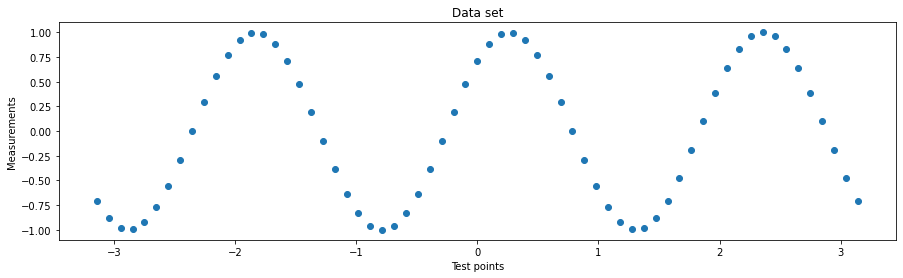

In [10]:
target = data_set()

<a name="p1s1"></a>

#### Population: 2000, Tournament size: 5 

In [11]:
no_population = 2000   # population size
no_tournaments = 5     # tournament size

##### Run 1

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	5.38326e+28	0  	8.09943e+31	1.47824	0.493627	2000  	1.83476e+30	3.6225	0  	7  	3  	2  	2000  	1.51789
1  	1615  	1.11501e+28	1  	2.23002e+31	0.992308	0.484434	1615  	4.98523e+29	3.756 	1  	13 	3  	1  	1615  	1.86426
2  	1545  	3.71458e+27	2  	3.32595e+30	0.803682	0.3905  	1545  	9.86218e+28	4.2135	2  	16 	4  	1  	1545  	2.05278
3  	1592  	2.65755e+28	3  	2.02486e+31	0.5     	0.455232	1592  	6.58806e+29	4.577 	3  	17 	4  	1  	1592  	2.32251
4  	1579  	8.95838e+28	4  	2.8455e+31 	0.5     	0.3905  	1579  	1.31872e+30	5.195 	4  	20 	5  	1  	1579  	2.71348
5  	1578  	3.967

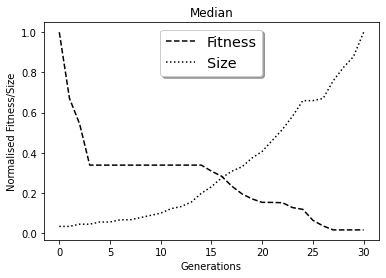

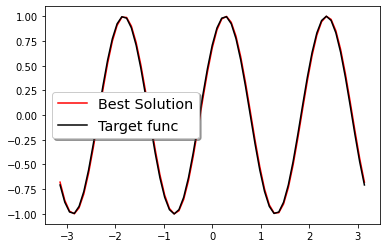

Best individual:
neg(sin(add(mul(protectedDiv(add(protectedDiv(1, -1), sub(-1, 1)), 1), x), protectedDiv(sin(sin(-1)), cos(mul(sin(sin(sin(add(mul(x, -1), neg(0))))), neg(0)))))))


In [12]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 2

   	      	                                      fitness                                      	                         size                         
   	      	-----------------------------------------------------------------------------------	------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std   
0  	2000  	4.20517e+28	0  	3.28258e+31	1.47824	0.493627	2000  	1.01304e+30	3.623	0  	7  	3  	2  	2000  	1.5313
1  	1539  	1.3756e+28 	1  	8.20644e+30	0.985935	0.493627	1539  	2.88431e+29	3.762	1  	14 	3  	1  	1539  	1.82958
2  	1561  	1.65168e+28	2  	8.20644e+30	0.803682	0.420513	1561  	3.47159e+29	4.141	2  	15 	4  	1  	1561  	2.00028
3  	1551  	1.9405e+28 	3  	2.02486e+31	0.5     	0.420513	1551  	5.11908e+29	4.6055	3  	16 	4  	1  	1551  	2.27109
4  	1563  	2.56158e+28	4  	2.02486e+31	0.5     	0.420513	1563  	6.4801e+29 	5.097 	4  	24 	5  	1  	1563  	2.66694
5  	1600  	5.83652e+28	5

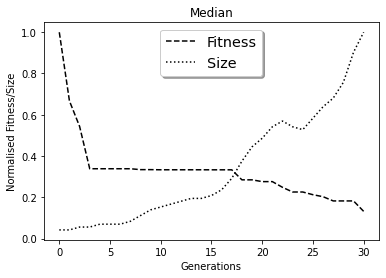

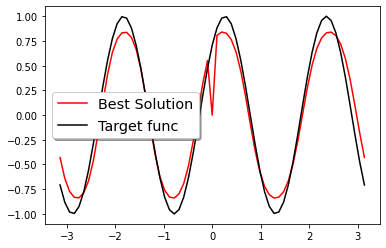

Best individual:
sin(sin(mul(mul(sub(sub(sub(-1, 1), mul(sub(cos(neg(-1)), mul(protectedDiv(-1, protectedDiv(sin(mul(0, mul(cos(1), mul(cos(-1), -1)))), 1)), 1)), mul(sub(x, sin(neg(mul(x, 1)))), protectedDiv(sub(cos(0), sin(0)), mul(-1, mul(x, x)))))), add(sub(add(0, 1), cos(sub(neg(0), sin(0)))), cos(mul(mul(sub(sub(mul(sub(-1, -1), protectedDiv(0, x)), -1), mul(-1, 1)), 0), sub(mul(x, x), x))))), x), neg(1))))


In [13]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 3

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max       	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	4.37083e+28	0  	2.8455e+31	1.47824	0.492585	2000  	9.39356e+29	3.5725	0  	7  	3  	2  	2000  	1.51616
1  	1578  	5.12903e+27	1  	8.20644e+30	0.992308	0.492585	1578  	1.8908e+29 	3.632 	1  	13 	3  	1  	1578  	1.80183
2  	1586  	1.35546e+28	2  	1.53984e+31	0.803682	0.492585	1586  	3.9396e+29 	4.0315	2  	16 	3  	1  	1586  	2.03507
3  	1589  	3.67952e+28	3  	3.28258e+31	0.528581	0.492585	1589  	9.90019e+29	4.5675	3  	18 	4  	1  	1589  	2.4618 
4  	1561  	9.45036e+57	4  	1.89007e+61	0.5     	0.492585	1561  	4.22527e+59	5.071 	4  	22 	4  	1  	1561  	2.76947
5  	1583  	6.83659

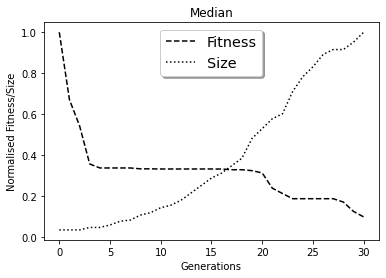

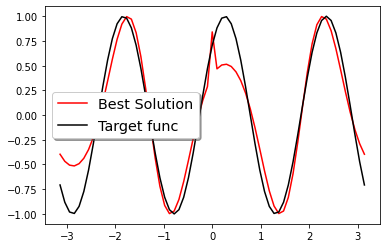

Best individual:
sin(protectedDiv(mul(mul(mul(add(x, x), neg(cos(sub(add(1, -1), mul(neg(mul(0, x)), mul(mul(add(protectedDiv(protectedDiv(1, -1), sin(mul(1, x))), -1), cos(add(-1, -1))), x)))))), sub(add(-1, mul(0, 1)), sin(1))), sin(sub(add(x, -1), sin(neg(-1))))), x))


In [14]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 4

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	4.11979e+28	0  	3.28258e+31	1.47824	0.492585	2000  	9.20586e+29	3.5545	0  	7  	3  	2  	2000  	1.53168
1  	1582  	1.27514e+28	1  	8.20644e+30	0.985935	0.492585	1582  	2.63709e+29	3.7255	1  	13 	3  	1  	1582  	1.90608
2  	1563  	3.49873e+28	2  	1.63532e+31	0.803682	0.492585	1563  	5.46681e+29	4.3135	2  	18 	4  	1  	1563  	2.23723
3  	1593  	4.6798e+28 	3  	2.02486e+31	0.5     	0.492585	1593  	8.1672e+29 	4.884 	3  	17 	4  	1  	1593  	2.63734
4  	1555  	5.1181e+28 	4  	2.8455e+31 	0.5     	0.492585	1555  	1.01852e+30	5.479 	4  	22 	5  	1  	1555  	3.00093
5  	1566  	1.215

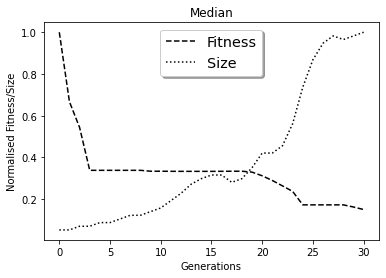

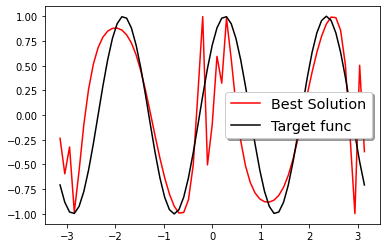

Best individual:
sin(protectedDiv(cos(sub(neg(add(x, add(x, protectedDiv(protectedDiv(mul(0, neg(protectedDiv(x, x))), protectedDiv(-1, -1)), sin(x))))), cos(sin(protectedDiv(add(x, 1), add(0, -1)))))), add(sin(x), protectedDiv(protectedDiv(mul(0, sub(neg(add(x, add(x, protectedDiv(protectedDiv(mul(0, neg(protectedDiv(protectedDiv(mul(x, 1), protectedDiv(cos(mul(x, x)), -1)), x))), protectedDiv(-1, -1)), sin(x))))), cos(sin(protectedDiv(add(x, 1), add(0, -1)))))), -1), x))))


In [15]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 5

   	      	                                      fitness                                      	                         size                         
   	      	-----------------------------------------------------------------------------------	------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std   
0  	2000  	1.04625e+29	0  	1.99846e+32	1.47824	0.493627	2000  	4.47126e+30	3.5195	0  	7  	3  	2  	2000  	1.4733
1  	1615  	7.30806e+27	1  	8.20644e+30	0.992308	0.492585	1615  	2.25125e+29	3.85  	1  	14 	3  	1  	1615  	1.93972
2  	1617  	2.00145e+29	2  	1.99846e+32	0.803682	0.492585	1617  	6.31651e+30	4.446 	2  	20 	4  	1  	1617  	2.29414
3  	1597  	1.22798e+28	3  	2.02486e+31	0.5     	0.492585	1597  	4.57255e+29	4.9045	3  	20 	4  	1  	1597  	2.62038
4  	1591  	1.82416e+28	4  	2.02486e+31	0.5     	0.492585	1591  	4.98259e+29	5.4695	4  	20 	5  	1  	1591  	2.91772
5  	1569  	5.88759e+

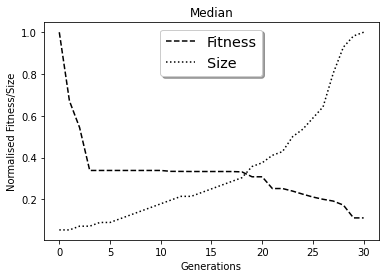

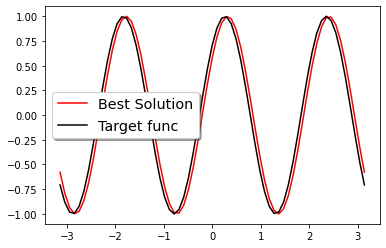

Best individual:
mul(1, sin(protectedDiv(mul(add(sin(1), neg(x)), add(neg(1), add(-1, -1))), -1)))


In [16]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 6

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max       	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	4.73018e+28	0  	2.8455e+31	1.47824	0.493627	2000  	8.90735e+29	3.5535	0  	7  	3  	2  	2000  	1.48968
1  	1633  	4.12681e+28	1  	2.8455e+31	0.992308	0.492585	1633  	9.24367e+29	3.807 	1  	13 	3  	1  	1633  	1.9297 
2  	1564  	7.21634e+28	2  	8.09943e+31	0.803682	0.492585	1564  	2.01355e+30	4.2745	2  	16 	4  	1  	1564  	2.15781
3  	1582  	5.12903e+27	3  	8.20644e+30	0.521682	0.444265	1582  	1.8908e+29 	4.6125	3  	14 	4  	1  	1582  	2.33759
4  	1567  	3.11298e+28	4  	2.78282e+31	0.5     	0.444265	1567  	7.9544e+29 	5.0465	4  	18 	5  	1  	1567  	2.70709
5  	1543  	8.57685e

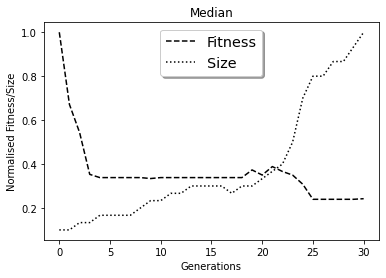

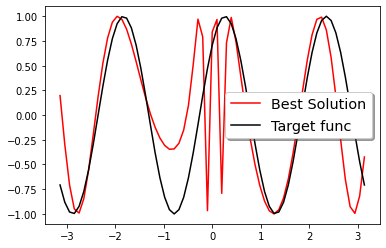

Best individual:
sin(protectedDiv(sub(protectedDiv(protectedDiv(x, sub(x, protectedDiv(mul(x, x), x))), 1), mul(mul(x, x), protectedDiv(sub(protectedDiv(protectedDiv(1, sub(mul(mul(x, x), x), protectedDiv(mul(x, x), x))), 0), mul(mul(x, x), sin(neg(1)))), x))), x))


In [17]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 7

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	3.42721e+28	0  	2.02486e+31	1.47824	0.493627	2000  	6.01904e+29	3.5505	0  	7  	3  	2  	2000  	1.46985
1  	1540  	3.06404e+28	1  	3.28258e+31	0.985935	0.492585	1540  	8.81194e+29	3.752 	1  	12 	3  	1  	1540  	1.86454
2  	1571  	1.01979e+28	2  	2.02486e+31	0.803682	0.492585	1571  	4.52669e+29	4.105 	2  	13 	4  	1  	1571  	2.01022
3  	1593  	3.94394e+28	3  	3.28258e+31	0.5     	0.492585	1593  	9.75951e+29	4.5625	3  	18 	4  	1  	1593  	2.32424
4  	1567  	2.22619e+28	4  	2.02486e+31	0.5     	0.492585	1567  	5.39296e+29	5.0055	4  	18 	5  	1  	1567  	2.64565
5  	1571  	9.232

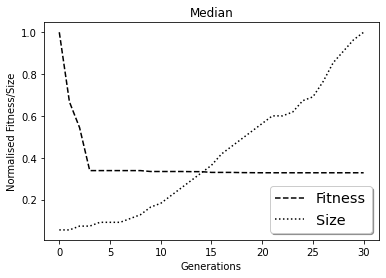

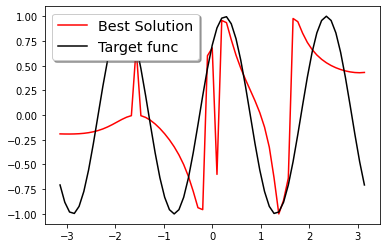

Best individual:
sin(mul(protectedDiv(-1, mul(mul(1, x), add(protectedDiv(-1, mul(mul(-1, add(neg(protectedDiv(x, 1)), 1)), add(sin(neg(x)), -1))), -1))), cos(cos(sin(cos(cos(-1)))))))


In [18]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 8

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max       	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	2000  	1.93565e+28	0  	2.8455e+31	1.47824	0.492585	2000  	6.62855e+29	3.506	0  	7  	3  	2  	2000  	1.46866
1  	1571  	9.23225e+27	1  	8.20644e+30	0.985935	0.493627	1571  	2.63372e+29	3.7135	1  	15 	3  	1  	1571  	1.84754
2  	1561  	8.20644e+27	2  	8.20644e+30	0.803682	0.455232	1561  	2.59381e+29	4.225 	2  	14 	4  	1  	1561  	2.10983
3  	1542  	1.32527e+27	3  	2.05161e+30	0.5     	0.455232	1542  	4.77718e+28	4.827 	3  	16 	4  	1  	1542  	2.40667
4  	1566  	2.85888e+28	4  	2.02486e+31	0.5     	0.455232	1566  	5.85735e+29	5.4255	4  	20 	5  	1  	1566  	2.80222
5  	1583  	4.12968e+

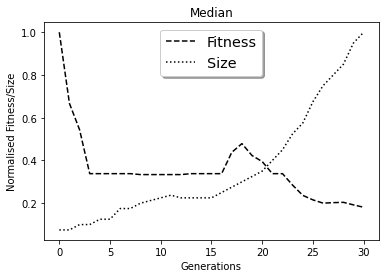

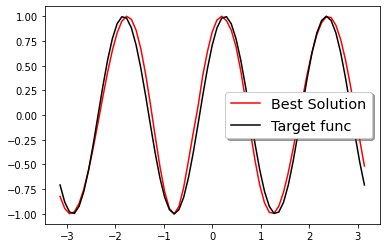

Best individual:
sin(add(add(x, 1), add(x, mul(protectedDiv(sin(0), mul(neg(x), 0)), add(add(x, -1), cos(sin(mul(x, mul(sin(add(protectedDiv(-1, mul(x, neg(-1))), neg(sin(-1)))), protectedDiv(-1, protectedDiv(0, protectedDiv(mul(protectedDiv(x, 1), x), -1))))))))))))


In [19]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 9

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	2000  	4.02251e+28	0  	3.28258e+31	1.47824	0.492585	2000  	9.08179e+29	3.569	0  	7  	3  	2  	2000  	1.49741
1  	1578  	1.45333e+28	1  	8.20644e+30	0.985935	0.289707	1578  	3.25241e+29	3.818	1  	14 	3  	1  	1578  	1.96542
2  	1579  	3.54636e+28	2  	2.8455e+31 	0.803682	0.289707	1579  	8.23952e+29	4.334	2  	17 	4  	1  	1579  	2.23952
3  	1601  	2.3498e+28 	3  	2.23002e+31	0.5     	0.289707	1601  	6.76812e+29	4.7075	3  	15 	4  	1  	1601  	2.35626
4  	1605  	2.61778e+28	4  	2.02486e+31	0.5     	0.289707	1605  	5.69738e+29	5.024 	4  	19 	5  	1  	1605  	2.58426
5  	1580  	6.53622e+

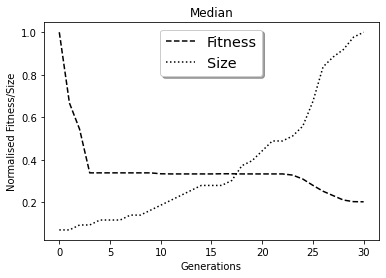

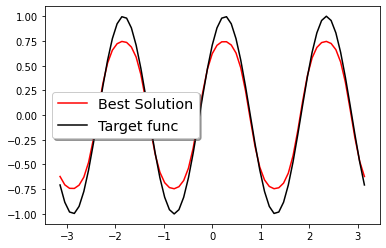

Best individual:
sin(sin(mul(1, cos(add(add(sub(x, mul(sin(sin(1)), 1)), x), x)))))


In [20]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 10

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	4.19243e+28	0  	3.28258e+31	1.47824	0.493627	2000  	9.43867e+29	3.5285	0  	7  	3  	2  	2000  	1.46601
1  	1564  	1.04238e+28	1  	2.02486e+31	0.985935	0.455232	1564  	4.5285e+29 	3.7975	1  	12 	3  	1  	1564  	1.90617
2  	1582  	6.88118e+27	2  	8.20644e+30	0.803682	0.455232	1582  	1.97205e+29	4.448 	2  	14 	4  	1  	1582  	2.20778
3  	1585  	2.87024e+28	3  	3.28258e+31	0.5     	0.455232	1585  	8.64395e+29	4.908 	3  	14 	5  	1  	1585  	2.40032
4  	1559  	2.27824    	4  	353.542    	0.5     	0.455232	1559  	13.1093    	5.2065	4  	17 	5  	1  	1559  	2.58125
5  	1534  	6.006

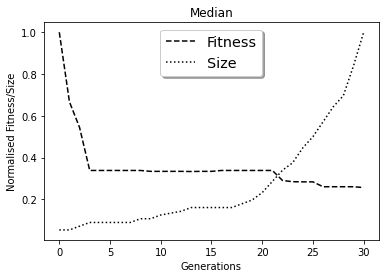

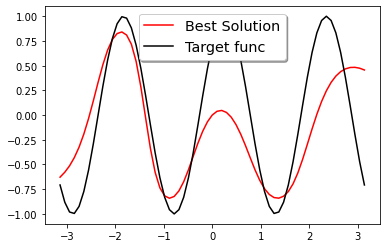

Best individual:
sin(sin(mul(mul(x, 1), neg(mul(add(mul(add(-1, x), cos(1)), sin(x)), protectedDiv(mul(x, neg(mul(x, x))), protectedDiv(0, add(sub(1, x), mul(1, 0)))))))))


In [21]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

<a name="p1s2"></a>

#### Population: 2000, Tournament size: 2 

In [22]:
no_population = 2000   # population size
no_tournaments = 2     # tournament size

##### Run 1

   	      	                                     fitness                                     	                          size                         
   	      	---------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std      	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	3.76873e+28	0  	3.28258e+31	1.47824	0.492968	2000  	9.744e+29	3.5605	0  	7  	3  	2  	2000  	1.48941
1  	1582  	4.10322e+27	1  	8.20644e+30	0.992308	0.296079	1582  	1.83456e+29	3.795 	1  	13 	3  	1  	1582  	1.87589
2  	1558  	8.20644e+27	2  	8.20644e+30	0.803682	0.296079	1558  	2.59381e+29	4.254 	2  	15 	4  	1  	1558  	2.14207
3  	1550  	8.95857e+27	3  	8.20644e+30	0.5     	0.0228636	1550  	2.61385e+29	4.7965	3  	16 	4  	1  	1550  	2.45644
4  	1607  	6.00535e+28	4  	2.44838e+31	0.5     	0.0228636	1607  	1.01127e+30	5.237 	4  	21 	5  	1  	1607  	2.75678
5  	1623  	8.12132e+28

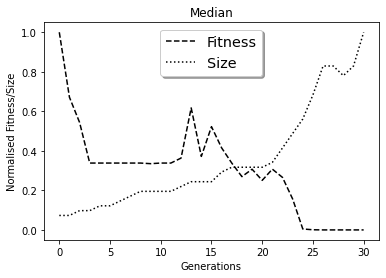

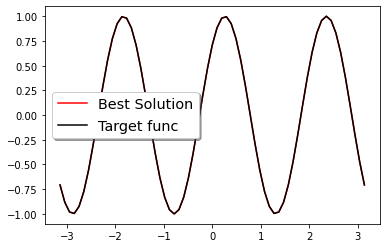

Best individual:
sin(add(add(x, x), sub(x, mul(add(mul(0, protectedDiv(sub(0, -1), mul(-1, add(add(x, x), sub(x, mul(add(mul(0, protectedDiv(sub(1, add(x, add(sub(neg(x), x), mul(1, -1)))), sin(cos(0)))), cos(sin(sin(sin(-1))))), -1)))))), cos(sin(sin(sin(add(neg(0), cos(sin(add(add(sub(x, x), sin(add(-1, cos(sin(sin(-1)))))), cos(1)))))))))), -1))))


In [23]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 2

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	4.19264e+28	0  	8.09943e+31	1.47824	0.493627	2000  	1.81124e+30	3.5975	0  	7  	3  	2  	2000  	1.50847
1  	1576  	1.55098e+28	1  	2.8455e+31 	0.985935	0.493627	1576  	6.38664e+29	3.717 	1  	13 	3  	1  	1576  	1.90208
2  	1608  	4.79773e+28	2  	2.23002e+31	0.803682	0.289707	1608  	9.91212e+29	4.3505	2  	16 	4  	1  	1608  	2.23286
3  	1557  	3.35841e+28	3  	2.8455e+31 	0.5     	0.289707	1557  	8.48358e+29	4.829 	3  	20 	4  	1  	1557  	2.51729
4  	1553  	4.95574e+28	4  	2.23002e+31	0.5     	0.289707	1553  	9.55961e+29	5.426 	4  	16 	5  	1  	1553  	2.75981
5  	1622  	8.979

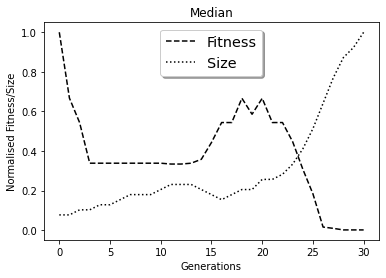

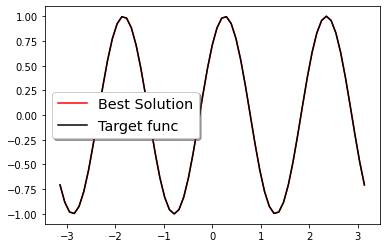

Best individual:
cos(add(mul(x, 1), add(x, sub(add(x, protectedDiv(cos(cos(sin(protectedDiv(0, sub(add(-1, x), add(mul(1, add(neg(protectedDiv(x, x)), x)), mul(add(x, add(add(x, sub(mul(x, protectedDiv(x, add(x, x))), 1)), mul(x, 1))), 0))))))), protectedDiv(-1, 1))), sin(protectedDiv(0, sub(sub(add(1, add(add(add(add(sin(-1), x), protectedDiv(0, add(add(-1, -1), add(x, 0)))), add(x, x)), x)), 1), sub(-1, sin(x)))))))))


In [24]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 3

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	4.28163e+28	0  	3.28258e+31	1.47824	0.493627	2000  	9.92381e+29	3.5735	0  	7  	3  	2  	2000  	1.50718
1  	1577  	2.2434e+28 	1  	2.02486e+31	0.992308	0.455232	1577  	5.52737e+29	3.7105	1  	15 	3  	1  	1577  	1.84193
2  	1587  	5.42659e+28	2  	2.23002e+31	0.940236	0.492585	1587  	8.96219e+29	4.2895	2  	18 	4  	1  	1587  	2.13089
3  	1577  	4.50659e+28	3  	2.23002e+31	0.696814	0.492359	1577  	6.77772e+29	4.666 	3  	15 	4  	1  	1577  	2.357  
4  	1587  	6.28694e+28	4  	2.23002e+31	0.5     	0.492585	1587  	1.0304e+30 	5.135 	4  	17 	5  	1  	1587  	2.56998
5  	1590  	1.013

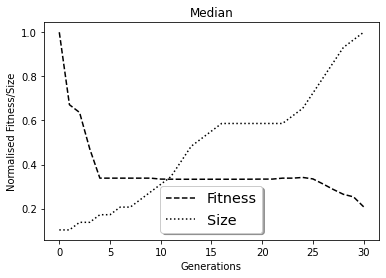

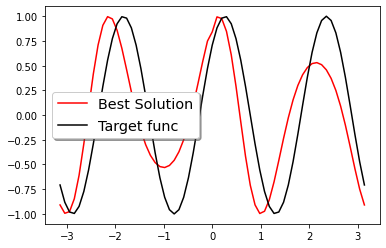

Best individual:
sin(protectedDiv(mul(add(x, x), protectedDiv(cos(add(1, x)), cos(cos(mul(1, 0))))), x))


In [25]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 4

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max       	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	4.76778e+28	0  	2.8455e+31	1.47824	0.493627	2000  	1.05213e+30	3.5845	0  	7  	3  	2  	2000  	1.52147
1  	1556  	2.57802e+28	1  	2.8455e+31	0.985935	0.492585	1556  	8.08103e+29	3.759 	1  	12 	3  	1  	1556  	1.86411
2  	1604  	5.06454e+28	2  	3.28258e+31	0.803682	0.492585	1604  	1.19701e+30	4.302 	2  	15 	4  	1  	1604  	2.06925
3  	1570  	2.69529e+28	3  	2.8455e+31 	0.5     	0.383772	1570  	7.10973e+29	4.663 	3  	16 	4  	1  	1570  	2.3213 
4  	1563  	6.46239e+28	4  	9.74732e+31	0.5     	0.383772	1563  	2.21268e+30	5.0535	4  	18 	5  	1  	1563  	2.56742
5  	1559  	2.31603e

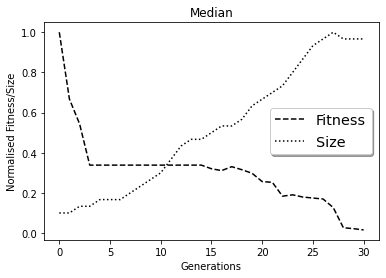

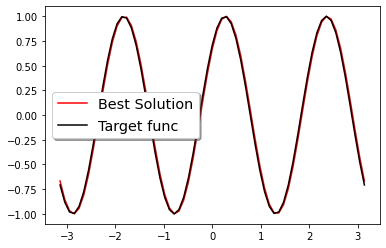

Best individual:
mul(mul(cos(add(x, add(add(neg(sin(1)), x), x))), 1), cos(mul(0, add(cos(mul(sin(sin(x)), sin(x))), 1))))


In [26]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 5

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	2.44856e+28	0  	2.02486e+31	1.47824	0.492585	2000  	5.55662e+29	3.5895	0  	7  	3  	2  	2000  	1.52052
1  	1581  	3.79548e+28	1  	3.28258e+31	0.985935	0.492585	1581  	1.05445e+30	3.7625	1  	13 	3  	1  	1581  	1.85286
2  	1621  	5.11792e+28	2  	3.28258e+31	0.803682	0.492331	1621  	1.12514e+30	4.303 	2  	13 	4  	1  	1621  	2.13288
3  	1593  	1.09717e+29	3  	8.09943e+31	0.5     	0.492331	1593  	2.68101e+30	4.847 	3  	17 	4  	1  	1593  	2.38319
4  	1621  	3.6954e+29 	4  	3.23977e+32	0.5     	0.482671	1621  	1.0282e+31 	5.296 	4  	18 	5  	1  	1621  	2.68279
5  	1569  	1.154

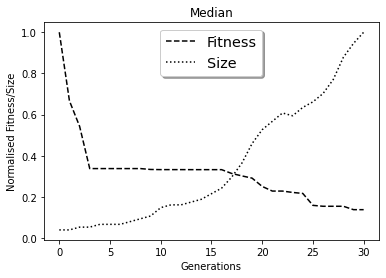

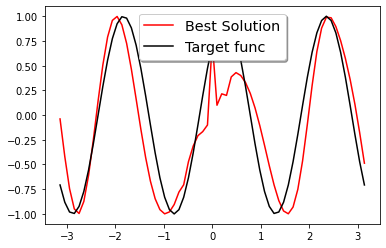

Best individual:
sin(add(sin(protectedDiv(mul(sin(protectedDiv(mul(x, mul(1, x)), mul(protectedDiv(x, x), x))), mul(1, x)), x)), mul(mul(sin(sub(mul(1, protectedDiv(sin(sub(sin(sub(x, mul(protectedDiv(protectedDiv(mul(neg(x), add(0, 1)), sin(sub(add(1, 1), protectedDiv(cos(-1), x)))), mul(x, x)), x))), x)), x)), mul(-1, neg(cos(sin(sin(protectedDiv(protectedDiv(0, neg(sub(1, -1))), mul(sin(protectedDiv(x, sin(mul(0, 0)))), add(sin(protectedDiv(mul(x, mul(1, x)), mul(protectedDiv(x, x), x))), mul(mul(-1, x), 1))))))))))), x), x)))


In [27]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 6

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	2.50399e+28	0  	2.02486e+31	1.47824	0.493627	2000  	5.44034e+29	3.5145	0  	7  	3  	2  	2000  	1.48013
1  	1580  	1.02581e+27	1  	2.05161e+30	0.985935	0.492331	1580  	4.58639e+28	3.768 	1  	13 	3  	1  	1580  	1.89002
2  	1577  	1.12549e+28	2  	8.20644e+30	0.803682	0.492331	1577  	2.69702e+29	4.2815	2  	14 	4  	1  	1577  	2.15969
3  	1586  	6.71303e+28	3  	2.23002e+31	0.5     	0.492331	1586  	1.09939e+30	4.589 	3  	18 	4  	1  	1586  	2.40667
4  	1591  	3.26098e+28	4  	2.23002e+31	0.5     	0.492331	1591  	7.25431e+29	5.0295	4  	19 	5  	1  	1591  	2.67855
5  	1606  	8.574

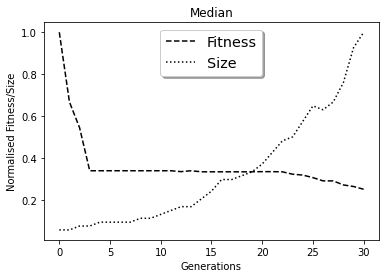

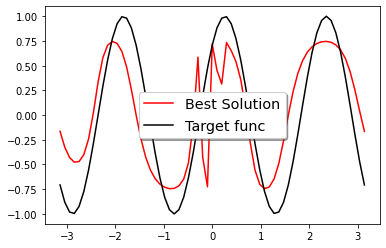

Best individual:
sin(sin(sin(protectedDiv(protectedDiv(cos(x), protectedDiv(mul(x, sin(protectedDiv(sin(protectedDiv(protectedDiv(sub(neg(-1), sin(neg(x))), protectedDiv(mul(x, sin(protectedDiv(sin(x), mul(0, protectedDiv(sin(x), 1))))), -1)), x)), mul(0, protectedDiv(sin(protectedDiv(-1, x)), 1))))), -1)), sin(protectedDiv(mul(cos(sin(sub(-1, x))), cos(-1)), x))))))


In [28]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 7

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg       	gen	max       	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	2000  	4.5932e+28	0  	2.8455e+31	1.47824	0.493627	2000  	9.41894e+29	3.623	0  	7  	3  	2  	2000  	1.51983
1  	1615  	3.15324e+28	1  	2.8455e+31	0.992308	0.493627	1615  	8.30892e+29	3.854	1  	13 	3  	1  	1615  	1.93331
2  	1597  	2.90538e+27	2  	5.81076e+30	0.803682	0.492585	1597  	1.299e+29  	4.554	2  	16 	4  	1  	1597  	2.31648
3  	1564  	5.57282e+28	3  	2.23002e+31	0.5     	0.492585	1564  	9.90349e+29	4.993	3  	16 	5  	1  	1564  	2.57739
4  	1561  	1.44325e+29	4  	1.614e+32  	0.5     	0.492585	1561  	3.7594e+30 	5.6465	4  	21 	5  	1  	1561  	2.97683
5  	1587  	8.91569e+28	5  

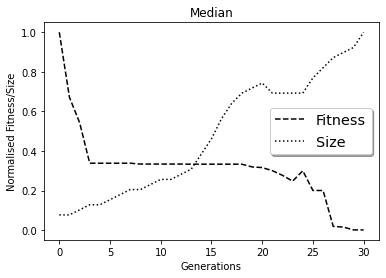

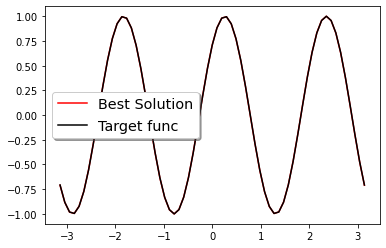

Best individual:
sin(add(sin(sin(add(1, 1))), add(mul(add(-1, -1), protectedDiv(x, -1)), x)))


In [29]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 8

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	4.41416e+28	0  	2.02486e+31	1.47824	0.492585	2000  	7.63488e+29	3.5385	0  	7  	3  	2  	2000  	1.46066
1  	1592  	1.02581e+27	1  	2.05161e+30	0.985935	0.455232	1592  	4.58639e+28	3.768 	1  	13 	3  	1  	1592  	1.90451
2  	1604  	4.07647e+28	2  	3.28258e+31	0.803682	0.455232	1604  	9.90344e+29	4.366 	2  	15 	4  	1  	1604  	2.19341
3  	1595  	3.2968e+28 	3  	5.30744e+31	0.5     	0.455232	1595  	1.20251e+30	5.0005	3  	17 	5  	1  	1595  	2.54372
4  	1598  	2.47552e+28	4  	2.02486e+31	0.5     	0.455232	1598  	6.46538e+29	5.5385	4  	21 	5  	1  	1598  	2.83805
5  	1551  	1.003

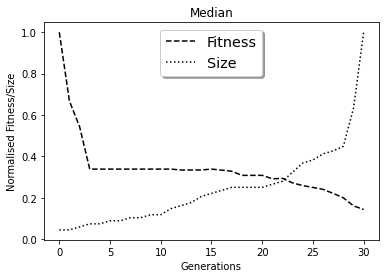

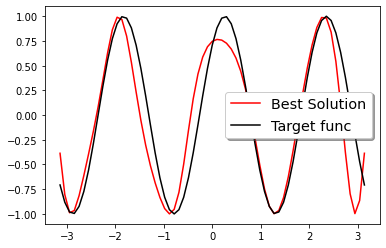

Best individual:
sin(neg(add(mul(x, x), neg(sin(protectedDiv(add(sin(x), cos(add(protectedDiv(x, protectedDiv(neg(neg(neg(mul(neg(protectedDiv(mul(x, protectedDiv(x, 1)), x)), sub(1, protectedDiv(neg(1), add(x, mul(cos(x), cos(sin(add(mul(protectedDiv(sub(x, -1), mul(1, x)), x), protectedDiv(mul(mul(protectedDiv(mul(x, mul(0, 0)), x), mul(1, mul(sin(add(mul(x, x), protectedDiv(mul(protectedDiv(mul(cos(protectedDiv(1, 0)), mul(sin(protectedDiv(add(sin(x), cos(1)), 1)), 0)), x), neg(neg(add(x, -1)))), cos(sin(add(x, 0)))))), cos(sin(-1))))), neg(0)), 0)))))))))))), 0)), x))), 1))))))


In [30]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 9

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	1.49539e+28	0  	2.02486e+31	1.47824	0.492585	2000  	4.89395e+29	3.5595	0  	7  	3  	2  	2000  	1.48508
1  	1563  	3.85793e+28	1  	2.8455e+31 	0.985935	0.0228636	1563  	9.20344e+29	3.7815	1  	12 	3  	1  	1563  	1.81542
2  	1583  	2.74126e+28	2  	3.28258e+31	0.803682	0.492585 	1583  	7.79621e+29	4.37  	2  	16 	4  	1  	1583  	2.18085
3  	1589  	1.99937e+28	3  	2.02486e+31	0.5     	0.0230139	1589  	5.26763e+29	4.7585	3  	16 	4  	1  	1589  	2.42388
4  	1577  	3.07742e+27	4  	2.05161e+30	0.5     	0.492585 	1577  	7.93989e+28	5.4805	4  	19 	5  	1  	1577  	2.97802
5  	1587  	2

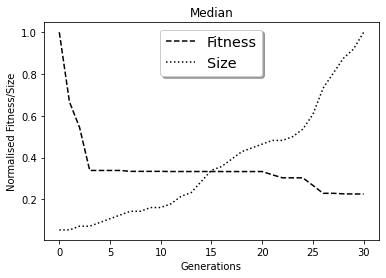

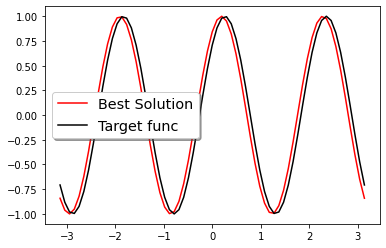

Best individual:
sin(sub(add(x, x), sub(-1, x)))


In [31]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 10

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	2000  	2.22619e+28	0  	2.23002e+31	1.47824	0.493627	2000  	5.76526e+29	3.571	0  	7  	3  	2  	2000  	1.52248
1  	1597  	3.04684e+28	1  	2.02486e+31	0.992308	0.493627	1597  	5.98124e+29	3.704	1  	13 	3  	1  	1597  	1.89457
2  	1576  	5.90163e+27	2  	8.20644e+30	0.803682	0.455232	1576  	1.95141e+29	4.329	2  	15 	4  	1  	1576  	2.25117
3  	1599  	3.79733e+28	3  	2.23002e+31	0.5     	0.455232	1599  	7.45238e+29	4.84 	3  	15 	4  	1  	1599  	2.50847
4  	1627  	1.68679e+29	4  	2.20094e+32	0.5     	0.455232	1627  	5.0299e+30 	5.5065	4  	21 	5  	1  	1627  	2.94465
5  	1603  	9.42518e+2

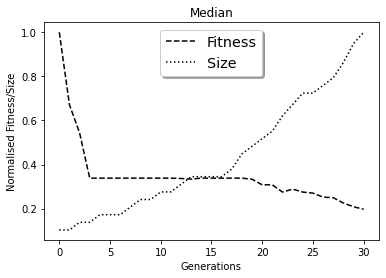

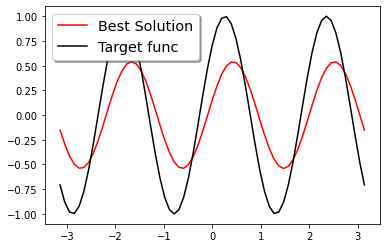

Best individual:
mul(neg(protectedDiv(cos(1), protectedDiv(sin(cos(mul(protectedDiv(sin(1), 0), sin(x)))), 0))), protectedDiv(sin(mul(sub(neg(1), add(1, 1)), sub(x, add(1, 1)))), 1))


In [32]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

<a name="p1s3"></a>

#### Population: 500, Tournament: 2 

In [33]:
no_population = 500   # population size
no_tournaments = 2     # tournament size

##### Run 1

   	      	                                  fitness                                  	                          size                         
   	      	---------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max       	mdn    	min	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	1.78937e+29	0  	2.8455e+31	1.52176	0.5	500   	1.87446e+30	3.596	0  	7  	3  	2  	500   	1.54557
1  	389   	7.33229e+28	1  	2.02486e+31	1.02945	0.493627	389   	1.04116e+30	3.87 	1  	10 	3  	1  	389   	1.95783
2  	390   	1.69476e+29	2  	2.8455e+31 	0.803682	0.492585	390   	2.02341e+30	4.602	2  	13 	4  	1  	390   	2.29687
3  	383   	1.55387e+29	3  	3.28258e+31	0.5     	0.492585	383   	1.83167e+30	5.138	3  	15 	5  	1  	383   	2.6243 
4  	402   	1.91123    	4  	25.5918    	0.5     	0.492585	402   	3.55508    	5.204	4  	17 	5  	1  	402   	2.73539
5  	403   	4.92387e+28	5  	8.20644e+30	0.5     	0.4

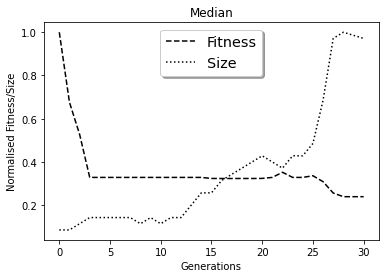

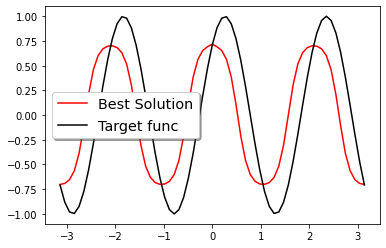

Best individual:
sin(sin(sin(protectedDiv(protectedDiv(cos(add(add(x, x), x)), sin(sub(1, -1))), cos(sin(protectedDiv(protectedDiv(protectedDiv(0, sin(1)), sin(protectedDiv(x, cos(cos(sin(x)))))), sin(sin(-1)))))))))


In [34]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 2

   	      	                        fitness                        	                          size                         
   	      	-------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg    	gen	max    	mdn    	min	nevals	std    	avg  	gen	max	mdn	min	nevals	std    
0  	500   	2.60636	0  	50.4678	1.47824	0.5	500   	3.89239	3.534	0  	7  	3  	2  	500   	1.55205
1  	397   	3.57312e+28	1  	8.20644e+30	0.985935	0.492585	397   	5.21849e+29	3.608	1  	12 	3  	1  	397   	1.87998
2  	394   	2.41284e+28	2  	8.20644e+30	0.803682	0.492585	394   	4.04813e+29	4.012	2  	14 	3  	1  	394   	2.17436
3  	406   	1.70341    	3  	82.2948    	0.521585	0.455232	406   	4.92638    	4.27 	3  	13 	4  	1  	406   	2.2381 
4  	403   	1.64129e+28	4  	8.20644e+30	0.5     	0.455232	403   	3.66636e+29	4.694	4  	16 	4  	1  	403   	2.49807
5  	421   	1.76072    	5  	146.743    	0.5     	0.455232	421   	8.17829    	5.012	5  	15 	4  	1  	421   	2.73932

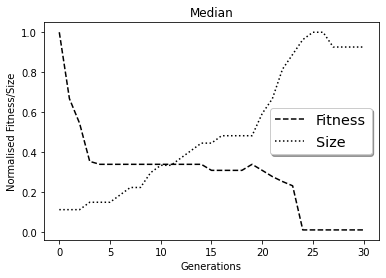

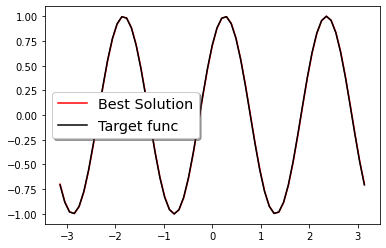

Best individual:
sin(mul(sub(sin(sin(sub(1, -1))), x), sub(neg(add(-1, -1)), -1)))


In [35]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 3

   	      	                                  fitness                                  	                          size                         
   	      	---------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	2.05161e+28	0  	8.20644e+30	1.47824	0.5	500   	3.77742e+29	3.494	0  	7  	3  	2  	500   	1.47172
1  	405   	1.63717    	1  	24.539     	1.11099	0.493627	405   	1.99205    	3.614	1  	12 	3  	1  	405   	1.78017
2  	404   	1.64129e+28	2  	8.20644e+30	0.985935	0.493627	404   	3.66636e+29	4.034	2  	11 	3  	1  	404   	1.98415
3  	382   	1.57141    	3  	53.1389    	0.5     	0.493627	382   	3.05417    	4.54 	3  	17 	4  	1  	382   	2.50048
4  	391   	1.88086e+28	4  	8.20644e+30	0.5     	0.493627	391   	3.68473e+29	5.036	4  	16 	5  	1  	391   	2.62806
5  	399   	4.46004e+28	5  	2.23002e+31	0.5     	0

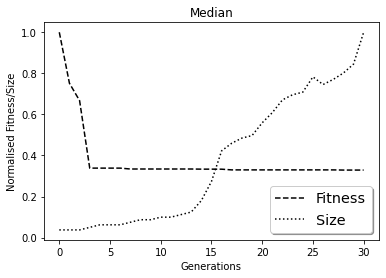

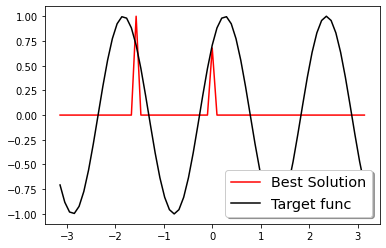

Best individual:
protectedDiv(mul(sin(sin(sin(protectedDiv(mul(0, mul(x, 1)), x)))), neg(1)), mul(1, mul(sub(mul(cos(sin(1)), x), sub(1, x)), add(protectedDiv(protectedDiv(sin(x), protectedDiv(sin(mul(x, add(protectedDiv(x, x), protectedDiv(protectedDiv(sin(mul(protectedDiv(0, -1), add(add(-1, 1), sub(-1, neg(add(x, cos(x))))))), cos(add(protectedDiv(protectedDiv(sin(mul(sub(cos(-1), sub(mul(sub(cos(-1), neg(1)), add(1, sub(-1, neg(mul(sin(protectedDiv(mul(0, 0), mul(sub(-1, 1), add(1, 1)))), x))))), 1)), add(1, sub(add(protectedDiv(sub(protectedDiv(protectedDiv(sin(mul(-1, add(protectedDiv(cos(1), x), sub(-1, neg(add(mul(x, neg(1)), cos(x))))))), cos(1)), 0), neg(add(protectedDiv(0, add(protectedDiv(x, -1), protectedDiv(-1, x))), cos(x)))), 0), sub(0, sin(mul(x, neg(1))))), neg(add(neg(-1), neg(x))))))), cos(1)), 0), sub(0, sin(mul(x, neg(1))))))), 0)))), cos(1))), 0), sub(0, sin(mul(x, neg(1))))))))


In [36]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 4 

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	2.53075e+28	0  	8.20644e+30	1.52176	0.493627	500   	3.92362e+29	3.626	0  	7  	3  	2  	500   	1.51464
1  	369   	1.61989e+29	1  	8.09943e+31	0.985935	0.493627	369   	3.61855e+30	3.722	1  	12 	3  	1  	369   	1.80464
2  	410   	2.54753    	2  	291.953    	0.803682	0.493627	410   	15.0845    	4.006	2  	15 	4  	1  	410   	1.95191
3  	395   	4.04972e+28	3  	2.02486e+31	0.5     	0.493627	395   	9.04638e+29	4.35 	3  	12 	4  	1  	395   	2.05122
4  	378   	2.59949    	4  	364.414    	0.5     	0.493627	378   	16.7359    	4.688	4  	13 	4  	1  	378   	2.31055
5  	376   	1.64129e+28

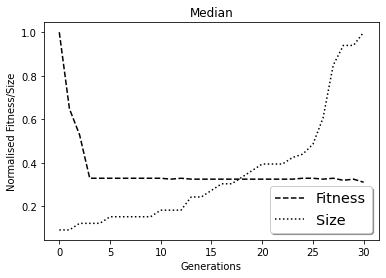

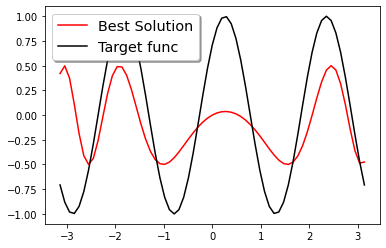

Best individual:
protectedDiv(sin(mul(add(x, neg(cos(neg(protectedDiv(x, mul(neg(sin(mul(add(x, neg(sub(add(x, mul(-1, 0)), mul(add(mul(x, -1), 0), x)))), x))), 0)))))), x)), neg(sub(1, -1)))


In [37]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 5

   	      	                            fitness                            	                          size                         
   	      	---------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg    	gen	max    	mdn    	min     	nevals	std    	avg  	gen	max	mdn	min	nevals	std    
0  	500   	2.91479	0  	146.743	1.52131	0.493627	500   	7.09088	3.636	0  	7  	3  	2  	500   	1.58351
1  	392   	1.42718e+29	1  	2.23002e+31	0.992308	0.455232	392   	1.65807e+30	3.934	1  	14 	3  	1  	392   	2.0074 
2  	399   	7.74262e+28	2  	2.23002e+31	0.757145	0.455232	399   	1.07562e+30	4.306	2  	13 	4  	1  	399   	2.16526
3  	414   	1.64129e+28	3  	2.05161e+30	0.5     	0.455232	414   	1.82766e+29	4.738	3  	14 	4  	1  	414   	2.52059
4  	384   	1.4794     	4  	59.4911    	0.5     	0.455232	384   	3.83547    	5.13 	4  	16 	5  	1  	384   	2.77292
5  	396   	4.10322e+27	5  	2.05161e+30	0.5     	0.455232	396   	9.1659e+28 	5.23 	5  	

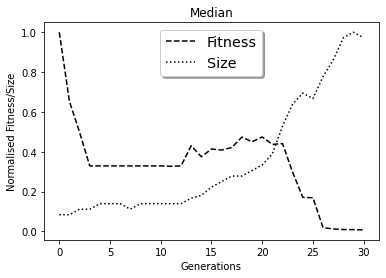

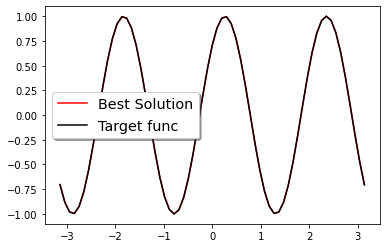

Best individual:
neg(sin(sub(protectedDiv(add(x, x), -1), add(x, cos(sin(sin(sin(1))))))))


In [38]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 6

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg 	gen	max	mdn	min	nevals	std    
0  	500   	4.93917e+28	0  	2.02486e+31	1.47824	0.493627	500   	9.15133e+29	3.63	0  	7  	3  	2  	500   	1.52089
1  	396   	2.90538e+27	1  	1.45269e+30	0.985935	0.5     	396   	6.49013e+28	3.662	1  	11 	3  	1  	396   	1.81322
2  	387   	7.0086e+27 	2  	2.05161e+30	0.803682	0.493627	387   	1.12204e+29	4.116	2  	14 	3  	1  	387   	2.27388
3  	381   	1.45787    	3  	54.6284    	0.5     	0.493627	381   	2.80694    	4.572	3  	15 	4  	1  	381   	2.62542
4  	398   	1.93183e+28	4  	8.20644e+30	0.5     	0.493627	398   	3.72208e+29	5.148	4  	17 	4.5	1  	398   	2.92132
5  	402   	3.28258e+28	5

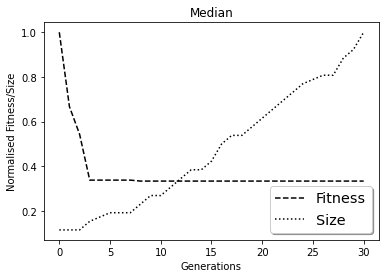

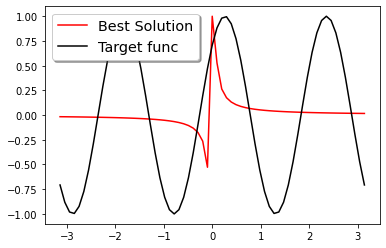

Best individual:
protectedDiv(neg(add(1, 1)), protectedDiv(x, sub(sin(cos(1)), cos(1))))


In [39]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 7

   	      	                                  fitness                                  	                          size                         
   	      	---------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	4.46004e+28	0  	2.02486e+31	1.47824	0.5	500   	9.09087e+29	3.694	0  	7  	3  	2  	500   	1.53635
1  	386   	3.28258e+28	1  	8.20644e+30	1.02548	0.492585	386   	5.17982e+29	3.92 	1  	12 	3  	1  	386   	1.86269
2  	420   	6.56515e+28	2  	3.28258e+31	1.03973	0.493627	420   	1.46654e+30	4.424	2  	15 	4  	1  	420   	2.02688
3  	404   	1.64129e+28	3  	8.20644e+30	1.03973	0.493627	404   	3.66636e+29	4.488	3  	15 	4  	1  	404   	2.14519
4  	398   	1.05614e+29	4  	2.8455e+31 	0.803682	0.492585	398   	1.56367e+30	5.142	4  	15 	5  	1  	398   	2.7426 
5  	390   	2.23785    	5  	259.459    	0.5     	0.4

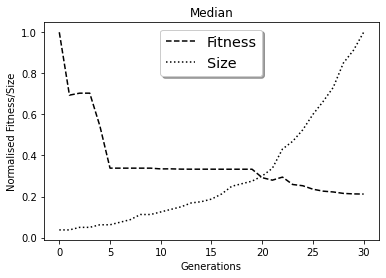

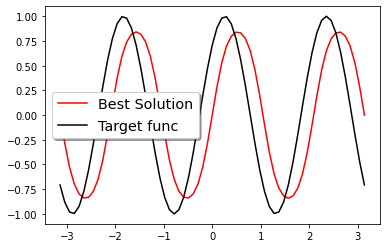

Best individual:
mul(sin(sin(protectedDiv(mul(x, sub(add(-1, -1), protectedDiv(-1, -1))), -1))), cos(neg(sub(x, x))))


In [40]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 8

   	      	                                  fitness                                  	                          size                         
   	      	---------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	1.64129e+28	0  	8.20644e+30	1.47824	0.5	500   	3.66636e+29	3.518	0  	7  	3  	2  	500   	1.48784
1  	386   	1.95572    	1  	35.6497    	0.985935	0.5	386   	3.48305    	3.756	1  	12 	3  	1  	386   	1.95562
2  	385   	1.52816    	2  	16.587     	0.803682	0.5	385   	1.82867    	4.148	2  	13 	3  	1  	385   	2.24279
3  	404   	7.20824e+28	3  	3.28258e+31	0.721324	0.493627	404   	1.47328e+30	4.856	3  	17 	4  	1  	404   	2.44034
4  	396   	3.62236e+28	4  	1.81118e+31	0.5     	0.493627	396   	8.09174e+29	5.36 	4  	23 	5  	1  	396   	2.84577
5  	386   	6.65189e+27	5  	3.32595e+30	0.5     	0.493627	3

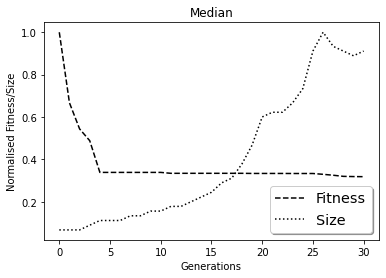

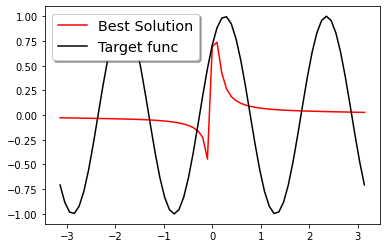

Best individual:
protectedDiv(protectedDiv(mul(sub(add(-1, 0), sin(-1)), sub(mul(0, sub(add(mul(add(0, cos(protectedDiv(add(-1, 1), add(x, x)))), -1), add(1, x)), cos(1))), cos(1))), x), neg(add(-1, sin(add(-1, cos(protectedDiv(sub(add(-1, sin(x)), sin(-1)), x)))))))


In [41]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 9

   	      	                                  fitness                                  	                          size                         
   	      	---------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	1.67799e+29	0  	8.09943e+31	1.52176	0.5	500   	3.61945e+30	3.584	0  	7  	3  	2  	500   	1.51886
1  	382   	1.19784e+27	1  	5.9892e+29 	0.992308	0.5	382   	2.67577e+28	3.708	1  	11 	3  	1  	382   	1.8854 
2  	399   	1.7509     	2  	53.9338    	0.944848	0.493627	399   	3.45622    	4.284	2  	13 	4  	1  	399   	2.19803
3  	415   	1.76959    	3  	41.4817    	0.5     	0.492585	415   	3.07614    	4.846	3  	17 	4  	1  	415   	2.66126
4  	395   	1.74866    	4  	87.4371    	0.5     	0.492585	395   	5.04457    	5.074	4  	17 	5  	1  	395   	2.74017
5  	404   	4.04972e+28	5  	2.02486e+31	0.5     	0.492

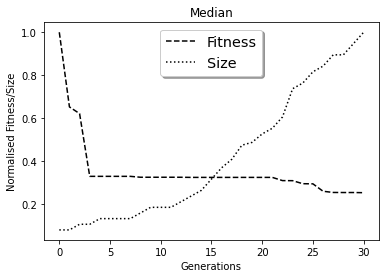

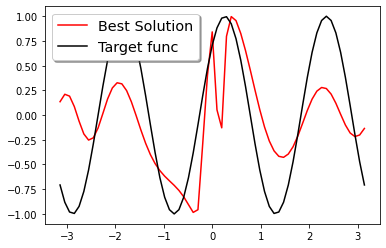

Best individual:
sin(protectedDiv(protectedDiv(mul(cos(cos(cos(-1))), cos(add(neg(mul(neg(x), x)), cos(sub(protectedDiv(1, 1), add(x, -1)))))), x), protectedDiv(0, protectedDiv(protectedDiv(protectedDiv(0, sub(-1, 1)), x), x))))


In [42]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 10

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg 	gen	max	mdn	min	nevals	std    
0  	500   	4.05225e+28	0  	8.20644e+30	1.47824	0.493627	500   	5.32391e+29	3.57	0  	7  	3  	2  	500   	1.49837
1  	398   	2.16947    	1  	206.987    	0.992308	0.492736	398   	9.71284    	3.764	1  	14 	3  	1  	398   	1.83311
2  	381   	2.11804    	2  	53.9338    	0.803682	0.492736	381   	5.85137    	4.116	2  	14 	4  	1  	381   	1.98458
3  	380   	1.64129e+28	3  	8.20644e+30	0.5     	0.492736	380   	3.66636e+29	4.698	3  	15 	4  	1  	380   	2.36956
4  	394   	2.05161e+28	4  	8.20644e+30	0.5     	0.492333	394   	3.77742e+29	5.222	4  	14 	5  	1  	394   	2.46348
5  	399   	4.1695e+28 	5

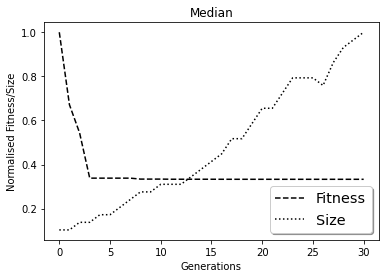

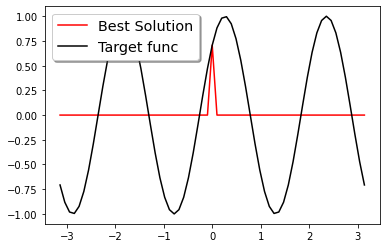

Best individual:
mul(cos(cos(sin(cos(cos(cos(cos(sin(cos(cos(cos(sin(sin(cos(cos(cos(cos(sin(cos(cos(cos(sin(cos(cos(cos(-1))))))))))))))))))))))))), protectedDiv(protectedDiv(0, cos(add(add(-1, cos(cos(add(cos(cos(cos(cos(mul(sub(-1, cos(cos(cos(sin(cos(cos(cos(sin(cos(cos(cos(-1)))))))))))), mul(x, -1)))))), -1)))), -1))), x))


In [43]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

<a name="p1s4"></a>

#### Population: 500, Tournament: 5 

In [44]:
no_population = 500   # population size
no_tournaments = 5     # tournament size

##### Run 1

   	      	                                     fitness                                      	                          size                         
   	      	----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std       	avg  	gen	max	mdn	min	nevals	std    
0  	500   	4.10322e+27	0  	2.05161e+30	1.47824	0.493627	500   	9.1659e+28	3.466	0  	7  	3  	2  	500   	1.48622
1  	403   	4.10322e+27	1  	2.05161e+30	1.18977	0.493627	403   	9.1659e+28	3.706	1  	13 	3  	1  	403   	1.94617
2  	400   	1.71157    	2  	24.6318    	0.985043	0.455232	400   	2.54558   	4.022	2  	12 	4  	1  	400   	2.15998
3  	403   	1.93144    	3  	179.577    	0.5     	0.455232	403   	8.80528   	4.226	3  	15 	4  	1  	403   	2.28362
4  	407   	9.02709e+28	4  	3.28258e+31	0.5     	0.455232	407   	1.51606e+30	4.744	4  	16 	4  	1  	407   	2.64697
5  	409   	5.69886e+29	5  	2.8

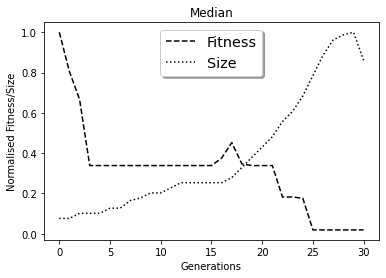

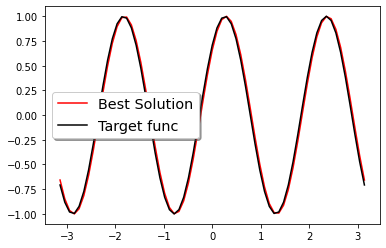

Best individual:
sin(sub(mul(add(protectedDiv(cos(mul(add(-1, -1), x)), protectedDiv(sub(-1, -1), x)), add(1, 1)), sub(x, sub(-1, protectedDiv(cos(mul(add(protectedDiv(neg(1), sin(cos(-1))), x), sin(mul(sub(mul(add(protectedDiv(x, protectedDiv(sub(-1, -1), x)), add(1, 1)), x), -1), x)))), protectedDiv(sub(-1, -1), add(protectedDiv(cos(mul(add(protectedDiv(neg(1), sin(add(cos(cos(-1)), add(1, 1)))), mul(-1, sub(protectedDiv(0, 1), 0))), -1)), protectedDiv(sub(-1, -1), x)), add(sub(add(0, x), protectedDiv(-1, x)), 1))))))), -1))


In [45]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 2

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	1.00924e+28	0  	2.39568e+30	1.47824	0.493627	500   	1.43221e+29	3.676	0  	7  	3  	2  	500   	1.51229
1  	397   	1.75993    	1  	61.363     	0.984968	0.493627	397   	3.76397    	4.05 	1  	13 	4  	1  	397   	2.02176
2  	417   	1.64339    	2  	52.0428    	0.958543	0.49232 	417   	3.05811    	4.622	2  	15 	4  	1  	417   	2.23676
3  	396   	4.46004e+28	3  	2.02486e+31	0.5     	0.49232 	396   	9.09087e+29	5.166	3  	17 	5  	1  	396   	2.79114
4  	402   	8.56326e+28	4  	2.8455e+31 	0.5     	0.49232 	402   	1.33116e+30	5.568	4  	20 	5  	1  	402   	3.07203
5  	392   	1.17923e+29

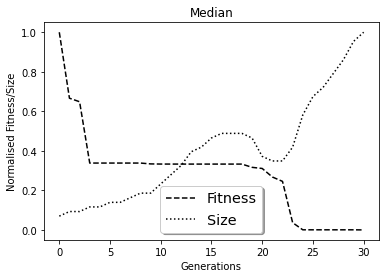

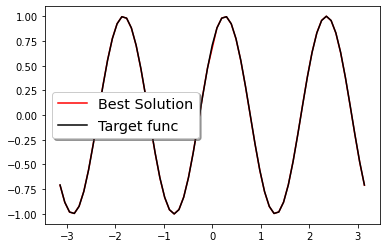

Best individual:
sin(add(add(sin(sin(protectedDiv(add(x, x), mul(protectedDiv(mul(cos(-1), protectedDiv(x, add(add(sub(x, x), add(x, x)), protectedDiv(x, mul(x, x))))), 0), add(mul(0, -1), x))))), x), add(x, x)))


In [46]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 3

   	      	                                      fitness                                      	                         size                         
   	      	-----------------------------------------------------------------------------------	------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std   
0  	500   	1.64129e+28	0  	8.20644e+30	1.47824	0.493627	500   	3.66636e+29	3.448	0  	7  	3  	2  	500   	1.4857
1  	390   	4.46004e+28	1  	2.23002e+31	0.985935	0.493627	390   	9.96297e+29	3.642	1  	12 	3  	1  	390   	1.95188
2  	374   	2.20797    	2  	353.542    	0.711322	0.493627	374   	16.0402    	4.164	2  	13 	4  	1  	374   	2.04771
3  	402   	1.67506e+28	3  	5.81076e+30	0.5     	0.493627	402   	2.76032e+29	4.62 	3  	15 	4  	1  	402   	2.35194
4  	389   	5.69101e+28	4  	2.8455e+31 	0.5     	0.493627	389   	1.27127e+30	5.244	4  	15 	5  	1  	389   	2.70416
5  	395   	2.91707    	5  

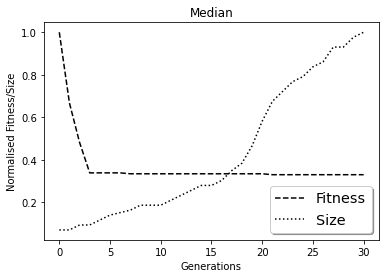

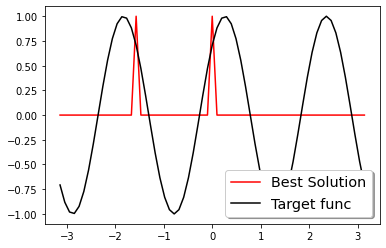

Best individual:
protectedDiv(mul(0, neg(mul(neg(neg(sin(add(-1, x)))), sin(-1)))), mul(sub(add(-1, sub(mul(x, 1), neg(mul(-1, x)))), sin(x)), x))


In [47]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 4

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	6.56515e+28	0  	3.28258e+31	1.47824	0.493627	500   	1.46654e+30	3.606	0  	7  	3  	2  	500   	1.51088
1  	387   	1.60482    	1  	24.6702    	0.989121	0.492585	387   	1.94568    	3.682	1  	13 	3  	1  	387   	1.85496
2  	384   	1.16215e+28	2  	5.81076e+30	0.803682	0.5     	384   	2.59605e+29	4.352	2  	15 	4  	1  	384   	2.25479
3  	390   	1.48088    	3  	25.6289    	0.5     	0.493627	390   	2.00138    	4.782	3  	15 	4  	1  	390   	2.46627
4  	387   	2.53437    	4  	214.455    	0.5     	0.457038	387   	14.3464    	4.98 	4  	16 	4  	1  	387   	2.75601
5  	393   	1.56233    

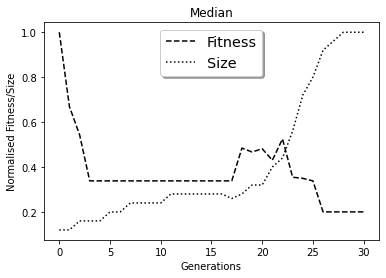

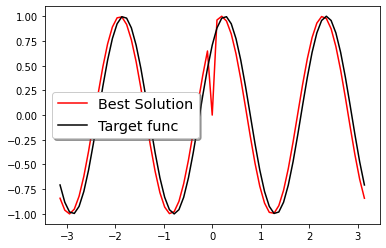

Best individual:
sin(mul(sub(sub(1, protectedDiv(sub(-1, x), x)), -1), x))


In [48]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 5

   	      	                            fitness                            	                          size                         
   	      	---------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg    	gen	max    	mdn    	min     	nevals	std    	avg  	gen	max	mdn	min	nevals	std    
0  	500   	3.57816	0  	353.542	1.47824	0.493627	500   	16.2713	3.606	0  	7  	3  	2  	500   	1.57695
1  	396   	4.87036e+28	1  	2.23002e+31	0.992308	0.493627	396   	1.00032e+30	3.658	1  	12 	3  	1  	396   	2.0428 
2  	379   	4.23192e+28	2  	2.02486e+31	0.803682	0.493627	379   	9.05472e+29	4.288	2  	13 	4  	1  	379   	2.23899
3  	390   	4.60807e+29	3  	2.20094e+32	0.5     	0.493627	390   	9.83939e+30	5.022	3  	19 	4  	1  	390   	2.711  
4  	407   	1.88455e+29	4  	2.85967e+31	0.5     	0.493627	407   	1.6757e+30 	5.688	4  	19 	5  	1  	407   	2.99377
5  	394   	1.03489e+30	5  	2.20094e+32	0.5     	0.493627	394   	1.12007e+31	5.958	5  	

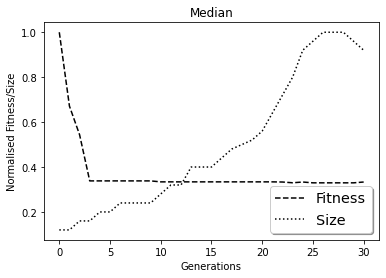

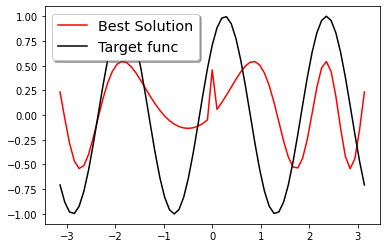

Best individual:
protectedDiv(sin(protectedDiv(add(x, 1), protectedDiv(mul(-1, -1), x))), sub(sin(1), -1))


In [49]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 6

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg 	gen	max	mdn	min	nevals	std    
0  	500   	4.46004e+28	0  	2.02486e+31	1.47824	0.493627	500   	9.09087e+29	3.53	0  	7  	3  	2  	500   	1.46734
1  	396   	1.67182    	1  	50.4678    	0.985935	0.499909	396   	2.97786    	3.74	1  	11 	3  	1  	396   	1.75511
2  	404   	1.70853    	2  	103.954    	0.803682	0.5     	404   	5.43353    	4.21	2  	11 	4  	1  	404   	1.90313
3  	387   	1.40236    	3  	24.6638    	0.5     	0.5     	387   	2.0133     	4.62	3  	13 	4  	1  	387   	2.23598
4  	397   	8.89458e+27	4  	2.39568e+30	0.5     	0.493627	397   	1.40775e+29	4.916	4  	15 	5  	1  	397   	2.56845
5  	397   	3.39263e+27	5  	

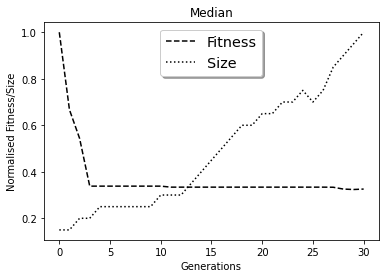

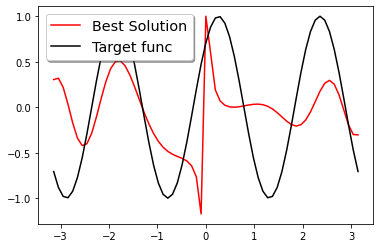

Best individual:
protectedDiv(mul(cos(protectedDiv(-1, 1)), mul(cos(sub(add(sin(-1), 1), mul(x, x))), add(sin(sub(-1, x)), 1))), x)


In [50]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 7

   	      	                                      fitness                                      	                         size                         
   	      	-----------------------------------------------------------------------------------	------------------------------------------------------
gen	nevals	avg        	gen	max       	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std   
0  	500   	1.22027e+29	0  	2.8455e+31	1.47824	0.493627	500   	1.80019e+30	3.556	0  	7  	3  	2  	500   	1.4446
1  	401   	4.10322e+27	1  	2.05161e+30	1.02945	0.493627	401   	9.1659e+28 	3.728	1  	11 	3  	1  	401   	1.8735
2  	390   	1.64129e+28	2  	8.20644e+30	0.958543	0.493627	390   	3.66636e+29	4.202	2  	15 	3  	1  	390   	2.13101
3  	371   	7.54753e+28	3  	1.947e+31  	0.5     	0.493627	371   	9.85682e+29	4.36 	3  	14 	3  	1  	371   	2.33204
4  	383   	7.91234e+28	4  	2.02486e+31	0.5     	0.493627	383   	1.04879e+30	4.66 	4  	16 	3  	1  	383   	2.59623
5  	393   	1.77207e+28	5  	8.2

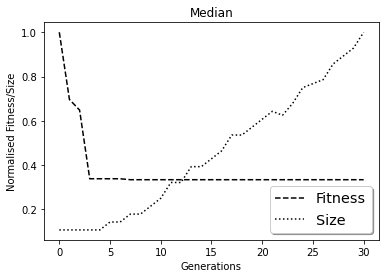

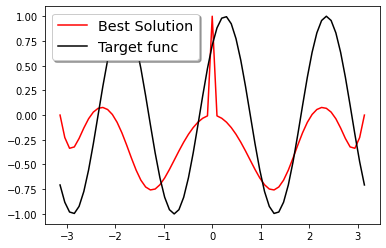

Best individual:
protectedDiv(mul(sin(mul(mul(sin(neg(protectedDiv(x, -1))), mul(mul(mul(1, x), sin(1)), x)), protectedDiv(cos(0), -1))), protectedDiv(1, 0)), x)


In [51]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 8

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	1.64129e+28	0  	8.20644e+30	1.47824	0.493627	500   	3.66636e+29	3.616	0  	7  	3  	2  	500   	1.54679
1  	425   	1.92912    	1  	84.4005    	0.992308	0.499909	425   	4.28494    	3.666	1  	13 	3  	1  	425   	1.94382
2  	401   	4.04972e+28	2  	2.02486e+31	0.803682	0.493627	401   	9.04638e+29	4.228	2  	13 	4  	1  	401   	2.21901
3  	418   	7.0086e+27 	3  	2.05161e+30	0.70132 	0.493627	418   	1.12204e+29	4.666	3  	13 	4  	1  	418   	2.27913
4  	408   	4.97032e+27	4  	2.05161e+30	0.5     	0.493627	408   	9.36453e+28	5.1  	4  	14 	5  	1  	408   	2.48877
5  	407   	5.52538e+29

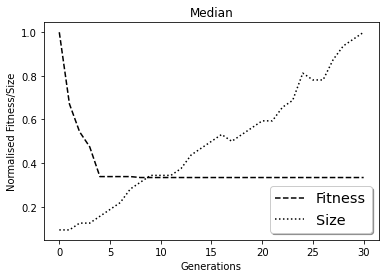

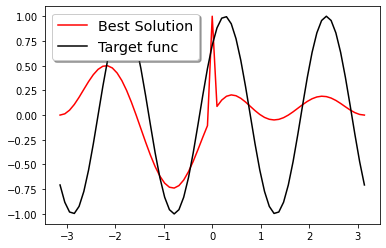

Best individual:
protectedDiv(mul(mul(mul(sin(sin(x)), mul(mul(sub(neg(protectedDiv(x, protectedDiv(-1, cos(mul(mul(mul(protectedDiv(0, 0), 0), cos(mul(0, protectedDiv(0, sin(sin(x)))))), add(-1, -1)))))), 1), neg(1)), 1)), sin(x)), cos(neg(x))), x)


In [52]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 9

   	      	                                  fitness                                  	                          size                         
   	      	---------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min	nevals	std        	avg 	gen	max	mdn	min	nevals	std    
0  	500   	2.53075e+28	0  	8.20644e+30	1.47824	0.5	500   	3.92362e+29	3.66	0  	7  	3  	2  	500   	1.53114
1  	390   	4.1695e+28 	1  	2.02486e+31	0.803682	0.5	390   	9.0498e+29 	3.97	1  	11 	3  	1  	390   	2.00327
2  	408   	4.10322e+27	2  	2.05161e+30	0.5     	0.493627	408   	9.1659e+28 	4.562	2  	13 	4  	1  	408   	2.30351
3  	403   	4.34026e+28	3  	2.02486e+31	0.5     	0.492585	403   	9.06834e+29	5.024	3  	16 	4  	1  	403   	2.58291
4  	405   	2.14786e+28	4  	8.20644e+30	0.5     	0.492585	405   	3.82818e+29	5.354	4  	14 	5  	1  	405   	2.81082
5  	400   	3.31939e+28	5  	1.43375e+31	0.5     	0.487255

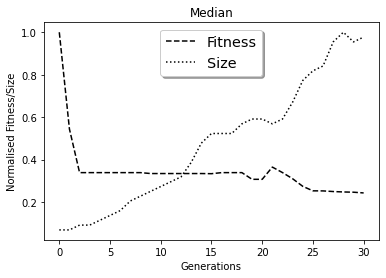

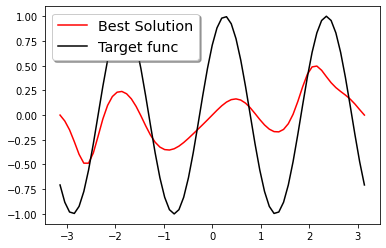

Best individual:
protectedDiv(sin(mul(protectedDiv(cos(mul(sin(x), mul(cos(sub(mul(-1, 1), mul(-1, x))), sub(-1, protectedDiv(mul(1, -1), 0))))), mul(1, -1)), x)), sub(-1, protectedDiv(cos(mul(mul(cos(-1), x), mul(x, x))), sin(mul(mul(mul(protectedDiv(cos(1), mul(1, -1)), x), -1), 0)))))


In [53]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 10

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	4.04972e+28	0  	2.02486e+31	1.47824	0.493627	500   	9.04638e+29	3.612	0  	7  	3  	2  	500   	1.53018
1  	390   	4.46004e+28	1  	2.23002e+31	0.985043	0.458834	390   	9.96297e+29	3.922	1  	13 	3  	1  	390   	1.94626
2  	396   	1.67151    	2  	21.7383    	0.803682	0.492585	396   	2.41378    	4.218	2  	13 	4  	1  	396   	2.20873
3  	398   	1.61989e+29	3  	8.09943e+31	0.5     	0.492585	398   	3.61855e+30	4.778	3  	16 	4  	1  	398   	2.60552
4  	392   	2.23399    	4  	57.9529    	0.5     	0.463982	392   	5.06894    	5.928	4  	17 	6  	1  	392   	2.93919
5  	409   	2.09318e+28

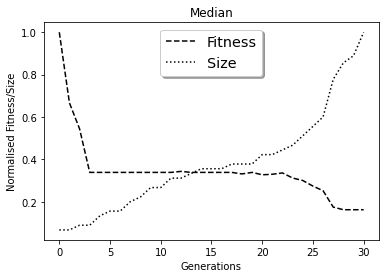

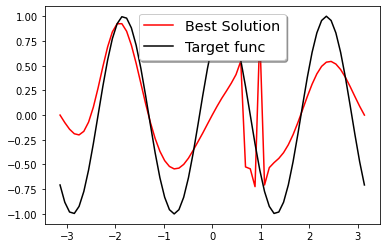

Best individual:
mul(sin(protectedDiv(cos(add(sub(x, 1), sin(sin(1)))), sin(protectedDiv(1, sub(cos(mul(cos(mul(cos(x), mul(cos(x), protectedDiv(-1, x)))), sin(x))), x))))), mul(1, sin(x)))


In [54]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

<a name="problem2"></a>

### Problem 2: Bell-Shaped Curve 

In [55]:
def N():
    mu1 = -1.7
    mu2 = 1.3
    sigma1 = 0.5
    sigma2 = 0.8
    measurements = lambda x: (((math.e)**(-(((x-mu1)/sigma1)**2)/2))/(sigma1*math.sqrt(2*math.pi)) + 7) * ((math.e)**(-(((x-mu2)/sigma2)**2)/2))/(sigma2*math.sqrt(2*math.pi))
    return measurements

In [56]:
measurement = N()

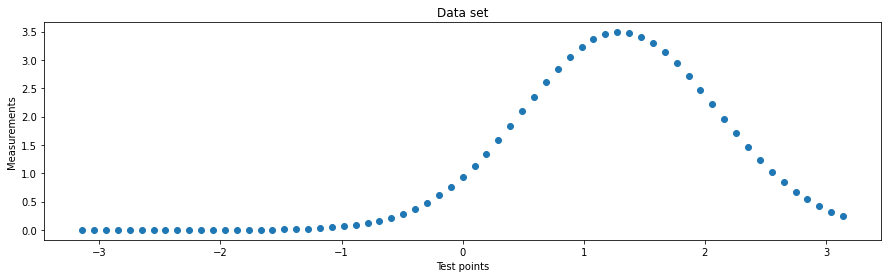

In [57]:
target = data_set()

<a name="p2s1"></a>

#### Population: 2000, Tournament: 2 

In [58]:
no_population = 2000   # population size
no_tournaments = 2     # tournament size

##### Run 1

   	      	                                     fitness                                      	                         size                         
   	      	----------------------------------------------------------------------------------	------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std       	avg   	gen	max	mdn	min	nevals	std   
0  	2000  	2.34598e+28	0  	2.23002e+31	2.70667	0.483608	2000  	5.6909e+29	3.6025	0  	7  	3  	2  	2000  	1.5197
1  	1596  	2.52058e+28	1  	2.81113e+31	1.82346	0.483608	1596  	7.75626e+29	3.6785	1  	12 	3  	1  	1596  	1.88285
2  	1544  	2.44856e+28	2  	2.02486e+31	1.65855	0.483608	1544  	5.56445e+29	3.934 	2  	15 	3  	1  	1544  	2.06921
3  	1538  	9.23225e+27	3  	8.20644e+30	1.57693	0.477846	1538  	2.10025e+29	4.3825	3  	15 	4  	1  	1538  	2.34354
4  	1581  	5.23245e+28	4  	2.02486e+31	1.53172	0.275234	1581  	7.74593e+29	4.806 	4  	18 	5  	1  	1581  	2.51622
5  	1606  	3.35841e+28	5  	2

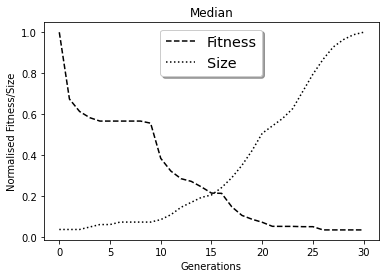

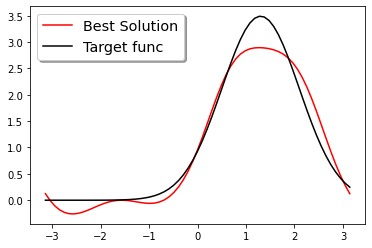

Best individual:
add(sub(mul(cos(cos(x)), 1), cos(sub(protectedDiv(sub(1, cos(sub(1, sub(-1, x)))), 0), sub(-1, x)))), sin(mul(sub(1, cos(sub(protectedDiv(sin(x), 0), sub(-1, x)))), sin(x))))


In [59]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 2

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	1.95286e+28	0  	2.23002e+31	2.70667	0.483608	2000  	5.39559e+29	3.6305	0  	7  	3  	2  	2000  	1.52282
1  	1622  	1.33737e+28	1  	2.23002e+31	1.82346	0.483608	1622  	5.03433e+29	3.6475	1  	11 	3  	1  	1622  	1.83119
2  	1592  	5.67826e+28	2  	8.92008e+31	1.7014 	0.483608	1592  	2.01262e+30	3.97  	2  	17 	3  	1  	1592  	2.18337
3  	1578  	2.00446e+28	3  	8.20644e+30	1.55062	0.483608	1578  	3.56332e+29	4.319 	3  	14 	4  	1  	1578  	2.43007
4  	1576  	1.46309e+28	4  	8.20644e+30	1.53172	0.483608	1576  	2.55106e+29	4.7205	4  	19 	4  	1  	1576  	2.81822
5  	1588  	3.31887e+

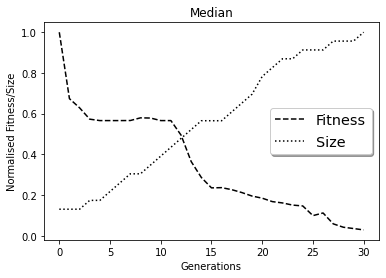

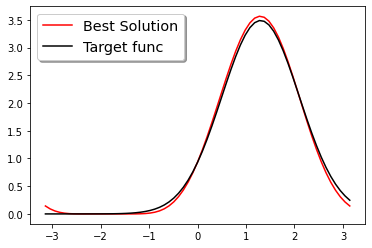

Best individual:
mul(sub(cos(add(mul(mul(1, sin(sin(1))), 1), mul(mul(-1, -1), neg(x)))), -1), add(cos(cos(x)), sin(x)))


In [60]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 3

   	      	                                  fitness                                  	                          size                         
   	      	---------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max       	mdn    	min    	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	2000  	6.39569e+28	0  	2.8455e+31	2.76944	1.52596	2000  	1.20681e+30	3.581	0  	7  	3  	2  	2000  	1.49547
1  	1559  	8.03441e+27	1  	8.20644e+30	1.82346	0.483608	1559  	2.29337e+29	3.622	1  	12 	3  	1  	1559  	1.83552
2  	1593  	1.52533e+28	2  	2.02486e+31	1.72912	0.483608	1593  	4.90456e+29	3.773	2  	15 	3  	1  	1593  	2.06796
3  	1595  	3.9626e+28 	3  	2.8455e+31 	1.53172	0.483608	1595  	8.69956e+29	3.9735	3  	18 	3  	1  	1595  	2.44679
4  	1562  	4.1067e+28 	4  	2.15102e+31	1.53172	0.475286	1562  	6.48281e+29	4.1935	4  	19 	3  	1  	1562  	2.76858
5  	1618  	6.7047e+28 	5  	3.28258e+31	1.531

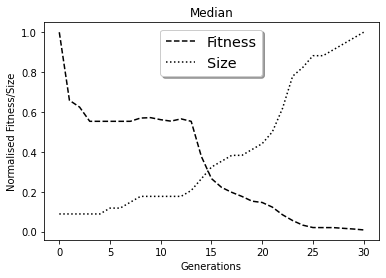

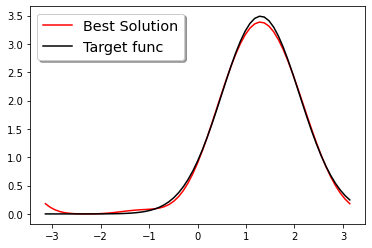

Best individual:
mul(add(cos(cos(x)), sin(sin(x))), add(cos(sub(sin(1), x)), 1))


In [61]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 4

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	2000  	2.73909e+28	0  	2.02486e+31	2.70667	0.483608	2000  	5.71281e+29	3.529	0  	7  	3  	2  	2000  	1.46702
1  	1563  	4.13573e+28	1  	2.8455e+31 	1.82346	0.483608	1563  	9.2308e+29 	3.5865	1  	12 	3  	1  	1563  	1.82497
2  	1592  	2.40317e+28	2  	2.02486e+31	1.7014 	0.483608	1592  	5.3222e+29 	3.6095	2  	14 	3  	1  	1592  	1.9652 
3  	1564  	9.35715e+28	3  	8.09943e+31	1.53172	0.482933	1564  	1.98127e+30	3.941 	3  	15 	3  	1  	1564  	2.23618
4  	1603  	5.45139e+28	4  	3.28258e+31	1.53172	0.483608	1603  	8.901e+29  	4.278 	4  	17 	4  	1  	1603  	2.49012
5  	1605  	7.04832e+28

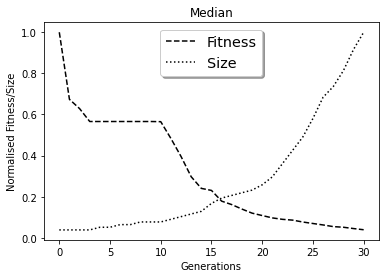

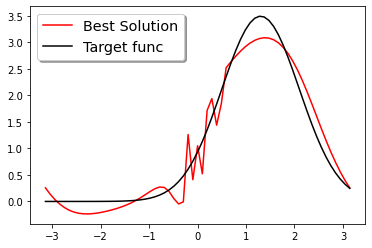

Best individual:
add(add(sin(sin(x)), sin(sin(add(sin(x), protectedDiv(sin(add(add(x, sin(sin(cos(protectedDiv(sub(0, -1), x))))), cos(protectedDiv(protectedDiv(-1, 0), neg(add(x, add(sin(x), sin(sin(sin(add(sin(x), add(protectedDiv(protectedDiv(-1, 0), protectedDiv(-1, 1)), protectedDiv(sin(add(x, cos(protectedDiv(1, neg(sub(x, 0)))))), cos(protectedDiv(sin(x), x))))))))))))))), 1))))), protectedDiv(sin(x), sin(sin(sin(sin(x))))))


In [62]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 5

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg 	gen	max	mdn	min	nevals	std    
0  	2000  	3.54636e+28	0  	2.02486e+31	2.70667	0.483608	2000  	7.25706e+29	3.56	0  	7  	3  	2  	2000  	1.51076
1  	1595  	1.56567e+28	1  	2.02486e+31	1.82346	0.475286	1595  	4.90648e+29	3.597	1  	13 	3  	1  	1595  	1.80016
2  	1620  	2.49571e+28	2  	2.02486e+31	1.82346	0.475286	1620  	5.57272e+29	3.904	2  	18 	3  	1  	1620  	2.11466
3  	1576  	1.31634e+28	3  	8.20644e+30	1.57989	0.475286	1576  	2.97093e+29	4.3285	3  	20 	4  	1  	1576  	2.55198
4  	1584  	6.89788e+28	4  	2.8455e+31 	1.53172	0.420111	1584  	1.0985e+30 	4.6045	4  	19 	4  	1  	1584  	2.64539
5  	1600  	1.40109e+28	5  

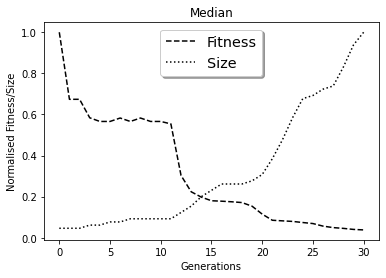

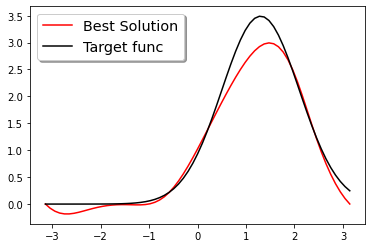

Best individual:
add(sub(sin(x), -1), cos(sub(add(cos(cos(sin(cos(cos(add(x, -1)))))), cos(sub(sub(mul(0, x), x), mul(cos(cos(sin(cos(sub(sub(mul(0, x), x), mul(1, -1)))))), -1)))), x)))


In [63]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 6

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	3.85793e+28	0  	2.23002e+31	2.76725	0.483608	2000  	8.34957e+29	3.5905	0  	7  	3  	2  	2000  	1.54266
1  	1617  	1.12232e+29	1  	1.99846e+32	1.85249	0.483608	1617  	4.47856e+30	3.5085	1  	12 	3  	1  	1617  	1.77142
2  	1537  	3.37178e+28	2  	2.02486e+31	1.7014 	0.483608	1537  	6.15259e+29	3.78  	2  	16 	3  	1  	1537  	2.02228
3  	1541  	9.75029e+28	3  	3.28258e+31	1.53172	0.483608	1541  	1.49164e+30	4.023 	3  	16 	3  	1  	1541  	2.30791
4  	1590  	3.57694e+28	4  	2.02486e+31	1.53172	0.420111	1590  	6.38643e+29	4.384 	4  	18 	4  	1  	1590  	2.64548
5  	1561  	3.07742e+

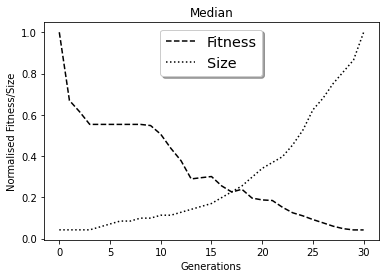

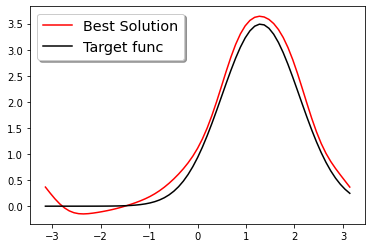

Best individual:
add(mul(add(mul(add(mul(sin(neg(-1)), sin(protectedDiv(mul(add(add(sin(sin(cos(x))), -1), mul(sub(sin(x), -1), sin(x))), 1), 1))), mul(1, 1)), sin(protectedDiv(mul(add(mul(sin(neg(sin(mul(cos(cos(-1)), -1)))), sin(neg(add(1, 0)))), mul(sub(sin(neg(neg(add(1, 1)))), -1), sin(x))), 1), 1))), mul(1, 1)), 1), cos(add(mul(0, sin(mul(add(mul(-1, -1), sub(1, 1)), neg(x)))), sub(x, 1))))


In [64]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 7

   	      	                                      fitness                                      	                         size                         
   	      	-----------------------------------------------------------------------------------	------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std   
0  	2000  	2.64034e+28	0  	2.02486e+31	2.70667	0.483608	2000  	6.68723e+29	3.5565	0  	7  	3  	2  	2000  	1.5046
1  	1581  	2.44856e+28	1  	2.02486e+31	1.82346	0.483608	1581  	5.56445e+29	3.612 	1  	15 	3  	1  	1581  	1.8367
2  	1574  	2.38866e+28	2  	8.20644e+30	1.64236	0.483608	1574  	3.84918e+29	3.82  	2  	17 	3  	1  	1574  	2.07499
3  	1586  	4.89608e+28	3  	2.8455e+31 	1.53172	0.423258	1586  	9.37842e+29	4.138 	3  	17 	3  	1  	1586  	2.42919
4  	1612  	6.11172e+28	4  	2.8455e+31 	1.53172	0.423258	1612  	1.06093e+30	4.451 	4  	16 	4  	1  	1612  	2.65285
5  	1557  	3.12158e+28	5 

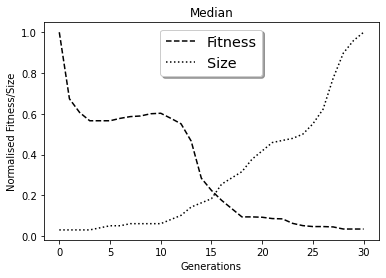

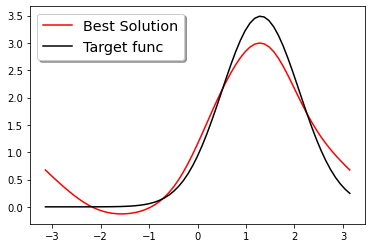

Best individual:
mul(sub(sub(cos(sub(sub(1, x), sin(neg(cos(neg(neg(sub(mul(x, -1), 0)))))))), -1), -1), cos(sub(sin(1), sin(sin(x)))))


In [65]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 8

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	4.34026e+28	0  	2.02486e+31	2.76944	0.536473	2000  	9.13788e+29	3.6595	0  	7  	3  	2  	2000  	1.54064
1  	1588  	1.93565e+28	1  	2.02486e+31	1.82346	0.483608	1588  	5.23525e+29	3.663 	1  	12 	3  	1  	1588  	1.83778
2  	1587  	3.46481e+28	2  	2.23002e+31	1.7014 	0.483608	1587  	8.15189e+29	3.822 	2  	14 	3  	1  	1587  	2.10459
3  	1601  	2.20134e+28	3  	8.20644e+30	1.57693	0.398904	1601  	3.62978e+29	4.1725	3  	14 	3  	1  	1601  	2.29929
4  	1582  	3.80331e+28	4  	2.23002e+31	1.53172	0.398904	1582  	6.54434e+29	4.5545	4  	15 	4  	1  	1582  	2.52884
5  	1574  	3.27959e+

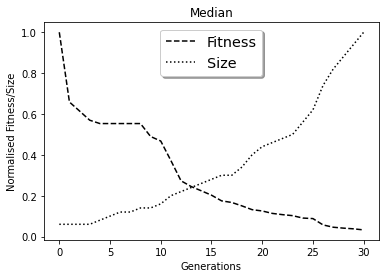

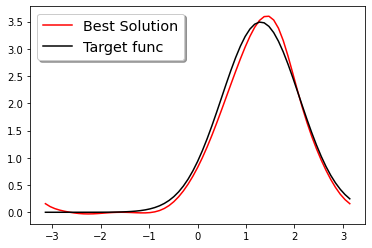

Best individual:
protectedDiv(add(sin(x), 1), protectedDiv(cos(sub(x, x)), add(sin(mul(x, 1)), sin(sin(add(sin(mul(sin(add(add(1, cos(1)), x)), add(sin(sin(sin(x))), 1))), 1))))))


In [66]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 9

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg       	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	6.3925e+28	0  	3.28258e+31	2.70667	0.483608	2000  	1.14093e+30	3.5645	0  	7  	3  	2  	2000  	1.50859
1  	1575  	7.98984e+27	1  	8.20644e+30	1.91817	0.483608	1575  	2.10034e+29	3.576 	1  	13 	3  	1  	1575  	1.78752
2  	1601  	2.34598e+28	2  	2.02486e+31	1.78379	0.483608	1601  	5.54595e+29	3.7755	2  	15 	3  	1  	1601  	2.01174
3  	1588  	3.87131e+28	3  	2.02486e+31	1.57693	0.483608	1588  	7.22601e+29	3.976 	3  	15 	3  	1  	1588  	2.31806
4  	1582  	1.25434e+29	4  	1.99846e+32	1.53172	0.420111	1582  	4.50175e+30	4.3395	4  	18 	4  	1  	1582  	2.68165
5  	1582  	7.26029e+28

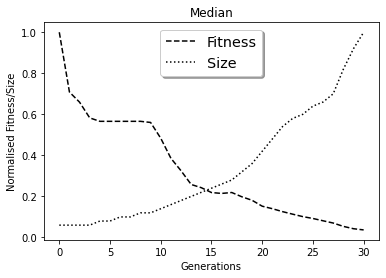

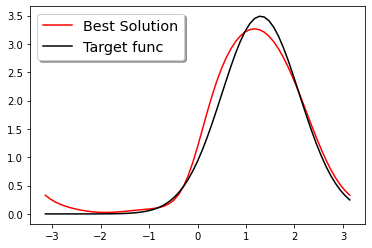

Best individual:
add(add(sin(sin(add(x, sin(sin(sin(sin(x))))))), add(mul(mul(cos(1), sin(x)), sin(x)), 1)), sin(sub(cos(protectedDiv(sin(sin(1)), cos(protectedDiv(sin(sin(x)), x)))), neg(x))))


In [67]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 10

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg	gen	max	mdn	min	nevals	std    
0  	2000  	1.30257e+29	0  	1.99846e+32	2.70667	0.775352	2000  	4.52334e+30	3.6	0  	7  	3  	2  	2000  	1.52774
1  	1615  	3.85793e+28	1  	2.23002e+31	2.09258	0.483608	1615  	8.59474e+29	3.7255	1  	12 	3  	1  	1615  	1.87647
2  	1585  	2.55496e+28	2  	2.02486e+31	1.72912	0.483608	1585  	6.67754e+29	3.9835	2  	13 	3  	1  	1585  	2.21861
3  	1592  	1.14067e+29	3  	1.99846e+32	1.58458	0.483608	1592  	4.4764e+30 	4.309 	3  	16 	4  	1  	1592  	2.54254
4  	1567  	2.96449e+28	4  	1.97963e+31	1.53172	0.39637 	1567  	5.79831e+29	4.6865	4  	16 	4  	1  	1567  	2.81251
5  	1541  	5.08023e+28	5  

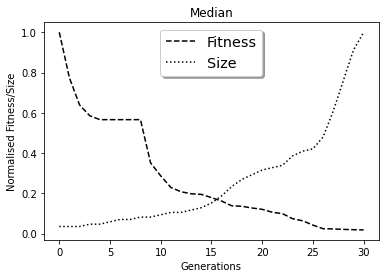

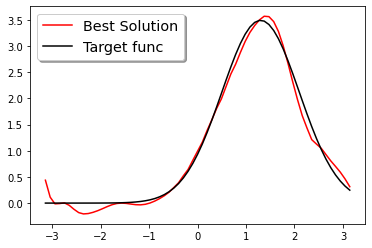

Best individual:
protectedDiv(add(sin(x), cos(protectedDiv(cos(x), cos(sin(sin(sub(protectedDiv(cos(x), cos(protectedDiv(sin(sin(sub(neg(cos(-1)), protectedDiv(add(sin(x), 1), sub(protectedDiv(sub(protectedDiv(x, mul(x, 1)), cos(x)), sub(x, sub(-1, protectedDiv(cos(x), cos(sin(1)))))), protectedDiv(cos(0), mul(cos(protectedDiv(cos(x), mul(x, x))), x))))))), add(1, sin(add(1, -1)))))), protectedDiv(1, sub(x, x))))))))), cos(mul(cos(mul(sub(mul(x, 1), protectedDiv(sin(x), cos(cos(neg(sin(1)))))), 1)), 1)))


In [68]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

<a name="p2s2"></a>

#### Population: 2000, Tournament: 5 

In [69]:
no_population = 2000   # population size
no_tournaments = 5     # tournament size

##### Run 1

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	2000  	3.97389e+28	0  	3.28258e+31	2.70667	0.483608	2000  	9.97521e+29	3.577	0  	7  	3  	2  	2000  	1.52515
1  	1604  	1.21759e+28	1  	2.02486e+31	1.82346	0.483608	1604  	4.57235e+29	3.531	1  	13 	3  	1  	1604  	1.80805
2  	1578  	1.96893e+27	2  	2.05161e+30	1.78379	0.475286	1578  	5.70071e+28	3.805	2  	14 	3  	1  	1578  	2.07894
3  	1529  	5.74205e+28	3  	3.28258e+31	1.59506	0.483608	1529  	1.04428e+30	4.1085	3  	15 	4  	1  	1529  	2.29472
4  	1582  	5.69358e+28	4  	2.02486e+31	1.53172	0.420111	1582  	9.62396e+29	4.4345	4  	16 	4  	1  	1582  	2.53411
5  	1599  	7.73737e+28	5

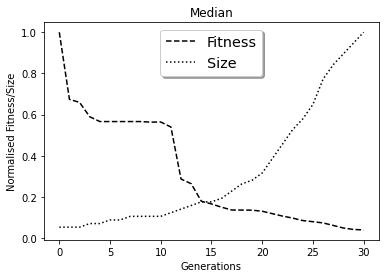

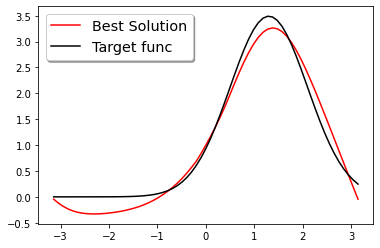

Best individual:
add(cos(mul(sin(cos(-1)), sub(protectedDiv(sin(x), cos(cos(cos(protectedDiv(add(protectedDiv(sin(x), cos(cos(cos(cos(protectedDiv(sin(x), cos(cos(neg(mul(x, -1)))))))))), cos(1)), x))))), x))), protectedDiv(protectedDiv(sin(x), cos(cos(mul(cos(sin(1)), add(x, -1))))), cos(cos(cos(neg(add(cos(cos(protectedDiv(add(x, cos(1)), x))), add(protectedDiv(mul(-1, 1), cos(cos(cos(protectedDiv(0, protectedDiv(protectedDiv(cos(protectedDiv(neg(1), sin(1))), cos(cos(cos(protectedDiv(x, 1))))), x)))))), cos(cos(sin(x)))))))))))


In [70]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 2

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max       	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	5.38326e+28	0  	2.8455e+31	2.75196	0.483608	2000  	1.04231e+30	3.5615	0  	7  	3  	2  	2000  	1.47011
1  	1567  	1.73753e+28	1  	8.20644e+30	1.82346	0.483608	1567  	3.48653e+29	3.6515	1  	13 	3  	1  	1567  	1.85985
2  	1560  	4.98251e+28	2  	2.81113e+31	1.72912	0.475286	1560  	8.95424e+29	3.869 	2  	15 	3  	1  	1560  	2.12764
3  	1599  	3.66232e+28	3  	2.02486e+31	1.53172	0.475286	1599  	6.28667e+29	4.005 	3  	15 	3  	1  	1599  	2.35584
4  	1561  	9.05004e+28	4  	8.09943e+31	1.53172	0.475286	1561  	1.93925e+30	4.231 	4  	18 	4  	1  	1561  	2.56274
5  	1597  	5.20498e+28

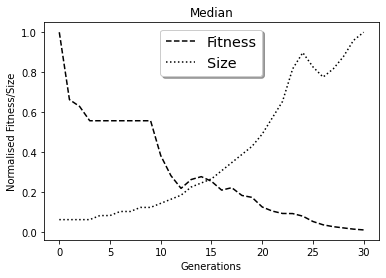

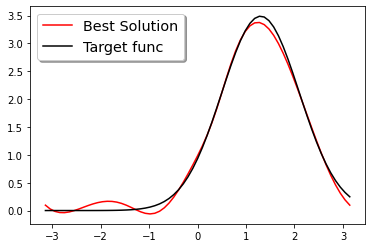

Best individual:
add(cos(cos(sin(sin(x)))), add(sin(x), mul(cos(mul(-1, add(sin(-1), x))), add(sin(x), protectedDiv(cos(cos(cos(add(add(sin(x), mul(cos(cos(sub(-1, sin(protectedDiv(1, 0))))), 1)), x)))), cos(0))))))


In [71]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 3

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	6.10069e+28	0  	8.09943e+31	2.70667	0.483608	2000  	1.89184e+30	3.5905	0  	7  	3  	2  	2000  	1.50526
1  	1580  	7.18064e+27	1  	8.20644e+30	1.82346	0.483608	1580  	1.99837e+29	3.539 	1  	12 	3  	1  	1580  	1.79708
2  	1553  	3.31571e+28	2  	2.23002e+31	1.65855	0.483608	1553  	6.37777e+29	3.7985	2  	13 	3  	1  	1553  	2.00322
3  	1553  	4.95028e+28	3  	2.02486e+31	1.57693	0.483608	1553  	8.23565e+29	4.0405	3  	15 	3  	1  	1553  	2.24652
4  	1607  	1.34795e+28	4  	8.20644e+30	1.53172	0.483608	1607  	2.26771e+29	4.214 	4  	16 	4  	1  	1607  	2.56148
5  	1571  	5.67742e+

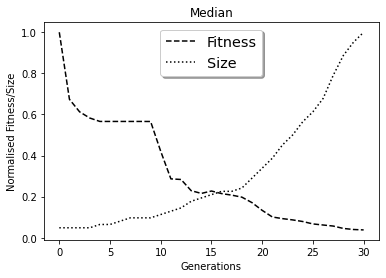

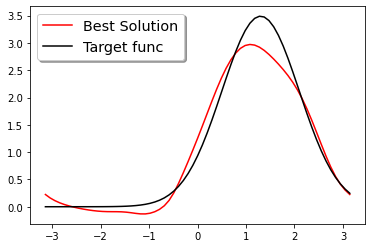

Best individual:
add(add(sin(add(cos(sin(add(0, sin(add(sin(sin(add(x, sin(1)))), cos(sin(sub(cos(sin(add(protectedDiv(0, sin(sin(add(0, protectedDiv(x, mul(mul(-1, x), add(cos(mul(cos(add(sin(x), -1)), neg(sub(add(0, -1), sin(sin(x)))))), x))))))), sin(sin(x))))), protectedDiv(x, -1))))))))), x)), cos(0)), sin(sub(x, cos(neg(sub(add(0, -1), sin(sub(x, cos(protectedDiv(1, cos(sin(add(0, add(1, sin(sub(cos(sin(add(protectedDiv(0, cos(add(0, sin(sin(x))))), sin(sin(x))))), protectedDiv(x, -1)))))))))))))))))


In [72]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 4

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	2000  	1.52597e+28	0  	8.20644e+30	2.70667	0.483608	2000  	3.26826e+29	3.602	0  	7  	3  	2  	2000  	1.52728
1  	1531  	7.52471e+27	1  	8.20644e+30	1.82346	0.483608	1531  	2.03617e+29	3.6795	1  	12 	3  	1  	1531  	1.83651
2  	1594  	4.69195e+28	2  	2.8455e+31 	1.81604	0.475286	1594  	8.833e+29  	4.0385	2  	12 	3  	1  	1594  	2.15546
3  	1614  	9.7541e+28 	3  	8.09943e+31	1.53425	0.475286	1614  	2.06721e+30	4.2685	3  	15 	4  	1  	1614  	2.38   
4  	1582  	1.46127e+29	4  	1.99846e+32	1.53172	0.475286	1582  	4.54947e+30	4.564 	4  	16 	4  	1  	1582  	2.66475
5  	1577  	5.28928e+28

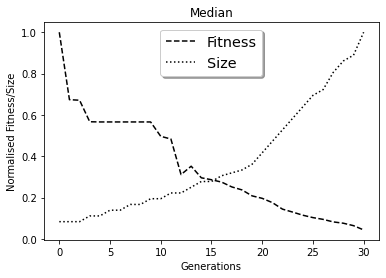

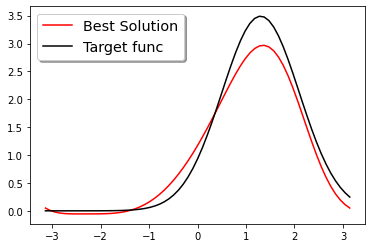

Best individual:
add(cos(sub(sub(x, cos(neg(-1))), cos(sub(x, cos(protectedDiv(cos(sin(sub(add(cos(x), sin(1)), 1))), sub(-1, -1))))))), sub(sin(x), -1))


In [73]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 5

   	      	                                     fitness                                      	                          size                         
   	      	----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max       	mdn    	min     	nevals	std       	avg  	gen	max	mdn	min	nevals	std    
0  	2000  	5.05724e+28	0  	2.8455e+31	2.70667	0.483608	2000  	8.8721e+29	3.588	0  	7  	3  	2  	2000  	1.50607
1  	1588  	1.82925e+28	1  	8.20644e+30	1.82346	0.483608	1588  	3.51966e+29	3.5535	1  	11 	3  	1  	1588  	1.76356
2  	1590  	2.80281e+28	2  	2.8455e+31 	1.7014 	0.483608	1590  	6.86052e+29	3.6915	2  	13 	3  	1  	1590  	1.95891
3  	1623  	5.20549e+28	3  	3.28258e+31	1.57693	0.483608	1623  	9.67444e+29	3.8895	3  	15 	3  	1  	1623  	2.20597
4  	1552  	6.9978e+28 	4  	2.8455e+31 	1.53172	0.477846	1552  	1.2755e+30 	4.1335	4  	22 	4  	1  	1552  	2.57715
5  	1588  	9.63757e+28	5  	3

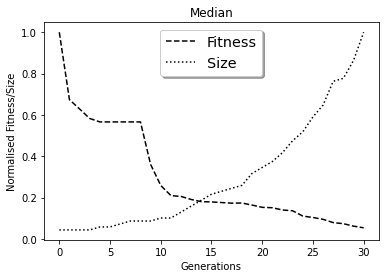

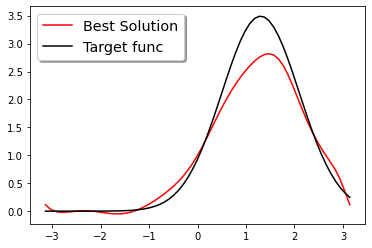

Best individual:
add(protectedDiv(sin(x), cos(sin(neg(mul(cos(protectedDiv(cos(neg(1)), protectedDiv(sin(neg(1)), neg(x)))), mul(sub(x, -1), -1)))))), cos(mul(x, mul(mul(mul(cos(x), cos(cos(1))), cos(protectedDiv(sub(-1, -1), mul(-1, x)))), cos(-1)))))


In [74]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 6

   	      	                                      fitness                                      	                         size                         
   	      	-----------------------------------------------------------------------------------	------------------------------------------------------
gen	nevals	avg        	gen	max       	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std   
0  	2000  	2.64034e+28	0  	2.8455e+31	2.70667	0.483608	2000  	7.83172e+29	3.587	0  	7  	3  	2  	2000  	1.5154
1  	1570  	5.70214e+28	1  	3.28258e+31	1.82346	0.483608	1570  	1.15336e+30	3.6405	1  	12 	3  	1  	1570  	1.86742
2  	1594  	2.94426e+28	2  	2.02486e+31	1.82346	0.483608	1594  	5.74852e+29	3.8485	2  	14 	3  	1  	1594  	2.07378
3  	1580  	4.23872e+28	3  	2.8455e+31 	1.58458	0.483608	1580  	8.46386e+29	3.948 	3  	16 	3  	1  	1580  	2.25506
4  	1629  	5.02784e+28	4  	2.81113e+31	1.53172	0.483608	1629  	8.82372e+29	4.315 	4  	19 	4  	1  	1629  	2.64287
5  	1588  	7.88604e+28	5  	8

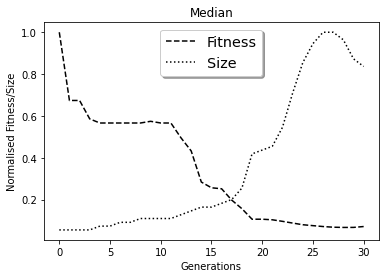

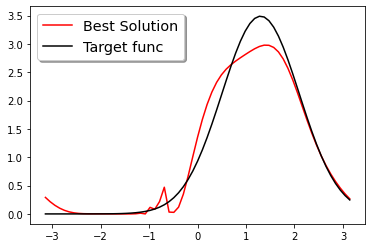

Best individual:
add(sin(x), sub(sin(mul(sub(sin(x), -1), sin(add(cos(protectedDiv(-1, neg(sub(sin(mul(1, -1)), x)))), x)))), -1))


In [75]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 7

   	      	                                      fitness                                      	                         size                         
   	      	-----------------------------------------------------------------------------------	------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std   
0  	2000  	3.99383e+28	0  	3.28258e+31	2.70667	0.483608	2000  	1.06137e+30	3.6195	0  	7  	3  	2  	2000  	1.5319
1  	1573  	1.88155e+28	1  	3.28258e+31	1.82346	0.483608	1573  	7.36795e+29	3.687 	1  	15 	3  	1  	1573  	1.84175
2  	1571  	3.66615e+28	2  	2.23002e+31	1.65855	0.482139	1571  	7.47509e+29	3.8825	2  	16 	3  	1  	1571  	2.05102
3  	1563  	9.55849e+28	3  	3.28258e+31	1.57693	0.475286	1563  	1.3935e+30 	4.0845	3  	17 	3  	1  	1563  	2.29899
4  	1571  	8.75185e+28	4  	2.8455e+31 	1.53172	0.483608	1571  	1.17678e+30	4.594 	4  	19 	4  	1  	1571  	2.65126
5  	1603  	9.46693e+28	5

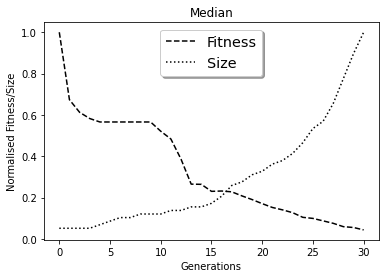

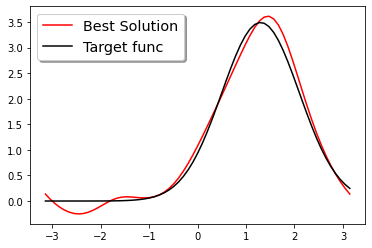

Best individual:
add(sin(x), protectedDiv(add(cos(add(cos(sub(sin(add(cos(sin(add(cos(add(cos(sin(neg(cos(-1)))), x)), cos(cos(sin(x)))))), x)), -1)), cos(sin(x)))), cos(-1)), cos(sin(x))))


In [76]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 8

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	2.05544e+28	0  	2.02486e+31	2.70667	0.483608	2000  	5.26213e+29	3.5445	0  	7  	3  	2  	2000  	1.50467
1  	1583  	2.3127e+28 	1  	3.28258e+31	1.82346	0.483608	1583  	7.54531e+29	3.606 	1  	13 	3  	1  	1583  	1.887  
2  	1578  	2.429e+28  	2  	2.02486e+31	1.72912	0.483608	1578  	5.55529e+29	3.8175	2  	14 	3  	1  	1578  	2.0509 
3  	1601  	1.43008e+28	3  	1.15898e+31	1.57409	0.475286	1601  	3.30496e+29	3.9685	3  	14 	3  	1  	1601  	2.18529
4  	1555  	1.76107e+28	4  	8.20644e+30	1.53172	0.475286	1555  	3.34658e+29	4.3045	4  	16 	4  	1  	1555  	2.569  
5  	1554  	7.97453e+

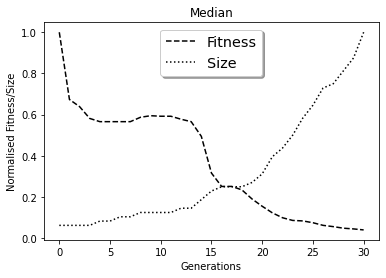

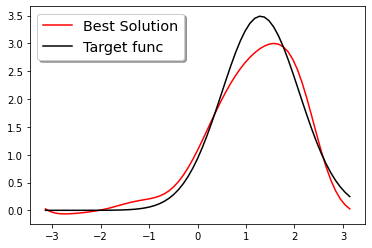

Best individual:
add(sub(cos(sub(sub(x, cos(sub(x, cos(cos(x))))), cos(mul(cos(mul(cos(add(x, 1)), mul(cos(mul(-1, add(-1, sin(cos(mul(-1, 1)))))), -1))), 1)))), -1), sin(x))


In [77]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 9

   	      	                                     fitness                                      	                         size                         
   	      	----------------------------------------------------------------------------------	------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std       	avg  	gen	max	mdn	min	nevals	std   
0  	2000  	4.28163e+28	0  	3.28258e+31	2.70667	0.483608	2000  	1.0131e+30	3.577	0  	7  	3  	2  	2000  	1.5166
1  	1594  	4.90031e+28	1  	8.09943e+31	1.82346	0.483608	1594  	1.82898e+30	3.676	1  	13 	3  	1  	1594  	1.87537
2  	1552  	4.58858e+28	2  	3.28258e+31	1.66686	0.483608	1552  	1.139e+30  	3.9095	2  	13 	3  	1  	1552  	2.06041
3  	1562  	3.66615e+28	3  	2.23002e+31	1.57693	0.483608	1562  	7.75359e+29	4.2285	3  	16 	4  	1  	1562  	2.28895
4  	1636  	8.27272e+28	4  	3.28258e+31	1.57693	0.420111	1636  	1.31263e+30	4.639 	4  	19 	4  	1  	1636  	2.5903 
5  	1606  	2.20923e+28	5  	8.20

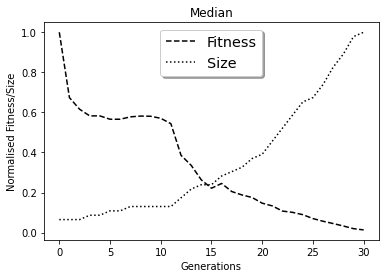

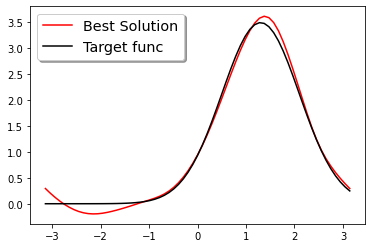

Best individual:
add(mul(cos(cos(add(cos(1), x))), protectedDiv(add(sin(sin(sin(sin(sin(sin(add(cos(sin(add(sub(x, sin(neg(add(-1, x)))), -1))), x))))))), cos(mul(sub(-1, 0), 0))), cos(sin(x)))), sin(x))


In [78]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 10

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	2000  	6.08476e+28	0  	3.28258e+31	2.70667	0.483608	2000  	1.13833e+30	3.598	0  	7  	3  	2  	2000  	1.51076
1  	1594  	1.34394e+28	1  	8.20644e+30	1.85249	0.483608	1594  	3.2088e+29 	3.652	1  	15 	3  	1  	1594  	1.83327
2  	1571  	1.93565e+28	2  	2.02486e+31	1.7014 	0.483608	1571  	5.23525e+29	4.0085	2  	15 	3  	1  	1571  	2.22046
3  	1618  	1.29066e+29	3  	1.99846e+32	1.53425	0.483608	1618  	4.52205e+30	4.3565	3  	18 	4  	1  	1618  	2.48343
4  	1557  	1.15833e+28	4  	8.20644e+30	1.53172	0.483608	1557  	2.71486e+29	4.769 	4  	20 	4  	1  	1557  	2.74183
5  	1596  	4.00447e+28	

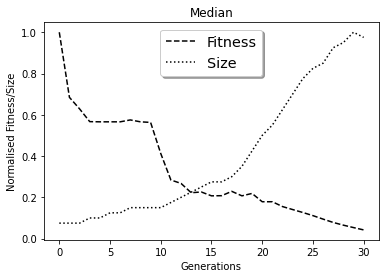

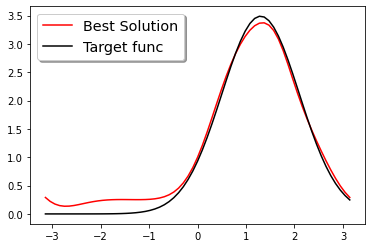

Best individual:
add(mul(sin(x), sub(sin(sin(sin(x))), -1)), add(sin(sin(sin(sub(add(x, 1), cos(x))))), add(neg(0), protectedDiv(-1, -1))))


In [79]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

<a name="p2s3"></a>

#### Population: 500, Tournament: 2 

In [80]:
no_population = 500   # population size
no_tournaments = 2    # tournament size

##### Run 1

   	      	                                     fitness                                      	                          size                         
   	      	----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std       	avg  	gen	max	mdn	min	nevals	std    
0  	500   	4.10322e+27	0  	2.05161e+30	2.76944	0.536473	500   	9.1659e+28	3.586	0  	7  	3  	2  	500   	1.55132
1  	397   	4.10322e+27	1  	2.05161e+30	1.82346	0.483608	397   	9.1659e+28	3.726	1  	13 	3  	1  	397   	1.92949
2  	409   	1.64129e+28	2  	8.20644e+30	1.82346	0.775352	409   	3.66636e+29	3.794	2  	14 	3  	1  	409   	2.04538
3  	409   	4.75058e+28	3  	2.02486e+31	1.5799 	0.775352	409   	9.11259e+29	4.312	3  	13 	4  	1  	409   	2.34663
4  	387   	1.31456e+29	4  	3.28258e+31	1.53172	0.775352	387   	1.76419e+30	5.162	4  	15 	5  	1  	387   	2.89685
5  	408   	1.02666e+29	5  	8.20

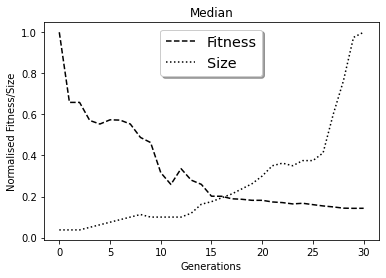

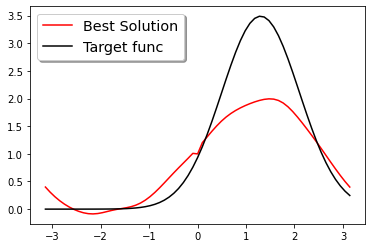

Best individual:
add(mul(mul(mul(1, 1), cos(sub(1, 1))), cos(cos(protectedDiv(protectedDiv(x, -1), mul(sin(mul(x, cos(cos(protectedDiv(x, 1))))), -1))))), sin(sub(sub(1, x), sub(-1, 1))))


In [81]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 2

   	      	                                  fitness                                  	                          size                         
   	      	---------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min    	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	1.86608e+29	0  	8.09943e+31	2.76944	1.53172	500   	3.63825e+30	3.606	0  	7  	3  	2  	500   	1.46655
1  	400   	1.64129e+28	1  	8.20644e+30	1.82346	0.483608	400   	3.66636e+29	3.682	1  	12 	3  	1  	400   	1.80135
2  	423   	5.69101e+28	2  	2.02486e+31	1.89283	0.483608	423   	9.7543e+29 	3.742	2  	13 	3  	1  	423   	2.02372
3  	398   	1.64129e+28	3  	8.20644e+30	1.64974	0.483608	398   	3.66636e+29	3.738	3  	12 	3  	1  	398   	2.03798
4  	383   	4.04972e+28	4  	2.02486e+31	1.53172	0.2557  	383   	9.04638e+29	3.662	4  	13 	3  	1  	383   	2.08129
5  	397   	2.36365e+28	5  	8.20644e+30	1.531

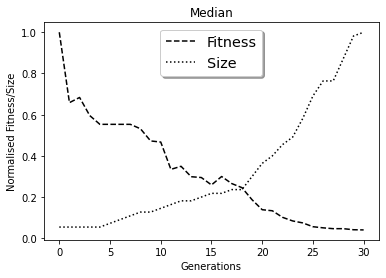

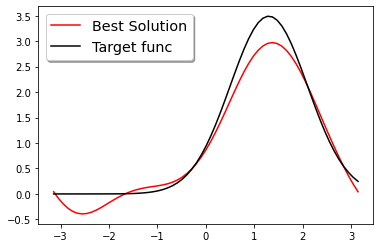

Best individual:
add(sin(x), sub(cos(add(x, sub(neg(cos(sin(x))), sin(cos(add(x, neg(cos(sin(-1))))))))), -1))


In [82]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 3

   	      	                                     fitness                                      	                          size                         
   	      	----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std       	avg  	gen	max	mdn	min	nevals	std    
0  	500   	4.10322e+27	0  	2.05161e+30	2.70667	0.483608	500   	9.1659e+28	3.732	0  	7  	3  	2  	500   	1.54667
1  	405   	3.1042     	1  	28.9027    	1.82346	0.483608	405   	2.75486   	3.886	1  	13 	3  	1  	405   	1.99625
2  	380   	7.0086e+27 	2  	2.05161e+30	1.64093	0.483608	380   	1.12204e+29	4.236	2  	14 	3  	1  	380   	2.35718
3  	388   	3.60673e+29	3  	7.021e+31  	1.58458	0.483608	388   	4.52296e+30	4.626	3  	14 	4  	1  	388   	2.78031
4  	407   	7.33229e+28	4  	2.23002e+31	1.54657	0.483608	407   	1.07199e+30	5.164	4  	20 	4  	1  	407   	3.46022
5  	417   	1.7073e+29 	5  	2.02

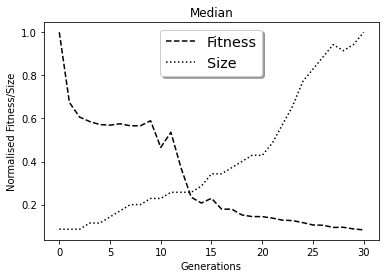

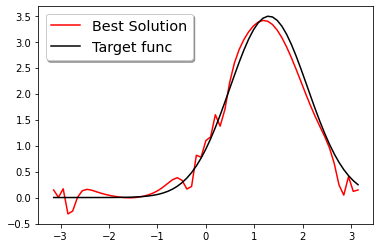

Best individual:
add(sin(x), sub(protectedDiv(cos(cos(protectedDiv(-1, neg(sin(x))))), cos(sin(protectedDiv(cos(sub(0, sin(sin(-1)))), cos(sin(x)))))), neg(sin(sub(sub(x, -1), cos(x))))))


In [83]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 4

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	9.74072e+28	0  	2.02486e+31	2.70667	0.483608	500   	1.32862e+30	3.526	0  	7  	3  	2  	500   	1.50643
1  	404   	3.29337    	1  	55.4064    	1.85249	0.483608	404   	3.94198    	3.576	1  	13 	3  	1  	404   	1.86232
2  	399   	1.64129e+28	2  	8.20644e+30	1.82346	0.483608	399   	3.66636e+29	3.688	2  	11 	3  	1  	399   	1.84137
3  	386   	1.23944e+28	3  	2.89745e+30	1.53172	0.483608	386   	1.67842e+29	3.936	3  	12 	3  	1  	386   	2.01393
4  	383   	3.62942e+28	4  	8.20644e+30	1.53172	0.483608	383   	5.23527e+29	4.376	4  	14 	4  	1  	383   	2.35682
5  	402   	3.16279e+28	5  

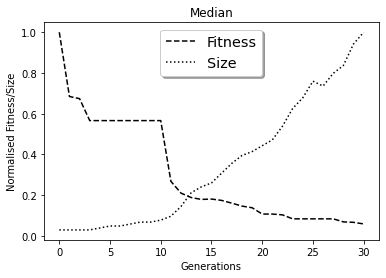

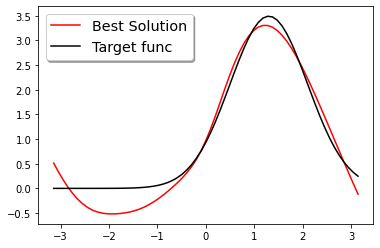

Best individual:
add(add(sin(x), cos(1)), add(sin(x), cos(add(cos(-1), add(mul(mul(-1, add(cos(x), add(protectedDiv(add(-1, protectedDiv(add(cos(x), x), add(mul(0, x), protectedDiv(add(add(1, sin(x)), 1), cos(-1))))), add(-1, add(cos(-1), add(mul(mul(-1, add(cos(x), add(protectedDiv(add(-1, -1), add(-1, 1)), -1))), -1), -1)))), -1))), -1), -1)))))


In [84]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 5

   	      	                                     fitness                                      	                         size                        
   	      	----------------------------------------------------------------------------------	-----------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std       	avg  	gen	max	mdn	min	nevals	std  
0  	500   	9.67191e+28	0  	2.23002e+31	2.70667	0.483608	500   	1.3685e+30	3.708	0  	7  	3  	2  	500   	1.582
1  	393   	4.04972e+28	1  	2.02486e+31	1.82346	0.483608	393   	9.04638e+29	3.57 	1  	11 	3  	1  	393   	1.71029
2  	400   	1.18187e+28	2  	3.85776e+30	1.65855	0.483608	400   	1.95046e+29	3.896	2  	12 	3  	1  	400   	2.00529
3  	406   	6.10133e+28	3  	2.02486e+31	1.58458	0.483608	406   	9.79488e+29	4.224	3  	14 	4  	1  	406   	2.27724
4  	395   	8.20644e+28	4  	3.28258e+31	1.53287	0.483608	395   	1.51097e+30	4.518	4  	19 	4  	1  	395   	2.62939
5  	380   	6.10133e+28	5  	2.02486e+31

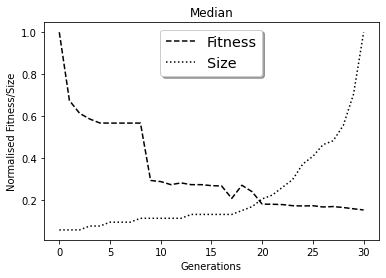

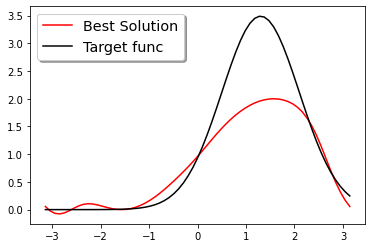

Best individual:
add(cos(sub(0, mul(protectedDiv(mul(sub(cos(x), cos(-1)), cos(cos(cos(sub(x, 0))))), -1), sub(0, protectedDiv(sub(0, mul(protectedDiv(cos(x), -1), cos(cos(sub(cos(x), cos(-1)))))), cos(mul(cos(sub(x, 0)), mul(protectedDiv(cos(cos(mul(sub(add(-1, 1), cos(x)), cos(cos(sub(mul(cos(x), cos(sub(mul(add(0, 1), sub(mul(mul(neg(protectedDiv(cos(x), -1)), cos(0)), mul(cos(sub(x, 0)), mul(cos(x), 1))), add(-1, 1))), sub(x, 1)))), cos(protectedDiv(x, 1)))))))), -1), cos(cos(sub(cos(mul(-1, 1)), protectedDiv(sub(x, 1), add(-1, 1))))))))))))), sin(x))


In [85]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 6

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	4.46004e+28	0  	2.23002e+31	2.70667	0.536473	500   	9.96297e+29	3.428	0  	7  	3  	2  	500   	1.44804
1  	384   	6.22111e+28	1  	2.02486e+31	1.82346	0.536473	384   	9.79779e+29	3.408	1  	10 	3  	1  	384   	1.66179
2  	386   	3.28258e+28	2  	8.20644e+30	1.65855	0.483608	386   	5.17982e+29	3.688	2  	12 	3  	1  	386   	1.95414
3  	395   	1.1777e+29 	3  	2.02486e+31	1.53172	0.483608	395   	1.18846e+30	4.16 	3  	15 	3  	1  	395   	2.26327
4  	400   	9.3839e+28 	4  	2.02486e+31	1.57693	0.483608	400   	1.10621e+30	4.646	4  	15 	4  	1  	400   	2.49493
5  	369   	1.86608e+29	5  

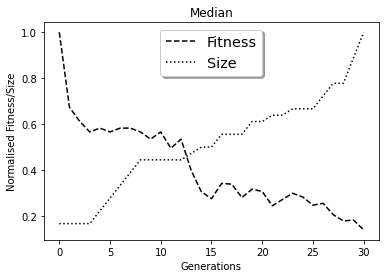

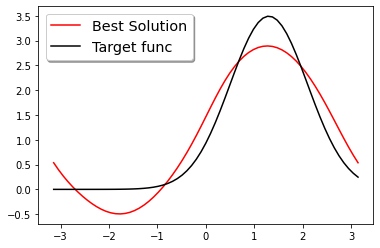

Best individual:
add(add(sin(x), 1), mul(cos(cos(add(sin(sin(x)), 1))), cos(add(x, -1))))


In [86]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 7

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	1.64129e+28	0  	8.20644e+30	2.70667	0.741508	500   	3.66636e+29	3.642	0  	7  	3  	2  	500   	1.54462
1  	391   	6.36289    	1  	1434.21    	1.9452 	0.775352	391   	64.0103    	3.506	1  	10 	3  	1  	391   	1.72684
2  	411   	5.28068e+28	2  	2.02486e+31	1.7014 	1.42151 	411   	9.17865e+29	3.854	2  	13 	3  	1  	411   	2.07284
3  	392   	5.73258e+28	3  	2.8455e+31 	1.53172	1.32035 	392   	1.27129e+30	4.136	3  	13 	3  	1  	392   	2.4951 
4  	398   	4.10322e+27	4  	2.05161e+30	1.53172	1.3103  	398   	9.1659e+28 	4.504	4  	15 	4  	1  	398   	2.86042
5  	396   	4.22301e+28	5  

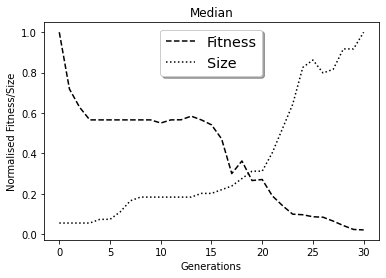

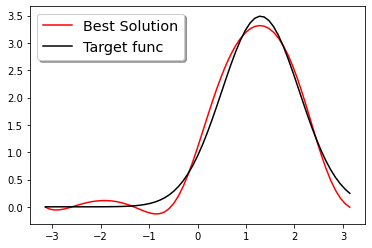

Best individual:
neg(mul(sub(sub(-1, sin(sin(x))), sin(sin(x))), add(sin(sin(sin(add(x, cos(sin(-1)))))), cos(-1))))


In [87]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 8

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max       	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	1.00313e+29	0  	2.8455e+31	2.70667	0.483608	500   	1.55998e+30	3.608	0  	7  	3  	2  	500   	1.53829
1  	389   	2.94377e+26	1  	1.47188e+29	2.00319	0.483608	389   	6.57588e+27	3.978	1  	12 	4  	1  	389   	2.02028
2  	381   	1.19784e+27	2  	5.9892e+29 	1.65855	0.483608	381   	2.67577e+28	4.188	2  	12 	4  	1  	381   	2.14491
3  	392   	4.19506e+28	3  	8.20644e+30	1.57693	0.483608	392   	5.56106e+29	4.594	3  	14 	4  	1  	392   	2.36837
4  	398   	8.20644e+27	4  	2.05161e+30	1.53172	0.483608	398   	1.29495e+29	4.904	4  	15 	5  	1  	398   	2.56101
5  	399   	2.99204e+28	5  	8

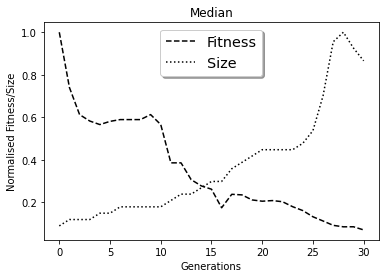

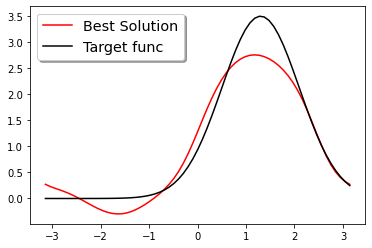

Best individual:
add(sin(add(x, sin(sin(sin(sin(x)))))), sub(sin(sin(add(cos(sub(sin(sin(sub(sub(-1, 1), sub(x, x)))), sin(sin(add(cos(-1), mul(1, x)))))), x))), -1))


In [88]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 9

   	      	                                 fitness                                  	                          size                         
   	      	--------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min    	nevals	std       	avg  	gen	max	mdn	min	nevals	std    
0  	500   	5.69101e+28	0  	2.02486e+31	2.70667	1.52596	500   	9.7543e+29	3.474	0  	7  	3  	2  	500   	1.35695
1  	399   	3.1753     	1  	40.3463    	1.82346	1.3103 	399   	3.45694   	3.368	1  	12 	3  	1  	399   	1.73222
2  	393   	4.10322e+27	2  	2.05161e+30	1.7014 	1.3103 	393   	9.1659e+28	3.75 	2  	13 	3  	1  	393   	2.05024
3  	413   	8.61676e+28	3  	8.20644e+30	1.58458	0.989314	413   	8.21249e+29	3.874	3  	12 	3  	1  	413   	2.36096
4  	389   	8.09943e+28	4  	2.02486e+31	1.53172	0.989314	389   	1.27807e+30	4.264	4  	21 	3  	1  	389   	2.78896
5  	397   	8.20644e+28	5  	3.28258e+31	1.53172	0.989

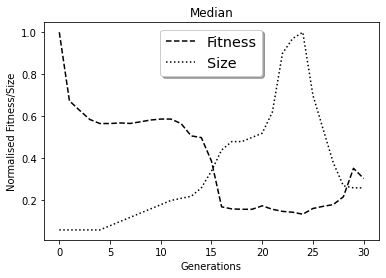

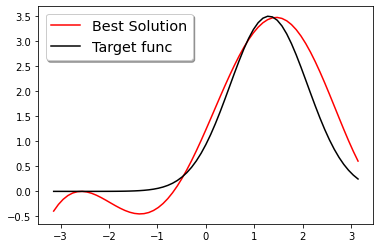

Best individual:
mul(add(cos(sin(-1)), x), sub(sin(add(1, x)), -1))


In [89]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 10

   	      	                                  fitness                                  	                          size                         
   	      	---------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min    	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	4.04972e+28	0  	2.02486e+31	2.70667	1.52596	500   	9.04638e+29	3.574	0  	7  	3  	2  	500   	1.50616
1  	393   	5.69101e+28	1  	2.02486e+31	1.82346	1.52596	393   	9.7543e+29 	3.47 	1  	13 	3  	1  	393   	1.85394
2  	404   	4.04972e+28	2  	2.02486e+31	1.64093	1.52596	404   	9.04638e+29	3.768	2  	12 	3  	1  	404   	1.98448
3  	398   	1.64129e+28	3  	8.20644e+30	1.53172	1.52596	398   	3.66636e+29	3.9  	3  	12 	3  	1  	398   	2.11991
4  	401   	4.37747e+60	4  	2.18874e+63	1.53172	1.42481	401   	9.77853e+61	4.118	4  	14 	3  	1  	401   	2.37488
5  	399   	5.02645e+28	5  	8.20644e+30	1.53172	1

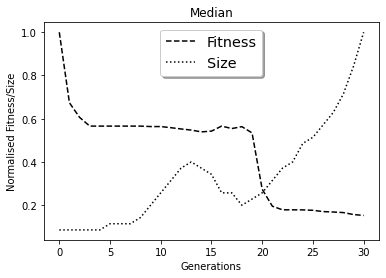

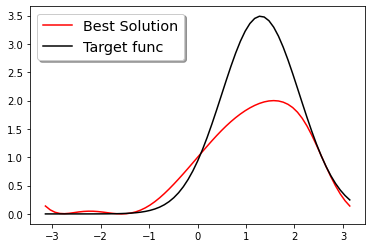

Best individual:
add(cos(mul(mul(cos(x), sub(1, cos(x))), cos(cos(sin(sin(mul(cos(x), cos(cos(sub(1, x)))))))))), sin(x))


In [90]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

<a name = "p2s4"> </a>

#### Population: 500, Tournament: 5 

In [91]:
no_population = 500   # population size
no_tournaments = 5    # tournament size

##### Run 1

   	      	                                  fitness                                  	                          size                         
   	      	---------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min    	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	4.04972e+28	0  	2.02486e+31	2.76944	1.52596	500   	9.04638e+29	3.578	0  	7  	3  	2  	500   	1.52968
1  	380   	4.52885e+28	1  	2.02486e+31	1.82346	0.483608	380   	9.10735e+29	3.67 	1  	11 	3  	1  	380   	1.78468
2  	408   	6.03505e+28	2  	8.20644e+30	1.82346	0.483608	408   	6.49222e+29	3.944	2  	15 	3  	1  	408   	2.03589
3  	412   	3.28258e+28	3  	8.20644e+30	1.58458	0.483608	412   	5.17982e+29	4.464	3  	18 	4  	1  	412   	2.75113
4  	404   	4.92387e+28	4  	8.20644e+30	1.55086	0.483608	404   	6.33758e+29	4.71 	4  	22 	4  	1  	404   	3.07081
5  	406   	7.81143e+28	5  	2.02486e+31	1.531

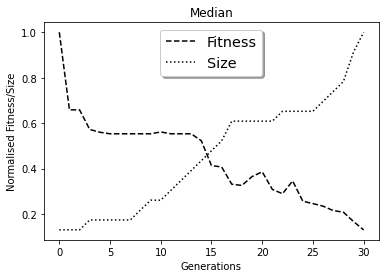

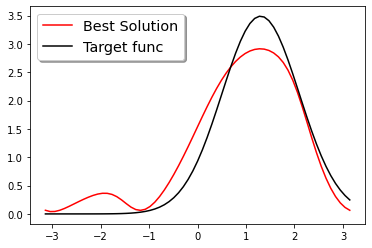

Best individual:
sub(cos(sub(cos(sub(sin(cos(sub(protectedDiv(sin(x), x), x))), protectedDiv(-1, sub(-1, sin(cos(sub(sin(sub(sin(1), sin(sin(x)))), cos(sub(cos(sub(1, sub(-1, x))), x))))))))), x)), sub(-1, sin(x)))


In [92]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 2

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	1.64129e+28	0  	8.20644e+30	2.70667	0.483608	500   	3.66636e+29	3.588	0  	7  	3  	2  	500   	1.50541
1  	389   	4.04972e+28	1  	2.02486e+31	1.82346	0.483608	389   	9.04638e+29	3.638	1  	14 	3  	1  	389   	1.83602
2  	394   	4.10322e+27	2  	2.05161e+30	1.65855	0.483608	394   	9.1659e+28 	3.674	2  	12 	3  	1  	394   	1.8654 
3  	399   	1.64129e+28	3  	8.20644e+30	1.58458	0.483608	399   	3.66636e+29	3.938	3  	10 	4  	1  	399   	1.90844
4  	391   	789.75     	4  	393613     	1.53172	0.483608	391   	17585.2    	4.392	4  	12 	4  	1  	391   	2.23301
5  	393   	8.09943e+28	5  

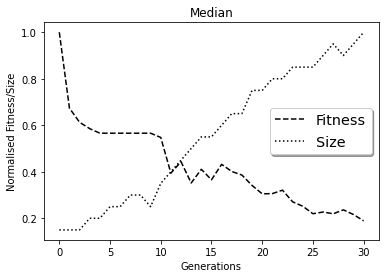

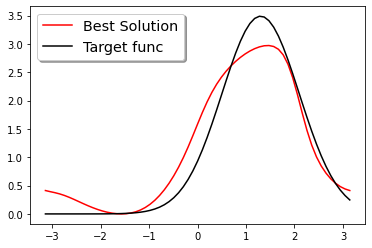

Best individual:
sub(sin(x), sub(sin(mul(sub(-1, sin(sin(sin(sin(sin(sin(sin(sin(x))))))))), sin(neg(mul(sub(-1, sin(x)), sin(sin(sin(neg(add(mul(neg(1), x), -1)))))))))), 1))


In [93]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 3

   	      	                                  fitness                                  	                          size                         
   	      	---------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg       	gen	max       	mdn    	min    	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	1.0151e+29	0  	2.8455e+31	2.70667	1.52596	500   	1.56125e+30	3.566	0  	7  	3  	2  	500   	1.49721
1  	410   	4.10322e+27	1  	2.05161e+30	1.82346	0.483608	410   	9.1659e+28 	3.494	1  	11 	3  	1  	410   	1.78605
2  	413   	8.15294e+28	2  	2.02486e+31	1.57693	0.483608	413   	1.04861e+30	3.61 	2  	13 	3  	1  	413   	1.93543
3  	377   	7.33229e+28	3  	2.02486e+31	1.53172	0.483608	377   	1.16336e+30	3.558	3  	13 	3  	1  	377   	2.07235
4  	406   	2.87225e+28	4  	8.20644e+30	1.53172	0.483608	406   	3.989e+29  	3.742	4  	12 	3  	1  	406   	2.29073
5  	403   	8.56326e+28	5  	2.02486e+31	1.53172	0

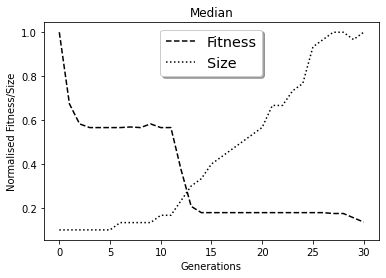

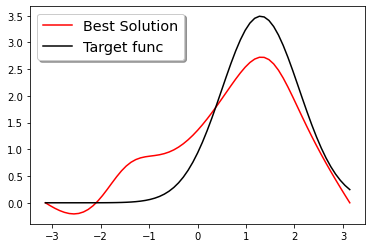

Best individual:
add(sin(x), protectedDiv(protectedDiv(add(sin(cos(-1)), sin(1)), protectedDiv(x, protectedDiv(protectedDiv(sin(x), cos(sin(x))), 1))), protectedDiv(-1, -1)))


In [94]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 4

   	      	                                  fitness                                  	                         size                         
   	      	---------------------------------------------------------------------------	------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min    	nevals	std        	avg	gen	max	mdn	min	nevals	std   
0  	500   	1.29698e+29	0  	2.23002e+31	2.70667	1.52411	500   	1.62056e+30	3.7	0  	7  	3  	2  	500   	1.5729
1  	394   	4.10322e+27	1  	2.05161e+30	2.14155	0.802353	394   	9.1659e+28 	3.596	1  	11 	3  	1  	394   	1.75522
2  	396   	2.53075e+28	2  	8.20644e+30	1.82346	0.802353	396   	3.92362e+29	3.702	2  	12 	3  	1  	396   	1.86687
3  	404   	5.69101e+28	3  	2.02486e+31	1.71084	0.619848	404   	9.7543e+29 	3.972	3  	16 	4  	1  	404   	2.11547
4  	395   	4.97241e+28	4  	8.20644e+30	1.57693	0.752367	395   	6.33813e+29	4.222	4  	14 	4  	1  	395   	2.47239
5  	410   	3.28258e+28	5  	8.20644e+30	1.53172	0.483

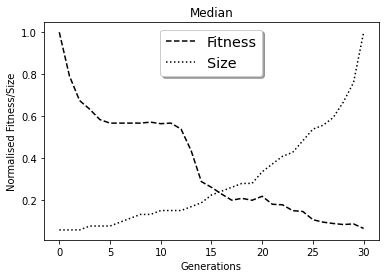

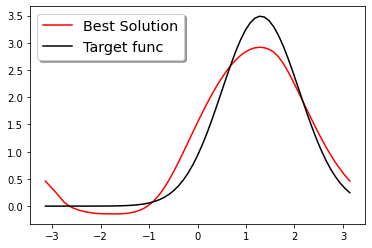

Best individual:
add(cos(add(-1, x)), sub(1, mul(-1, mul(sin(x), cos(add(-1, cos(add(-1, cos(sub(sin(mul(sub(sin(cos(sub(x, mul(sin(x), sub(neg(x), add(-1, 0)))))), -1), 1)), x))))))))))


In [95]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 5

   	      	                                 fitness                                  	                          size                         
   	      	--------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min    	nevals	std       	avg 	gen	max	mdn	min	nevals	std    
0  	500   	4.10322e+27	0  	2.05161e+30	2.70667	1.52596	500   	9.1659e+28	3.62	0  	7  	3  	2  	500   	1.57213
1  	410   	1.19784e+27	1  	5.9892e+29 	1.82346	1.52596	410   	2.67577e+28	3.668	1  	11 	3  	1  	410   	1.90099
2  	382   	1.64129e+28	2  	8.20644e+30	1.82346	1.27183	382   	3.66636e+29	4.108	2  	13 	3  	1  	382   	2.32988
3  	400   	5.10855    	3  	212.697    	1.57693	1.27183	400   	17.3558    	4.51 	3  	18 	4  	1  	400   	2.72578
4  	398   	4.04972e+28	4  	2.02486e+31	1.53172	1.27183	398   	9.04638e+29	4.562	4  	20 	4  	1  	398   	3.03416
5  	402   	6.10133e+28	5  	2.23002e+31	1.53172	1.27183

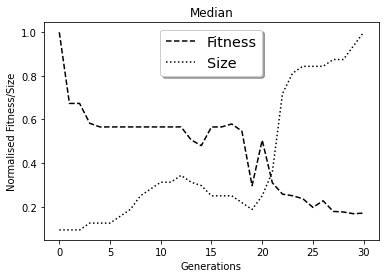

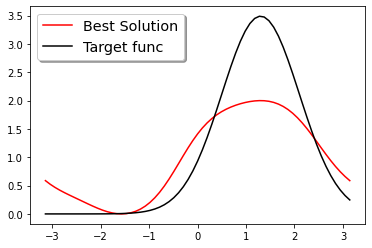

Best individual:
add(sin(mul(protectedDiv(add(sin(mul(protectedDiv(sin(mul(sin(add(1, sin(protectedDiv(x, 1)))), cos(1))), 1), cos(sin(protectedDiv(x, 1))))), x), cos(add(-1, 0))), cos(1))), 1)


In [96]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 6

   	      	                                  fitness                                  	                          size                         
   	      	---------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min    	nevals	std        	avg 	gen	max	mdn	min	nevals	std    
0  	500   	1.29978e+28	0  	2.39568e+30	2.76944	1.52596	500   	1.67768e+29	3.63	0  	7  	3  	2  	500   	1.56624
1  	392   	4.92387e+28	1  	8.20644e+30	1.82346	1.52596	392   	6.33758e+29	3.684	1  	12 	3  	1  	392   	1.89318
2  	391   	4.04972e+28	2  	2.02486e+31	1.7014 	1.45307	391   	9.04638e+29	3.706	2  	13 	3  	1  	391   	2.10132
3  	388   	5.69101e+28	3  	2.02486e+31	1.53172	1.45307	388   	9.7543e+29 	3.61 	3  	14 	3  	1  	388   	2.10663
4  	409   	1.64129e+28	4  	8.20644e+30	1.53172	1.43651	409   	3.66636e+29	3.554	4  	14 	3  	1  	409   	2.07342
5  	394   	1.1094e+29 	5  	2.26443e+31	1.53172	0.4

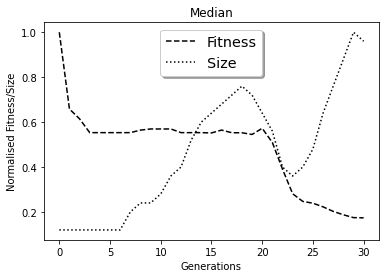

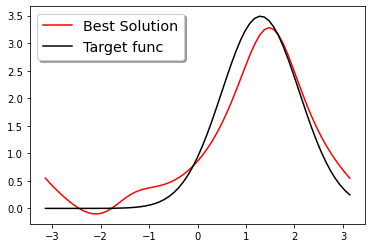

Best individual:
protectedDiv(add(cos(neg(cos(sub(sub(1, cos(x)), -1)))), protectedDiv(sin(sin(x)), protectedDiv(-1, 0))), cos(sin(x)))


In [97]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 7

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	2.24021e+28	0  	8.20644e+30	2.70667	0.536473	500   	3.82604e+29	3.518	0  	7  	3  	2  	500   	1.50256
1  	398   	5.81079e+28	1  	2.02486e+31	1.83798	0.536473	398   	9.75727e+29	3.554	1  	13 	3  	1  	398   	1.79975
2  	388   	2.05161e+28	2  	8.20644e+30	1.65855	0.536473	388   	3.77742e+29	3.53 	2  	13 	3  	1  	388   	1.92382
3  	394   	3.15559    	3  	100.279    	1.58458	0.483608	394   	5.11947    	3.664	3  	12 	3  	1  	394   	2.08209
4  	403   	1.23097e+28	4  	2.05161e+30	1.53172	0.483608	403   	1.5844e+29 	3.876	4  	14 	3  	1  	403   	2.32306
5  	394   	5.69101e+28	5  

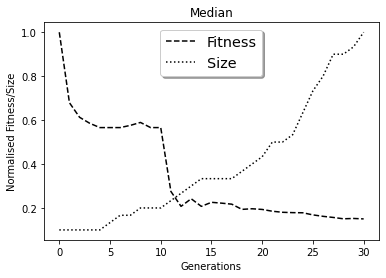

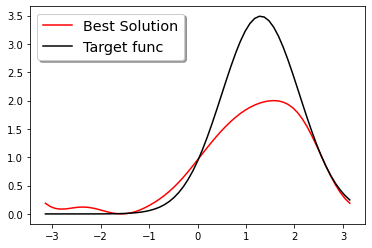

Best individual:
add(cos(mul(cos(mul(neg(x), mul(1, 1))), sub(cos(mul(sub(1, sin(x)), -1)), sin(sub(1, neg(x)))))), sin(x))


In [98]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 8

   	      	                                  fitness                                  	                          size                         
   	      	---------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min    	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	4.34026e+28	0  	2.02486e+31	2.76944	1.52596	500   	9.06834e+29	3.596	0  	7  	3  	2  	500   	1.49692
1  	374   	3.88238    	1  	371.585    	1.82346	0.536473	374   	16.8581    	3.568	1  	12 	3  	1  	374   	1.76561
2  	406   	3.06404    	2  	53.1814    	1.62792	0.475286	406   	3.38266    	3.718	2  	13 	3  	1  	406   	2.01457
3  	404   	5.00799e+28	3  	2.02486e+31	1.57693	0.475286	404   	9.16766e+29	4.092	3  	14 	3  	1  	404   	2.2261 
4  	392   	2.34215e+28	4  	8.20644e+30	1.53172	0.475286	392   	3.83121e+29	4.498	4  	14 	4  	1  	392   	2.63173
5  	406   	1.09717e+29	5  	2.02486e+31	1.531

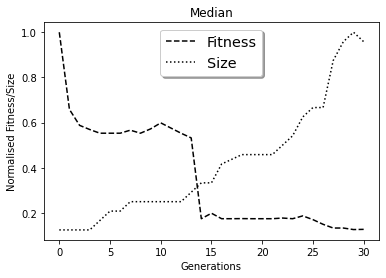

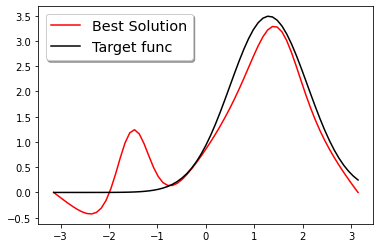

Best individual:
add(sin(x), protectedDiv(protectedDiv(protectedDiv(protectedDiv(cos(neg(cos(sub(cos(x), mul(-1, x))))), cos(sin(mul(x, protectedDiv(-1, -1))))), cos(sin(x))), protectedDiv(x, sin(x))), protectedDiv(sub(protectedDiv(cos(neg(cos(1))), protectedDiv(-1, 0)), add(1, sin(x))), 0)))


In [99]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 9

   	      	                                  fitness                                  	                          size                         
   	      	---------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min    	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	1.16215e+28	0  	5.81076e+30	2.70667	1.52596	500   	2.59605e+29	3.636	0  	7  	3  	2  	500   	1.50183
1  	390   	3.23386    	1  	55.6335    	1.82346	1.52596	390   	3.51051    	3.396	1  	10 	3  	1  	390   	1.61839
2  	409   	1.64129e+28	2  	8.20644e+30	1.82346	1.52596	409   	3.66636e+29	3.542	2  	11 	3  	1  	409   	1.82654
3  	385   	2.05161e+28	3  	8.20644e+30	1.57693	1.4378 	385   	3.77742e+29	3.75 	3  	14 	3  	1  	385   	2.10226
4  	399   	32.8362    	4  	13237.8    	1.5573 	1.24496	399   	594.595    	3.742	4  	15 	3  	1  	399   	2.25287
5  	393   	6.9956e+28 	5  	8.20644e+30	1.53172	1

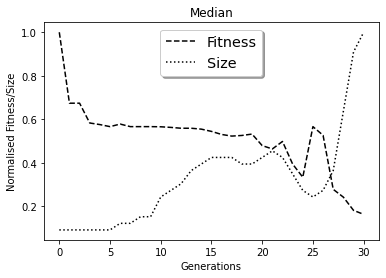

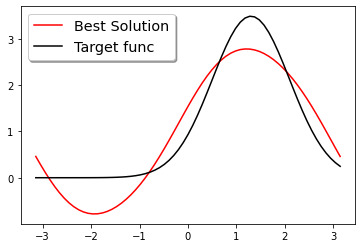

Best individual:
add(1, add(cos(add(protectedDiv(-1, 1), x)), sin(sin(mul(1, x)))))


In [100]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 10

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	7.33229e+28	0  	2.02486e+31	2.70667	0.483608	500   	1.04116e+30	3.592	0  	7  	3  	2  	500   	1.54581
1  	382   	2.46193e+28	1  	8.20644e+30	1.82346	0.741508	382   	3.88486e+29	3.72 	1  	12 	3  	1  	382   	1.8659 
2  	381   	4.04972e+28	2  	2.02486e+31	1.7014 	0.775352	381   	9.04638e+29	3.918	2  	15 	4  	1  	381   	2.0638 
3  	399   	1.0151e+29 	3  	2.02486e+31	1.57693	0.775352	399   	1.33148e+30	4.296	3  	15 	4  	1  	399   	2.52277
4  	377   	1.64129e+28	4  	8.20644e+30	1.53172	0.775352	377   	3.66636e+29	4.604	4  	14 	4  	1  	377   	2.74138
5  	394   	3.28258e+28	5  

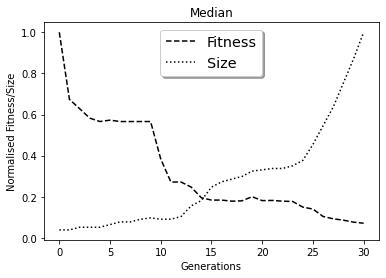

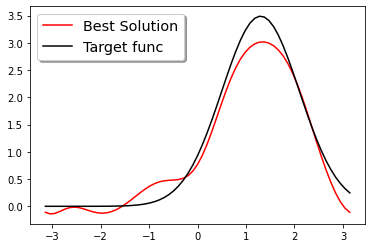

Best individual:
protectedDiv(add(sub(sin(x), -1), add(cos(cos(mul(1, x))), add(sub(cos(x), mul(-1, cos(add(sub(sin(x), -1), add(cos(cos(neg(x))), add(sub(cos(x), mul(protectedDiv(add(1, add(neg(mul(cos(sub(1, 1)), add(1, 1))), sin(add(add(1, -1), add(neg(mul(cos(sub(1, 1)), cos(x))), neg(cos(1))))))), add(1, sin(cos(x)))), cos(1))), add(sin(x), sin(x)))))))), add(sin(x), sin(x))))), add(1, 1))


In [101]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

<a name="tables"></a>

### Summary Tables 

<a name="problem1tables"></a>

#### Problem 1 

##### Population = 2000, Tournament Size = 5

| Run # | Minimum Fitness | Size | Total Evals |
|-------|-----------------|------|-------------|
| 1     | 0.0007913666    | 91   | 49517       |
| 2     | 0.0277493       | 72   | 49314       |
| 3     | 0.0436885       | 83   | 49423       |
| 4     | 0.176655        | 57   | 49242       |
| 5     | 0.0141518       | 56   | 49499       |
| 6     | 0.258449        | 30   | 49329       |
| 7     | 0.374017        | 55   | 49295       |
| 8     | 0.014536        | 40   | 49208       |
| 9     | 0.0219963       | 43   | 49467       |
| 10    | 0.241995        | 56   | 49236       |

##### Population = 2000, Tournament Size = 2

| Run # | Minimum Fitness | Size | Total Evals |
|-------|-----------------|------|-------------|
| 1     | 0.0000000689317 | 41   | 49660       |
| 2     | 0.000000227494  | 39   | 49370       |
| 3     | 0.203127        | 29   | 49464       |
| 4     | 0.00157302      | 30   | 49233       |
| 5     | 0.126762        | 74   | 49302       |
| 6     | 0.178933        | 54   | 49505       |
| 7     | 0.000642098     | 39   | 49391       |
| 8     | 0.0854111       | 68   | 49537       |
| 9     | 0.0620814       | 56   | 49421       |
| 10    | 0.174484        | 29   | 49330       |

##### Population = 500, Tournament Size = 2

| Run # | Minimum Fitness | Size | Total Evals |
|-------|-----------------|------|-------------|
| 1     | 0.252239        | 35   | 12272       |
| 2     | 0.0141518       | 27   | 12437       |
| 3     | 0.485948        | 80.5 | 12433       |
| 4     | 0.31443         | 33   | 12290       |
| 5     | 0.0108141       | 36   | 12286       |
| 6     | 0.493627        | 26   | 12275       |
| 7     | 0.281886        | 80   | 12438       |
| 8     | 0.459378        | 45   | 12254       |
| 9     | 0.304892        | 38   | 12364       |
| 10    | 0.492308        | 29   | 12261       |

##### Population = 500, Tournament Size = 5

| Run # | Minimum Fitness | Size | Total Evals |
|-------|-----------------|------|-------------|
| 1     | 0.0277317       | 39.5 | 12430       |
| 2     | 0.0000192972    | 43   | 12510       |
| 3     | 0.487255        | 43   | 12341       |
| 4     | 0.0302781       | 25   | 12265       |
| 5     | 0.492585        | 25   | 12334       |
| 6     | 0.394833        | 20   | 12320       |
| 7     | 0.482732        | 28   | 12299       |
| 8     | 0.363569        | 32   | 12499       |
| 9     | 0.29585         | 44   | 12460       |
| 10    | 0.239496        | 45   | 12433       |

<a name="problem2tables"></a>

#### Problem 2 

##### Population = 2000, Tournament Size = 2

| Run # | Minimum Fitness | Size | Total Evals |
|-------|-----------------|------|-------------|
| 1     | 0.0617013       | 83   | 49586       |
| 2     | 0.00444193      | 23   | 49418       |
| 3     | 0.00268993      | 34   | 49621       |
| 4     | 0.0698962       | 77.5 | 49432       |
| 5     | 0.0513003       | 65   | 49510       |
| 6     | 0.0366046       | 70.5 | 49585       |
| 7     | 0.0801572       | 98   | 49588       |
| 8     | 0.0138204       | 50   | 49251       |
| 9     | 0.046518        | 50   | 49429       |
| 10    | 0.0166408       | 85.5 | 49384       |

##### Population = 2000, Tournament Size = 5

| Run # | Minimum Fitness | Size | Total Evals |
|-------|-----------------|------|-------------|
| 1     | 0.0465445       | 57   | 49309       |
| 2     | 0.00987873      | 49   | 49165       |
| 3     | 0.0586423       | 62   | 49189       |
| 4     | 0.0617657       | 36   | 49569       |
| 5     | 0.0813903       | 69.5 | 49388       |
| 6     | 0.0599938       | 55   | 49590       |
| 7     | 0.0206211       | 58   | 49332       |
| 8     | 0.0608836       | 48   | 49300       |
| 9     | 0.0126258       | 46   | 49385       |
| 10    | 0.0326255       | 40   | 49446       |

##### Population = 500, Tournament Size = 2

| Run # | Minimum Fitness | Size | Total Evals |
|-------|-----------------|------|-------------|
| 1     | 0.0385292       | 80   | 12400       |
| 2     | 0.0637664       | 55   | 12409       |
| 3     | 0.0296145       | 35   | 12336       |
| 4     | 0.0728534       | 104  | 12355       |
| 5     | 0.366663        | 54   | 12274       |
| 6     | 0.148851        | 18   | 12281       |
| 7     | 0.0266269       | 54.5 | 12402       |
| 8     | 0.0935592       | 33.5 | 12286       |
| 9     | 0.180315        | 50   | 12369       |
| 10    | 0.369826        | 35   | 12434       |

##### Population = 500, Tournament Size = 5

| Run # | Minimum Fitness | Size | Total Evals |
|-------|-----------------|------|-------------|
| 1     | 0.103048        | 23   | 12360       |
| 2     | 0.100033        | 20   | 12339       |
| 3     | 0.245542        | 30   | 12400       |
| 4     | 0.0960266       | 54   | 12375       |
| 5     | 0.388966        | 32   | 12239       |
| 6     | 0.0996761       | 25   | 12349       |
| 7     | 0.367875        | 30   | 12332       |
| 8     | 0.178465        | 24   | 12303       |
| 9     | 0.275208        | 33   | 12442       |
| 10    | 0.0521522       | 77   | 12391       |

<a name="best"></a>

### Best configurations 

<a name="problem1best"></a>

#### Problem 1 

Population size = 500, tournament size = 5

In [146]:
no_population = 500   # population size
no_tournaments = 5     # tournament size

In [147]:
measurement = lambda x: math.sin(math.pi/4 + 3*x)

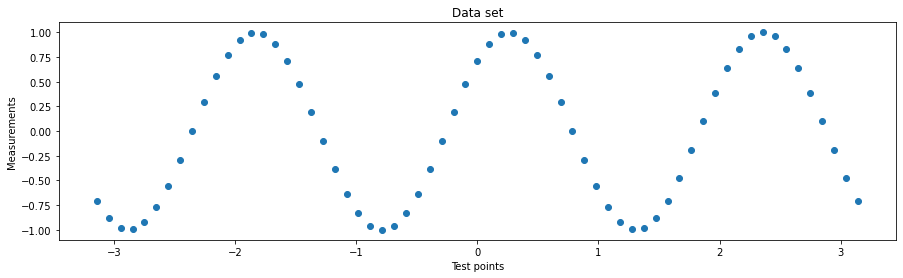

In [148]:
target = data_set()

##### Run 1

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	8.20644e+27	0  	2.05161e+30	1.47824	0.493627	500   	1.29495e+29	3.552	0  	7  	3  	2  	500   	1.49776
1  	389   	4.04972e+28	1  	2.02486e+31	0.985935	0.493627	389   	9.04638e+29	3.752	1  	10 	3  	1  	389   	1.89275
2  	409   	4.04972e+28	2  	2.02486e+31	0.803682	0.493627	409   	9.04638e+29	4.478	2  	12 	4  	1  	409   	2.35404
3  	391   	5.69101e+28	3  	2.8455e+31 	0.5     	0.492736	391   	1.27127e+30	5.024	3  	15 	5  	1  	391   	2.55097
4  	381   	9.99228e+28	4  	4.99614e+31	0.5     	0.492736	381   	2.23211e+30	5.492	4  	20 	5  	1  	381   	2.82382
5  	396   	1.64129e+28

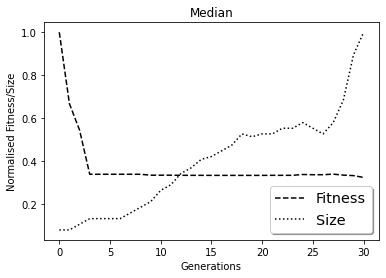

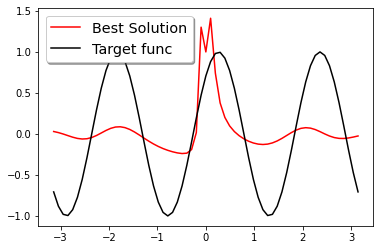

Best individual:
mul(cos(add(0, sub(x, add(sub(-1, x), mul(add(protectedDiv(sub(sin(-1), -1), x), add(x, 0)), cos(x)))))), protectedDiv(sub(sin(-1), mul(1, -1)), x))


In [149]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 2

   	      	                                  fitness                                  	                          size                         
   	      	---------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	1.68286e+28	0  	8.20644e+30	1.47824	0.5	500   	3.66735e+29	3.616	0  	7  	3  	2  	500   	1.52202
1  	390   	5.69101e+28	1  	2.8455e+31 	0.985935	0.493627	390   	1.27127e+30	3.722	1  	12 	3  	1  	390   	1.81789
2  	416   	4.15743e+26	2  	2.07872e+29	0.803682	0.493627	416   	9.287e+27  	4.318	2  	12 	4  	1  	416   	2.01417
3  	386   	1.52593    	3  	73.6062    	0.5     	0.493627	386   	4.63201    	4.876	3  	15 	5  	1  	386   	2.3993 
4  	404   	1.22506e+29	4  	3.28258e+31	0.5     	0.493627	404   	1.92083e+30	5.388	4  	15 	5  	1  	404   	2.51584
5  	391   	4.51896e+27	5  	2.25948e+30	0.5     	

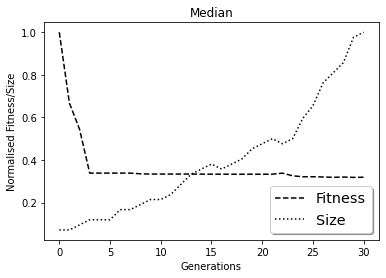

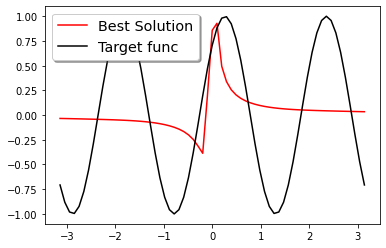

Best individual:
mul(cos(sub(sub(1, cos(protectedDiv(cos(sub(sub(cos(neg(0)), cos(1)), -1)), x))), protectedDiv(cos(sub(sub(cos(neg(x)), cos(1)), -1)), x))), protectedDiv(cos(sub(sub(1, cos(sub(0, cos(protectedDiv(0, x))))), -1)), x))


In [150]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 3

   	      	                                     fitness                                      	                          size                         
   	      	----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std       	avg  	gen	max	mdn	min	nevals	std    
0  	500   	7.69674e+27	0  	2.39568e+30	1.47824	0.493627	500   	1.2506e+29	3.562	0  	7  	3  	2  	500   	1.46498
1  	418   	2.05161e+28	1  	8.20644e+30	0.992308	0.493627	418   	3.77742e+29	3.64 	1  	12 	3  	1  	418   	1.92312
2  	402   	3.6929e+28 	2  	8.20644e+30	0.958543	0.492585	402   	5.25773e+29	4.03 	2  	13 	4  	1  	402   	2.05939
3  	387   	1.49641    	3  	23.6174    	0.5     	0.492585	387   	2.26947    	4.566	3  	12 	4  	1  	387   	2.32328
4  	378   	6.10133e+28	4  	2.8455e+31 	0.5     	0.492585	378   	1.27439e+30	4.88 	4  	15 	4  	1  	378   	2.41859
5  	410   	7.45767e+28	5  

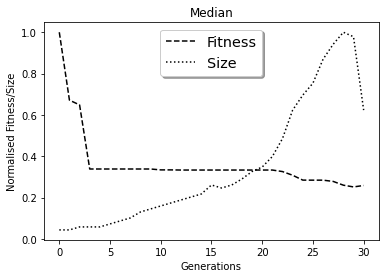

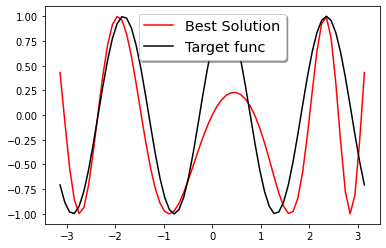

Best individual:
sin(sub(sin(x), mul(x, x)))


In [151]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 4

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	2.90538e+27	0  	1.45269e+30	1.47824	0.493627	500   	6.49013e+28	3.644	0  	7  	3  	2  	500   	1.53924
1  	392   	4.10322e+27	1  	2.05161e+30	0.992308	0.492585	392   	9.1659e+28 	3.834	1  	14 	3  	1  	392   	1.93454
2  	395   	4.04972e+28	2  	2.02486e+31	0.803682	0.492585	395   	9.04638e+29	4.056	2  	12 	3  	1  	395   	2.03393
3  	409   	4.04972e+28	3  	2.02486e+31	0.723999	0.493627	409   	9.04638e+29	4.494	3  	14 	4  	1  	409   	2.33194
4  	409   	1.02637e+28	4  	2.05161e+30	0.5     	0.493627	409   	1.37285e+29	5.006	4  	19 	5  	1  	409   	2.62792
5  	391   	2.38496    

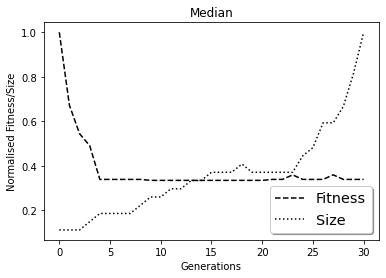

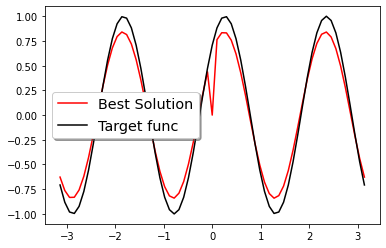

Best individual:
mul(neg(sin(protectedDiv(1, 1))), sin(mul(protectedDiv(mul(add(sin(-1), mul(mul(x, add(sub(-1, 0), sub(-1, 1))), protectedDiv(-1, 0))), 1), x), x)))


In [152]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 5

   	      	                            fitness                            	                          size                         
   	      	---------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg    	gen	max    	mdn    	min     	nevals	std    	avg 	gen	max	mdn	min	nevals	std    
0  	500   	3.29423	0  	166.928	1.47824	0.493627	500   	9.23337	3.59	0  	7  	3  	2  	500   	1.50927
1  	413   	7.51779	1  	1423.56	1.16472	0.493627	413   	89.4588	3.924	1  	13 	3  	1  	413   	1.93965
2  	389   	1.77771	2  	56.4519	0.803682	0.493627	389   	4.37326	4.118	2  	15 	3  	1  	389   	2.1345 
3  	410   	21.0116	3  	9549.13	0.5     	0.493627	410   	426.575	4.654	3  	17 	4  	1  	410   	2.48239
4  	392   	4.10322e+27	4  	2.05161e+30	0.5     	0.493627	392   	9.1659e+28	5.744	4  	18 	5  	1  	392   	3.06243
5  	385   	1.61989e+29	5  	8.09943e+31	0.5     	0.493627	385   	3.61855e+30	6.806	5  	24 	6  	1  	385   	3.60782
6  	402   	1.

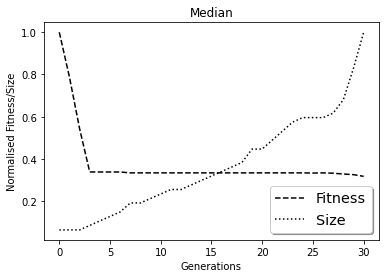

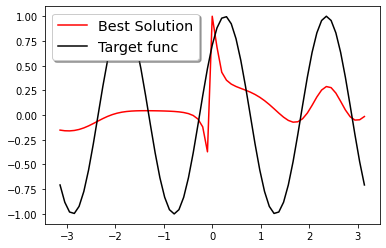

Best individual:
protectedDiv(mul(add(protectedDiv(cos(-1), sub(1, -1)), 0), add(cos(1), sin(add(mul(mul(add(cos(sin(1)), 0), add(0, x)), sub(add(protectedDiv(mul(mul(1, 0), x), add(1, -1)), x), 0)), x)))), add(sin(add(protectedDiv(x, cos(1)), mul(add(0, x), 0))), x))


In [153]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 6

   	      	                                  fitness                                  	                         size                        
   	      	---------------------------------------------------------------------------	-----------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min	nevals	std        	avg  	gen	max	mdn	min	nevals	std  
0  	500   	4.34026e+28	0  	2.02486e+31	1.47824	0.5	500   	9.06834e+29	3.506	0  	7  	3  	2  	500   	1.469
1  	393   	1.71304    	1  	52.0428    	0.992308	0.492585	393   	3.03907    	3.79 	1  	12 	3  	1  	393   	1.90733
2  	395   	4.04972e+28	2  	2.02486e+31	0.803682	0.492585	395   	9.04638e+29	4.502	2  	14 	4  	1  	395   	2.33281
3  	382   	4.46004e+28	3  	2.23002e+31	0.5     	0.492585	382   	9.96297e+29	5.228	3  	14 	5  	1  	382   	2.64349
4  	394   	2.46319    	4  	207.595    	0.5     	0.492585	394   	14.4454    	5.854	4  	16 	5  	1  	394   	3.27974
5  	405   	2.20989    	5  	207.595    	0.5     	0.492585

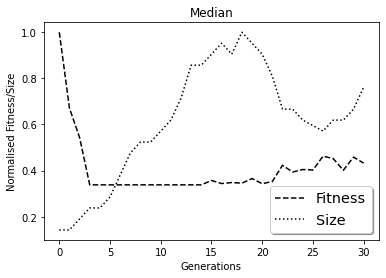

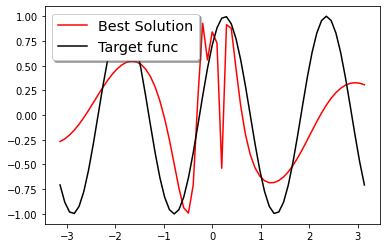

Best individual:
sin(protectedDiv(neg(sin(protectedDiv(sub(x, neg(1)), sin(neg(cos(-1)))))), x))


In [154]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 7

   	      	                                      fitness                                      	                         size                         
   	      	-----------------------------------------------------------------------------------	------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std   
0  	500   	1.93183e+28	0  	8.20644e+30	1.47824	0.493627	500   	3.72208e+29	3.474	0  	7  	3  	2  	500   	1.4551
1  	387   	2.37337    	1  	364.414    	0.992308	0.493627	387   	16.356     	3.664	1  	13 	3  	1  	387   	1.92538
2  	418   	1.718e+29  	2  	3.28258e+31	0.985935	0.455232	418   	1.86663e+30	4.29 	2  	14 	3  	1  	418   	2.43514
3  	401   	4.79136e+27	3  	2.39568e+30	0.5     	0.455232	401   	1.07031e+29	5.06 	3  	19 	4  	1  	401   	3.0647 
4  	377   	2.23489e+29	4  	2.02486e+31	0.5     	0.455232	377   	1.97752e+30	6.246	4  	22 	5  	1  	377   	3.96554
5  	384   	566.062    	5  

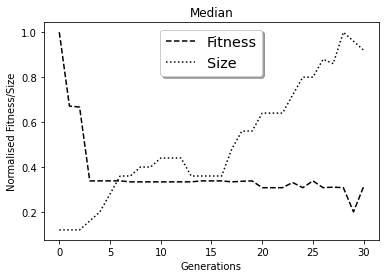

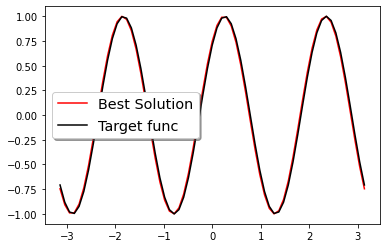

Best individual:
sin(neg(add(mul(sub(neg(1), add(1, 1)), x), sub(neg(sin(1)), sin(0)))))


In [155]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 8

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg       	gen	max        	mdn    	min     	nevals	std        	avg 	gen	max	mdn	min	nevals	std    
0  	500   	1.2799e+29	0  	2.02486e+31	1.47824	0.493627	500   	1.56637e+30	3.64	0  	7  	3  	2  	500   	1.55897
1  	403   	2.05161e+28	1  	8.20644e+30	1.02945	0.455232	403   	3.77742e+29	3.942	1  	13 	3  	1  	403   	2.09538
2  	406   	1.64129e+28	2  	8.20644e+30	0.803682	0.455232	406   	3.66636e+29	4.676	2  	13 	4.5	1  	406   	2.24032
3  	392   	1.66417    	3  	84.4005    	0.5     	0.455232	392   	4.70825    	5.388	3  	19 	5  	1  	392   	2.50469
4  	395   	4.15743e+26	4  	2.07872e+29	0.5     	0.455232	395   	9.287e+27  	5.868	4  	21 	6  	1  	395   	2.7609 
5  	401   	1.18222e+28	5  	

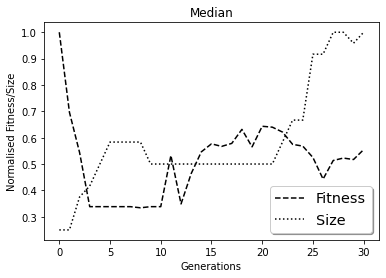

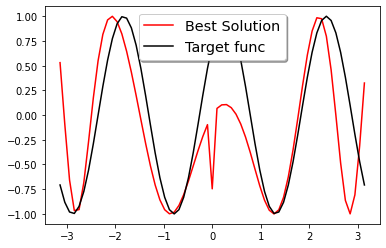

Best individual:
sin(protectedDiv(sub(-1, add(sin(add(add(add(protectedDiv(x, -1), mul(x, 1)), -1), sin(sub(sin(1), sub(-1, add(sin(-1), neg(x))))))), protectedDiv(x, -1))), protectedDiv(-1, x)))


In [156]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 9

   	      	                           fitness                            	                          size                         
   	      	--------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg    	gen	max    	mdn    	min     	nevals	std   	avg 	gen	max	mdn	min	nevals	std    
0  	500   	3.10524	0  	61.4256	1.47824	0.493627	500   	5.4403	3.76	0  	7  	3  	2  	500   	1.64024
1  	406   	1.94755	1  	48.9013	0.985935	0.492585	406   	4.03874	3.784	1  	13 	3  	1  	406   	1.96095
2  	393   	1.7123 	2  	38.5662	0.803682	0.493627	393   	3.05648	4.358	2  	15 	4  	1  	393   	2.27285
3  	404   	2.32371	3  	264.621	0.548628	0.493627	404   	12.1453	5.048	3  	17 	5  	1  	404   	2.5686 
4  	395   	2.64551	4  	359.371	0.5     	0.493627	395   	16.6036	5.772	4  	20 	5  	1  	395   	2.99667
5  	412   	7.74262e+28	5  	2.23002e+31	0.5     	0.493627	412   	1.1216e+30	6.546	5  	23 	6  	1  	412   	3.23356
6  	385   	3.53744e+28	6  	8

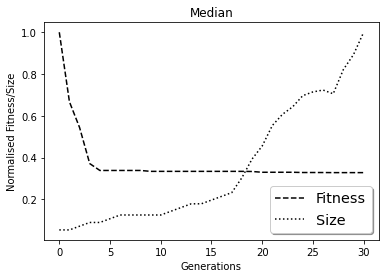

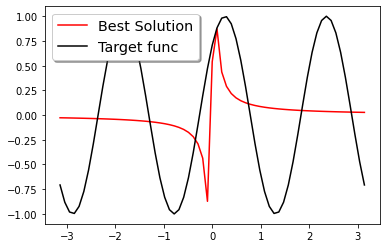

Best individual:
mul(cos(cos(0)), protectedDiv(add(1, add(sin(-1), 0)), x))


In [157]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 10

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	500   	6.51165e+28	0  	2.23002e+31	1.47824	0.493627	500   	1.06464e+30	3.552	0  	7  	3  	2  	500   	1.51502
1  	405   	1.54064    	1  	21.7383    	0.985935	0.492585	405   	1.84274    	3.564	1  	11 	3  	1  	405   	1.70819
2  	390   	1.53325    	2  	20.6855    	0.803682	0.493627	390   	2.0988     	4.04 	2  	13 	3  	1  	390   	2.11433
3  	398   	5.69101e+28	3  	2.02486e+31	0.5     	0.492585	398   	9.7543e+29 	4.178	3  	18 	4  	1  	398   	2.14996
4  	404   	1.64129e+28	4  	8.20644e+30	0.5     	0.492585	404   	3.66636e+29	4.644	4  	14 	4  	1  	404   	2.35314
5  	400   	5.62226e+28

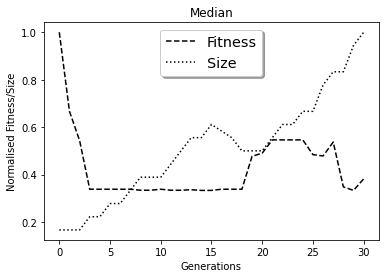

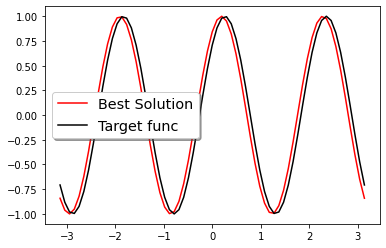

Best individual:
sin(sub(add(x, x), sub(-1, x)))


In [158]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

<a name="problem2best"></a>

#### Problem 2 

Population size = 2000, tournament size = 2

In [132]:
no_population = 2000   # population size
no_tournaments = 2     # tournament size

In [133]:
def N():
    mu1 = -1.7
    mu2 = 1.3
    sigma1 = 0.5
    sigma2 = 0.8
    measurements = lambda x: (((math.e)**(-(((x-mu1)/sigma1)**2)/2))/(sigma1*math.sqrt(2*math.pi)) + 7) * ((math.e)**(-(((x-mu2)/sigma2)**2)/2))/(sigma2*math.sqrt(2*math.pi))
    return measurements

In [134]:
measurement = N()

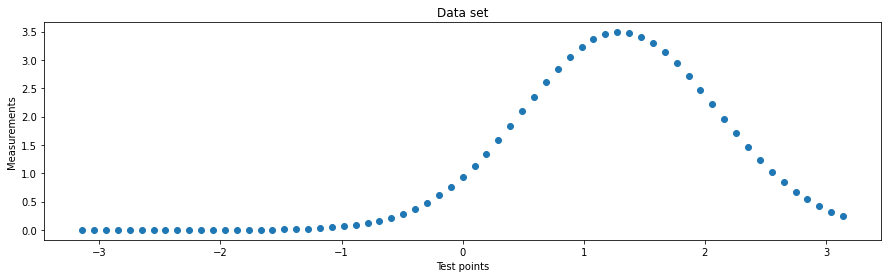

In [135]:
target = data_set()

##### Run 1

   	      	                                     fitness                                      	                          size                         
   	      	----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max       	mdn    	min     	nevals	std       	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	4.99015e+28	0  	2.8455e+31	2.70667	0.483608	2000  	1.0266e+30	3.5945	0  	7  	3  	2  	2000  	1.50634
1  	1558  	2.36318e+28	1  	2.02486e+31	1.82346	0.483608	1558  	5.55277e+29	3.54  	1  	13 	3  	1  	1558  	1.79315
2  	1561  	3.35841e+28	2  	2.02486e+31	1.72912	0.483608	1561  	6.97672e+29	3.734 	2  	16 	3  	1  	1561  	2.05578
3  	1597  	7.83312e+28	3  	2.02486e+31	1.57693	0.483608	1597  	1.0486e+30 	4.049 	3  	15 	3  	1  	1597  	2.31119
4  	1564  	6.30518e+28	4  	3.28258e+31	1.53172	0.483608	1564  	1.06599e+30	4.396 	4  	18 	4  	1  	1564  	2.54149
5  	1565  	8.43393e+28	5  

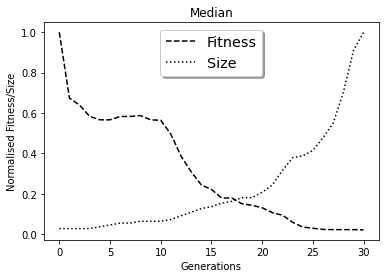

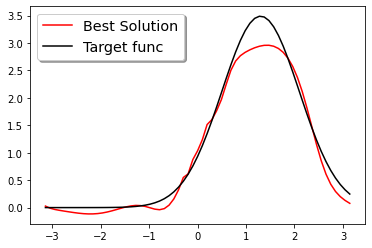

Best individual:
sub(sin(x), add(-1, sin(sub(-1, sub(x, mul(1, sin(sub(mul(sin(1), x), add(-1, sin(sub(mul(sin(add(protectedDiv(1, x), neg(1))), mul(mul(1, sin(sub(-1, add(-1, sin(sub(mul(sub(sub(0, x), -1), mul(0, add(mul(1, -1), sub(add(x, sin(sub(-1, sub(x, protectedDiv(-1, 1))))), x)))), sub(x, -1))))))), sub(x, -1))), sub(x, -1))))))))))))


In [136]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 2

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	6.27654e+28	0  	2.23002e+31	2.76944	0.483608	2000  	1.00758e+30	3.6055	0  	7  	3  	2  	2000  	1.48555
1  	1546  	4.50719e+28	1  	2.8455e+31 	1.82346	0.483608	1546  	9.02126e+29	3.643 	1  	13 	3  	1  	1546  	1.83944
2  	1551  	4.79453e+28	2  	2.02486e+31	1.75564	0.477846	1551  	7.84893e+29	3.859 	2  	14 	3  	1  	1551  	2.00178
3  	1621  	1.34772e+28	3  	8.20644e+30	1.53172	0.477846	1621  	2.78796e+29	4.1655	3  	17 	3  	1  	1621  	2.29349
4  	1599  	6.29311e+28	4  	2.02486e+31	1.53172	0.477846	1599  	1.04729e+30	4.5475	4  	19 	4  	1  	1599  	2.58007
5  	1588  	4.6808e+2

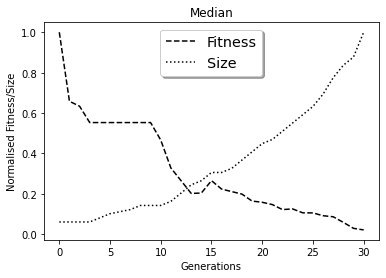

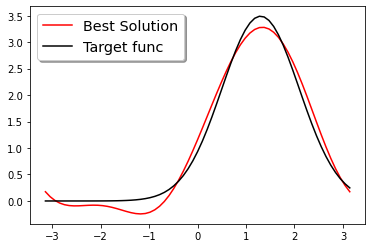

Best individual:
sub(protectedDiv(mul(cos(sub(x, 1)), sin(x)), 1), sub(sub(mul(sin(x), -1), sin(sin(cos(sub(protectedDiv(x, x), x))))), cos(neg(sin(1)))))


In [137]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 3

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	3.75216e+28	0  	3.28258e+31	2.70667	0.775352	2000  	9.02757e+29	3.5875	0  	7  	3  	2  	2000  	1.55027
1  	1581  	6.75061e+59	1  	1.35012e+63	1.82346	0.536473	1581  	3.01821e+61	3.629 	1  	12 	3  	1  	1581  	1.90141
2  	1593  	3.45716e+28	2  	2.02486e+31	1.60803	0.483608	1593  	6.049e+29  	3.797 	2  	13 	3  	1  	1593  	2.03416
3  	1551  	2.16646e+28	3  	2.02486e+31	1.53172	0.483608	1551  	5.28561e+29	4.216 	3  	13 	4  	1  	1551  	2.24396
4  	1574  	4.05091e+28	4  	2.02486e+31	1.53172	0.475286	1574  	8.20667e+29	4.583 	4  	18 	4  	1  	1574  	2.556  
5  	1591  	6.33324e+

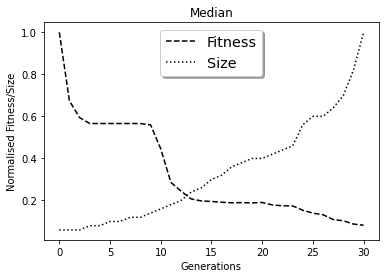

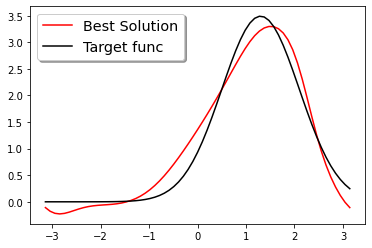

Best individual:
add(sin(x), sub(add(mul(cos(sin(1)), sin(sin(cos(add(sub(-1, -1), add(-1, sub(x, 0))))))), sin(cos(add(sub(-1, -1), add(neg(cos(-1)), add(neg(cos(x)), sub(protectedDiv(x, 1), sin(x)))))))), -1))


In [138]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 4

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	2000  	4.10322e+27	0  	8.20644e+30	2.70667	0.483608	2000  	1.83456e+29	3.592	0  	7  	3  	2  	2000  	1.52497
1  	1572  	2.44021e+28	1  	2.8455e+31 	1.82346	0.475286	1572  	6.73282e+29	3.5505	1  	13 	3  	1  	1572  	1.80207
2  	1563  	4.48061e+28	2  	3.28258e+31	1.71455	0.475286	1563  	9.37888e+29	3.7825	2  	15 	3  	1  	1563  	1.986  
3  	1585  	4.76996e+28	3  	2.8455e+31 	1.57693	0.483608	1585  	8.83947e+29	3.954 	3  	14 	3  	1  	1585  	2.2282 
4  	1565  	7.29538e+28	4  	2.02486e+31	1.53172	0.420111	1565  	9.29767e+29	4.1985	4  	14 	4  	1  	1565  	2.40605
5  	1590  	8.46412e+28

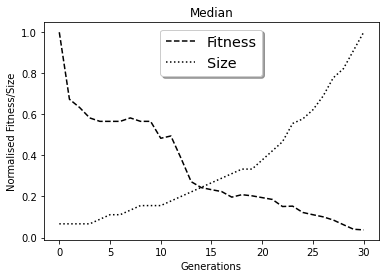

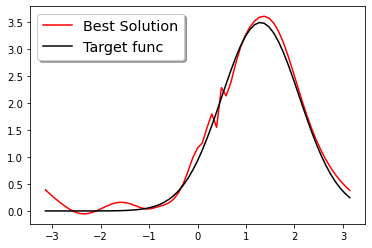

Best individual:
add(add(protectedDiv(1, sin(cos(sin(x)))), sin(x)), sin(sin(add(add(mul(cos(x), -1), sin(add(add(1, sin(cos(sub(x, add(protectedDiv(1, add(add(mul(cos(x), -1), sin(add(add(1, sin(cos(sub(x, protectedDiv(x, -1))))), neg(sin(-1))))), x)), sin(add(mul(sin(-1), protectedDiv(x, 0)), cos(sub(x, -1))))))))), neg(sin(-1))))), x))))


In [139]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 5

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max       	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	2000  	2.91431e+28	0  	2.8455e+31	2.70667	0.483608	2000  	7.03983e+29	3.556	0  	7  	3  	2  	2000  	1.47101
1  	1592  	4.82957e+27	1  	2.05161e+30	1.82346	0.483608	1592  	9.72113e+28	3.61 	1  	12 	3  	1  	1592  	1.80164
2  	1562  	1.60053e+28	2  	2.02486e+31	1.65855	0.483608	1562  	4.73055e+29	3.8135	2  	14 	3  	1  	1562  	2.0114 
3  	1596  	6.20769e+28	3  	2.23002e+31	1.57693	0.475286	1596  	8.57588e+29	4.171 	3  	15 	4  	1  	1596  	2.21918
4  	1565  	7.8444e+28 	4  	3.26063e+31	1.53172	0.475286	1565  	1.05571e+30	4.582 	4  	17 	4  	1  	1565  	2.56482
5  	1566  	3.90829e+28	5 

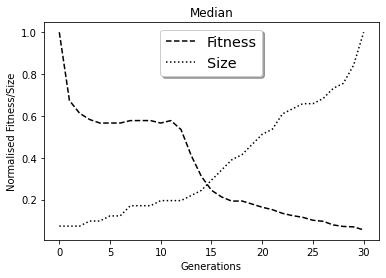

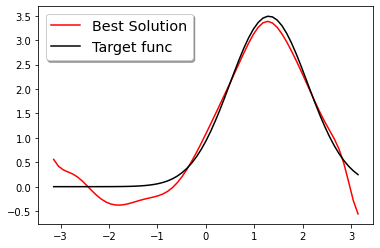

Best individual:
sub(sin(protectedDiv(x, sin(1))), sub(sub(sub(cos(sin(x)), cos(cos(protectedDiv(mul(sin(x), mul(x, sin(-1))), mul(sin(-1), mul(cos(cos(add(add(mul(sin(1), x), protectedDiv(1, 0)), protectedDiv(x, -1)))), -1)))))), 1), cos(add(x, -1))))


In [140]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 6

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	2000  	3.31252e+28	0  	3.28258e+31	2.70667	0.483608	2000  	8.03999e+29	3.528	0  	7  	3  	2  	2000  	1.46466
1  	1597  	1.33236e+28	1  	1.43375e+31	1.82346	0.483608	1597  	3.74815e+29	3.5155	1  	12 	3  	1  	1597  	1.80465
2  	1627  	2.97803e+28	2  	2.02486e+31	1.82346	0.483608	1627  	6.73419e+29	3.787 	2  	14 	3  	1  	1627  	2.00839
3  	1557  	2.47914e+28	3  	8.20644e+30	1.58458	0.483608	1557  	3.89459e+29	3.971 	3  	14 	3  	1  	1557  	2.2116 
4  	1574  	2.96146e+28	4  	2.8455e+31 	1.53172	0.483608	1574  	7.15052e+29	4.3205	4  	17 	4  	1  	1574  	2.46146
5  	1566  	2.71898e+28

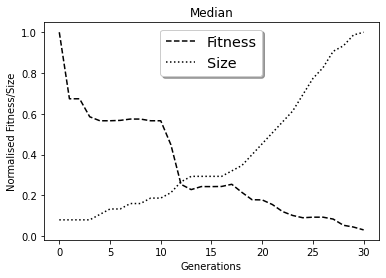

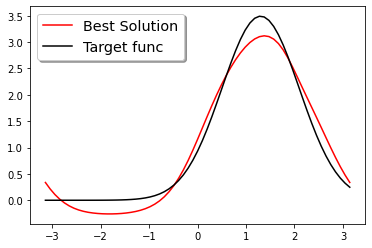

Best individual:
add(sin(sin(sin(add(x, cos(mul(add(sin(sub(x, -1)), neg(sub(add(-1, sin(x)), mul(1, sin(cos(sub(sin(sin(add(x, cos(mul(-1, protectedDiv(sub(0, add(x, neg(sub(x, x)))), sin(0))))))), x))))))), protectedDiv(cos(mul(-1, protectedDiv(sub(0, mul(-1, sin(add(neg(x), mul(-1, 0))))), sin(0)))), -1))))))), add(neg(sub(sub(cos(sin(x)), 1), sin(x))), 1))


In [141]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 7

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg  	gen	max	mdn	min	nevals	std    
0  	2000  	1.11501e+28	0  	2.02486e+31	2.70667	0.483608	2000  	4.54954e+29	3.549	0  	7  	3  	2  	2000  	1.48108
1  	1608  	3.75482    	1  	371.585    	1.82346	0.483608	1608  	10.7005    	3.648	1  	12 	3  	1  	1608  	1.83823
2  	1562  	3.37178e+28	2  	3.28258e+31	1.73588	0.483608	1562  	8.84657e+29	3.9665	2  	13 	3  	1  	1562  	2.07807
3  	1565  	4.45965e+28	3  	3.28258e+31	1.57693	0.483608	1565  	1.07428e+30	4.0715	3  	15 	3  	1  	1565  	2.26746
4  	1598  	4.95474e+28	4  	2.23002e+31	1.55998	0.477846	1598  	8.71397e+29	4.58  	4  	16 	4  	1  	1598  	2.60492
5  	1591  	3.73878e+28	

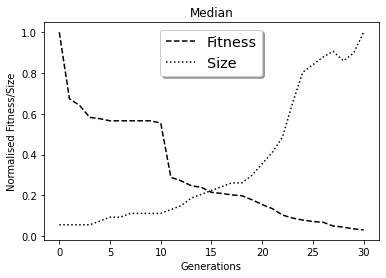

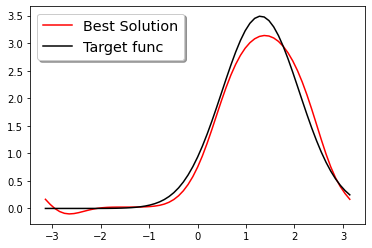

Best individual:
add(sin(x), add(cos(mul(mul(add(sub(x, cos(x)), neg(1)), protectedDiv(1, 1)), cos(sin(sin(x))))), protectedDiv(1, cos(cos(-1)))))


In [142]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 8

   	      	                                     fitness                                      	                          size                         
   	      	----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std       	avg  	gen	max	mdn	min	nevals	std    
0  	2000  	6.61806e+28	0  	8.09943e+31	2.70667	0.483608	2000  	1.8944e+30	3.597	0  	7  	3  	2  	2000  	1.47905
1  	1621  	2.12744e+28	1  	2.02486e+31	1.82346	0.483608	1621  	6.41605e+29	3.713	1  	13 	3  	1  	1621  	1.89331
2  	1584  	8.35956e+27	2  	1.32148e+31	1.77508	0.483608	1584  	3.00675e+29	3.8155	2  	14 	3  	1  	1584  	2.08458
3  	1641  	5.13285e+28	3  	2.8455e+31 	1.57693	0.483608	1641  	8.01e+29   	4.0105	3  	17 	3  	1  	1641  	2.39841
4  	1594  	7.52408e+28	4  	2.23002e+31	1.53172	0.483608	1594  	1.11981e+30	4.3075	4  	18 	4  	1  	1594  	2.77271
5  	1609  	7.8452e+28 	5  	

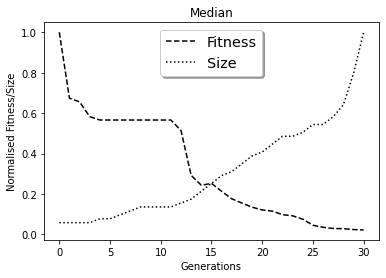

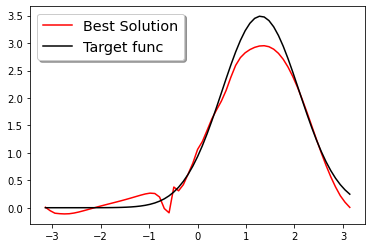

Best individual:
sub(add(sin(x), sin(sub(1, sub(cos(sub(sin(cos(protectedDiv(-1, sub(sin(cos(protectedDiv(-1, sin(x)))), x)))), x)), x)))), -1)


In [143]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 9

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg   	gen	max	mdn	min	nevals	std    
0  	2000  	1.58076e+28	0  	2.23002e+31	2.70667	0.483608	2000  	5.18114e+29	3.5905	0  	7  	3  	2  	2000  	1.53779
1  	1609  	2.05161e+27	1  	2.05161e+30	1.82346	0.483608	1609  	6.48452e+28	3.5655	1  	13 	3  	1  	1609  	1.84329
2  	1602  	5.57505e+28	2  	8.09943e+31	1.76637	0.483608	1602  	1.86881e+30	3.733 	2  	13 	3  	1  	1602  	2.08799
3  	1575  	7.86209e+28	3  	8.09943e+31	1.57693	0.483608	1575  	2.0362e+30 	3.8925	3  	16 	3  	1  	1575  	2.34136
4  	1555  	5.63764e+28	4  	3.61517e+31	1.53172	0.477846	1555  	1.0355e+30 	4.2035	4  	19 	4  	1  	1555  	2.70575
5  	1564  	9.10455e+

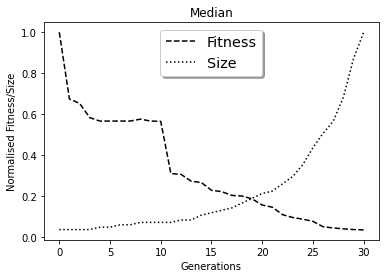

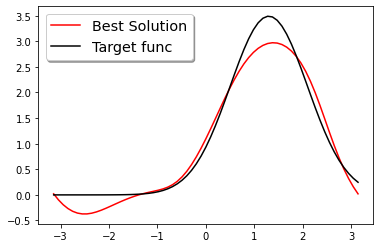

Best individual:
add(sub(cos(add(sub(add(-1, sin(cos(cos(sin(x))))), cos(add(-1, cos(add(sub(0, cos(cos(sin(x)))), x))))), x)), -1), sin(x))


In [144]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

##### Run 10

   	      	                                      fitness                                      	                          size                         
   	      	-----------------------------------------------------------------------------------	-------------------------------------------------------
gen	nevals	avg        	gen	max        	mdn    	min     	nevals	std        	avg 	gen	max	mdn	min	nevals	std    
0  	2000  	5.28578e+28	0  	3.28258e+31	2.70667	0.483608	2000  	1.02835e+30	3.57	0  	7  	3  	2  	2000  	1.49101
1  	1585  	6.05061e+28	1  	6.93619e+31	1.82346	0.483608	1585  	1.64773e+30	3.6245	1  	13 	3  	1  	1585  	1.83208
2  	1576  	2.38421e+28	2  	1.15898e+31	1.82346	0.483608	1576  	4.44164e+29	3.944 	2  	14 	3  	1  	1576  	2.11775
3  	1586  	5.6041e+28 	3  	6.62585e+31	1.58458	0.475286	1586  	1.52997e+30	4.307 	3  	16 	4  	1  	1586  	2.27393
4  	1578  	7.5846e+28 	4  	3.28258e+31	1.53172	0.379378	1578  	1.20062e+30	4.777 	4  	17 	4  	1  	1578  	2.52493
5  	1566  	6.58903e+28	5

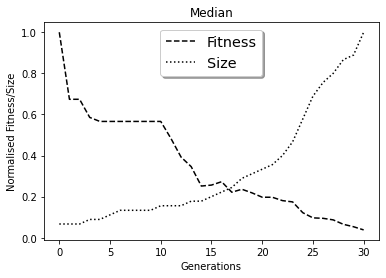

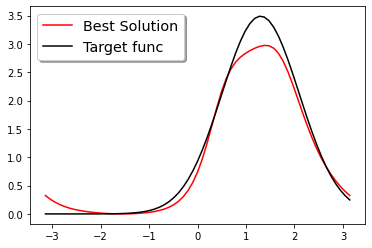

Best individual:
add(sin(x), sub(sin(mul(sin(sin(add(cos(add(1, cos(add(x, cos(sin(sub(sin(add(cos(sin(sin(sin(protectedDiv(add(mul(x, 1), x), add(sin(sin(cos(add(x, -1)))), 1)))))), mul(sub(1, 1), sin(x)))), -1))))))), mul(x, 1)))), sub(sin(x), -1))), -1))


In [145]:
#-----------Run Genetic Programming
random.seed()
pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)
pop, log = run(pop, hof)

#-Plot graph of notmalized fitness/size against generation 
plot_fitnessVsize(log)

#------Plot graph of target function and evolved function
plot_targetVevolved(target)

#-----------Print Best individual
print("Best individual:")
print_best()

<a name="report"></a>

### Report 

For these problems, the GA's fitness is built around the least squared distance and therefore the goal would be to minimize it.

The common observation in Problem 1 was that the fitness was almost stopping progressing (e.g. run 6 in config pop = 500, sel = 2). There, the fitness stayed the same since the initial population. I think this happened because the GA quickly ran into local minimum and couldn't progress from there. From statistics, it is clear that the population changed because the maximum and average fitnesses changed, but the median stayed close to the minimum. This is the case due that the individuals with minimum fitness kept spreading across the population. However, more usual behavior was when the fitness runs into such a local minimum but with help of mutation (or something else), the median fitness suddenly decreases or increases and then progresses as before. Nevertheless, this was not seen so clearly in Problem 2 and this 'plato' part of the graph was much shorter. In Problem 1 it was observed to happen from gen 3 and could last up until gen 30, however more usually until 20. In Problem 2 it mostly lasted from gen 3 to gen 10 or 15 at most and had a steady fitness decrease afterwards. This applies to all configurations.

As was expected before the runs, the population has a strong correlation with final minimum fitness. This can be seen from the summary tables. This also means that with greater population comes greater complexity, therefore number of total evaluations increases by much. This hasn't affected me in terms of time, but it is obvious that with more computationally complex tasks, this will mean much greater run time and worse performance. Problem 1 is a simple sinusoid and therefore doesn't always require this many (~49500) evaluations like in case with a population of 2000 and from time to time, the configurations with population of 500 produced decent results (min f < 0.005, from observations). In Problem 2, the solution wasn't as obvious and almost none of the produced solutions could be so-called 'decent'. Hence, it can be stated that for Problem 1, configuration with pop = 500 and sel = 5 will be a good compromise between performance and time complexity, even though it hasn't affected me, it will be a smart choice in a larger-scale project. For Problem 2, only configurations with a large population size could produce good results and thus have to be chosen. The tournament size was picked based on the statistics.

After another 10 runs in optimal configurations, the results show that a good solution for Problem 1 was found in a low number of solutions. It means that to find a solution it is favored but not required that every single run produces good results. Problem 2 is more complex and even though the picked configuration had good solutions in the first 10 runs, the second 10 runs hadn't. After all, it is a stochastic search and it depends on 'luck'.